<a href="https://colab.research.google.com/github/naiyajpatel/Renewind/blob/main/MT_Project_LearnerNotebook_FullCode_(3)_(1)_(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Problem Statement

### Business Context

Renewable energy sources play an increasingly important role in the global energy mix, as the effort to reduce the environmental impact of energy production increases.

Out of all the renewable energy alternatives, wind energy is one of the most developed technologies worldwide. The U.S Department of Energy has put together a guide to achieving operational efficiency using predictive maintenance practices.

Predictive maintenance uses sensor information and analysis methods to measure and predict degradation and future component capability. The idea behind predictive maintenance is that failure patterns are predictable and if component failure can be predicted accurately and the component is replaced before it fails, the costs of operation and maintenance will be much lower.

The sensors fitted across different machines involved in the process of energy generation collect data related to various environmental factors (temperature, humidity, wind speed, etc.) and additional features related to various parts of the wind turbine (gearbox, tower, blades, break, etc.).



## Objective
“ReneWind” is a company working on improving the machinery/processes involved in the production of wind energy using machine learning and has collected data of generator failure of wind turbines using sensors. They have shared a ciphered version of the data, as the data collected through sensors is confidential (the type of data collected varies with companies). Data has 40 predictors, 20000 observations in the training set and 5000 in the test set.

The objective is to build various classification models, tune them, and find the best one that will help identify failures so that the generators could be repaired before failing/breaking to reduce the overall maintenance cost.
The nature of predictions made by the classification model will translate as follows:

- True positives (TP) are failures correctly predicted by the model. These will result in repairing costs.
- False negatives (FN) are real failures where there is no detection by the model. These will result in replacement costs.
- False positives (FP) are detections where there is no failure. These will result in inspection costs.

It is given that the cost of repairing a generator is much less than the cost of replacing it, and the cost of inspection is less than the cost of repair.

“1” in the target variables should be considered as “failure” and “0” represents “No failure”.

## Data Description
- The data provided is a transformed version of original data which was collected using sensors.
- Train.csv - To be used for training and tuning of models.
- Test.csv - To be used only for testing the performance of the final best model.
- Both the datasets consist of 40 predictor variables and 1 target variable

## Importing necessary libraries

In [332]:
# Installing the libraries with the specified version.
!pip install pandas==1.5.3 numpy==1.25.2 matplotlib==3.7.1 seaborn==0.13.1 scikit-learn==1.2.2 imbalanced-learn==0.10.1 xgboost==2.0.3 threadpoolctl==3.3.0 -q --user

**Note:** After running the above cell, kindly restart the notebook kernel and run all cells sequentially from the start again.

In [333]:
# Libraries to help with reading and manipulating data
import pandas as pd
import numpy as np

# Libaries to help with data visualization
import matplotlib.pyplot as plt
import seaborn as sns

from joblib import parallel_backend

# To tune model, get different metric scores, and split data
from sklearn.metrics import (
    f1_score,
    accuracy_score,
    recall_score,
    precision_score,
    confusion_matrix,
    roc_auc_score,
    ConfusionMatrixDisplay,
)
from sklearn import metrics

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score

# To be used for data scaling and one hot encoding
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder

# To impute missing values
from sklearn.impute import SimpleImputer

# To oversample and undersample data
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

# To do hyperparameter tuning
from sklearn.model_selection import RandomizedSearchCV

# To be used for creating pipelines and personalizing them
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# To define maximum number of columns to be displayed in a dataframe
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)

# To supress scientific notations for a dataframe
pd.set_option("display.float_format", lambda x: "%.3f" % x)

# To help with model building
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (
    AdaBoostClassifier,
    GradientBoostingClassifier,
    RandomForestClassifier,
    BaggingClassifier,
)
from xgboost import XGBClassifier

# To suppress scientific notations
pd.set_option("display.float_format", lambda x: "%.3f" % x)

# To suppress warnings
import warnings

warnings.filterwarnings("ignore")

## Loading the dataset

In [334]:
# Mounting drive in colab
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [335]:
# deriving path for training data file to upload
path = '/content/drive/MyDrive/Train.csv'
data = pd.read_csv(path)

In [336]:
# deriving path for testing data file to upload
path1 = '/content/drive/MyDrive/Test.csv'
data_test = pd.read_csv(path1)

In [337]:
# Let's create a copy of train data
df = data.copy()

In [338]:
# Let's creat a copy of test data
df_test = data_test.copy()

In [339]:
# checking first five rows of train data
data.head()

V1     V2     V3     V4     V5     V6     V7     V8     V9    V10  \
0 -4.465 -4.679  3.102  0.506 -0.221 -2.033 -2.911  0.051 -1.522  3.762   
1  3.366  3.653  0.910 -1.368  0.332  2.359  0.733 -4.332  0.566 -0.101   
2 -3.832 -5.824  0.634 -2.419 -1.774  1.017 -2.099 -3.173 -2.082  5.393   
3  1.618  1.888  7.046 -1.147  0.083 -1.530  0.207 -2.494  0.345  2.119   
4 -0.111  3.872 -3.758 -2.983  3.793  0.545  0.205  4.849 -1.855 -6.220   

     V11    V12    V13    V14    V15    V16    V17    V18    V19    V20  \
0 -5.715  0.736  0.981  1.418 -3.376 -3.047  0.306  2.914  2.270  4.395   
1  1.914 -0.951 -1.255 -2.707  0.193 -4.769 -2.205  0.908  0.757 -5.834   
2 -0.771  1.107  1.144  0.943 -3.164 -4.248 -4.039  3.689  3.311  1.059   
3 -3.053  0.460  2.705 -0.636 -0.454 -3.174 -3.404 -1.282  1.582 -1.952   
4  1.998  4.724  0.709 -1.989 -2.633  4.184  2.245  3.734 -6.313 -5.380   

     V21    V22    V23    V24    V25    V26    V27    V28    V29    V30  \
0 -2.388  0.646 -1.191  3.133  0.665 -2.511 -0.037  0.726 -3.982 -1.073   
1 -3.065  1.597 -1.757  1.766 -0.267  3.625  1.500 -0.586  0.783 -0.201   
2 -2.143  1.650 -1.661  1.680 -0.451 -4.551  3.739  1.134 -2.034  0.841   
3 -3.517 -1.206 -5.628 -1.818  2.124  5.295  4.748 -2.309 -3.963 -6.029   
4 -0.887  2.062  9.446  4.490 -3.945  4.582 -8.780 -3.383  5.107  6.788   

     V31    V32    V33     V34   V35    V36    V37    V38    V39    V40  \
0  1.667  3.060 -1.690   2.846 2.235  6.667  0.444 -2.369  2.951 -3.480   
1  0.025 -1.795  3.033  -2.468 1.895 -2.298 -1.731  5.909 -0.386  0.616   
2 -1.600 -0.257  0.804   4.086 2.292  5.361  0.352  2.940  3.839 -4.309   
3  4.949 -3.584 -2.577   1.364 0.623  5.550 -1.527  0.139  3.101 -1.277   
4  2.044  8.266  6.629 -10.069 1.223 -3.230  1.687 -2.164 -3.645  6.510   

   Target  
0       0  
1       0  
2       0  
3       0  
4       0

In [340]:
# Checking first five rows of test data
data_test.head()

V1     V2     V3     V4     V5     V6     V7     V8     V9    V10  \
0 -0.613 -3.820  2.202  1.300 -1.185 -4.496 -1.836  4.723  1.206 -0.342   
1  0.390 -0.512  0.527 -2.577 -1.017  2.235 -0.441 -4.406 -0.333  1.967   
2 -0.875 -0.641  4.084 -1.590  0.526 -1.958 -0.695  1.347 -1.732  0.466   
3  0.238  1.459  4.015  2.534  1.197 -3.117 -0.924  0.269  1.322  0.702   
4  5.828  2.768 -1.235  2.809 -1.642 -1.407  0.569  0.965  1.918 -2.775   

     V11    V12    V13    V14    V15    V16    V17    V18    V19    V20  \
0 -5.123  1.017  4.819  3.269 -2.984  1.387  2.032 -0.512 -1.023  7.339   
1  1.797  0.410  0.638 -1.390 -1.883 -5.018 -3.827  2.418  1.762 -3.242   
2 -4.928  3.565 -0.449 -0.656 -0.167 -1.630  2.292  2.396  0.601  1.794   
3 -5.578 -0.851  2.591  0.767 -2.391 -2.342  0.572 -0.934  0.509  1.211   
4 -0.530  1.375 -0.651 -1.679 -0.379 -4.443  3.894 -0.608  2.945  0.367   

     V21   V22    V23    V24    V25    V26    V27    V28    V29    V30    V31  \
0 -2.242 0.155  2.054 -2.772  1.851 -1.789 -0.277 -1.255 -3.833 -1.505  1.587   
1 -3.193 1.857 -1.708  0.633 -0.588  0.084  3.014 -0.182  0.224  0.865 -1.782   
2 -2.120 0.482 -0.841  1.790  1.874  0.364 -0.169 -0.484 -2.119 -2.157  2.907   
3 -3.260 0.105 -0.659  1.498  1.100  4.143 -0.248 -1.137 -5.356 -4.546  3.809   
4 -5.789 4.598  4.450  3.225  0.397  0.248 -2.362  1.079 -0.473  2.243 -3.591   

     V32    V33    V34   V35    V36    V37     V38    V39    V40  Target  
0  2.291 -5.411  0.870 0.574  4.157  1.428 -10.511  0.455 -1.448       0  
1 -2.475  2.494  0.315 2.059  0.684 -0.485   5.128  1.721 -1.488       0  
2 -1.319 -2.997  0.460 0.620  5.632  1.324  -1.752  1.808  1.676       0  
3  3.518 -3.074 -0.284 0.955  3.029 -1.367  -3.412  0.906 -2.451       0  
4  1.774 -1.502 -2.227 4.777 -6.560 -0.806  -0.276 -3.858 -0.538       0

In [341]:
# Checking last five rows of train data
data.tail()

V1      V2     V3     V4     V5     V6     V7     V8     V9    V10  \
19995 -2.071  -1.088 -0.796 -3.012 -2.288  2.807  0.481  0.105 -0.587 -2.899   
19996  2.890   2.483  5.644  0.937 -1.381  0.412 -1.593 -5.762  2.150  0.272   
19997 -3.897  -3.942 -0.351 -2.417  1.108 -1.528 -3.520  2.055 -0.234 -0.358   
19998 -3.187 -10.052  5.696 -4.370 -5.355 -1.873 -3.947  0.679 -2.389  5.457   
19999 -2.687   1.961  6.137  2.600  2.657 -4.291 -2.344  0.974 -1.027  0.497   

         V11    V12   V13    V14    V15     V16    V17    V18    V19    V20  \
19995  8.868  1.717 1.358 -1.777  0.710   4.945 -3.100 -1.199 -1.085 -0.365   
19996 -2.095 -1.526 0.072 -3.540 -2.762 -10.632 -0.495  1.720  3.872 -1.210   
19997 -3.782  2.180 6.112  1.985 -8.330  -1.639 -0.915  5.672 -3.924  2.133   
19998  1.583  3.571 9.227  2.554 -7.039  -0.994 -9.665  1.155  3.877  3.524   
19999 -9.589  3.177 1.055 -1.416 -4.669  -5.405  3.720  2.893  2.329  1.458   

         V21    V22    V23    V24    V25    V26    V27    V28    V29    V30  \
19995  3.131 -3.948 -3.578 -8.139 -1.937 -1.328 -0.403 -1.735  9.996  6.955   
19996 -8.222  2.121 -5.492  1.452  1.450  3.685  1.077 -0.384 -0.839 -0.748   
19997 -4.502  2.777  5.728  1.620 -1.700 -0.042 -2.923 -2.760 -2.254  2.552   
19998 -7.015 -0.132 -3.446 -4.801 -0.876 -3.812  5.422 -3.732  0.609  5.256   
19999 -6.429  1.818  0.806  7.786  0.331  5.257 -4.867 -0.819 -5.667 -2.861   

         V31    V32    V33    V34    V35    V36    V37    V38   V39    V40  \
19995 -3.938 -8.274  5.745  0.589 -0.650 -3.043  2.216  0.609 0.178  2.928   
19996 -1.089 -4.159  1.181 -0.742  5.369 -0.693 -1.669  3.660 0.820 -1.987   
19997  0.982  7.112  1.476 -3.954  1.856  5.029  2.083 -6.409 1.477 -0.874   
19998  1.915  0.403  3.164  3.752  8.530  8.451  0.204 -7.130 4.249 -6.112   
19999  4.674  6.621 -1.989 -1.349  3.952  5.450 -0.455 -2.202 1.678 -1.974   

       Target  
19995       1  
19996       0  
19997       0  
19998       0  
19999       0

In [342]:
# Checking last five rows of test data
data_test.tail()

V1     V2     V3     V4     V5     V6     V7     V8     V9    V10  \
4995 -5.120  1.635  1.251  4.036  3.291 -2.932 -1.329  1.754 -2.985  1.249   
4996 -5.172  1.172  1.579  1.220  2.530 -0.669 -2.618 -2.001  0.634 -0.579   
4997 -1.114 -0.404 -1.765 -5.879  3.572  3.711 -2.483 -0.308 -0.922 -2.999   
4998 -1.703  0.615  6.221 -0.104  0.956 -3.279 -1.634 -0.104  1.388 -1.066   
4999 -0.604  0.960 -0.721  8.230 -1.816 -2.276 -2.575 -1.041  4.130 -2.731   

        V11    V12    V13    V14    V15    V16    V17   V18    V19    V20  \
4995 -6.878  3.715 -2.512 -1.395 -2.554 -2.197  4.772 2.403  3.792  0.487   
4996 -3.671  0.460  3.321 -1.075 -7.113 -4.356 -0.001 3.698 -0.846 -0.222   
4997 -0.112 -1.977 -1.623 -0.945 -2.735 -0.813  0.610 8.149 -9.199 -3.872   
4998 -7.970  2.262  3.134 -0.486 -3.498 -4.562  3.136 2.536 -0.792  4.398   
4999 -3.292 -1.674  0.465 -1.646 -5.263 -7.988  6.480 0.226  4.963  6.752   

        V21    V22    V23    V24    V25    V26    V27    V28    V29    V30  \
4995 -2.028  1.778  3.668 11.375 -1.977  2.252 -7.319  1.907 -3.734 -0.012   
4996 -3.645  0.736  0.926  3.278 -2.277  4.458 -4.543 -1.348 -1.779  0.352   
4997 -0.296  1.468  2.884  2.792 -1.136  1.198 -4.342 -2.869  4.124  4.197   
4998 -4.073 -0.038 -2.371 -1.542  2.908  3.215 -0.169 -1.541 -4.724 -5.525   
4999 -6.306  3.271  1.897  3.271 -0.637 -0.925 -6.759  2.990 -0.814  3.499   

        V31    V32    V33     V34    V35    V36    V37    V38    V39    V40  \
4995  2.120  9.979  0.063   0.217  3.036  2.109 -0.557  1.939  0.513 -2.694   
4996 -0.214  4.424  2.604  -2.152  0.917  2.157  0.467  0.470  2.197 -2.377   
4997  3.471  3.792  7.482 -10.061 -0.387  1.849  1.818 -1.246 -1.261  7.475   
4998  1.668 -4.100 -5.949   0.550 -1.574  6.824  2.139 -4.036  3.436  0.579   
4999 -8.435  2.370 -1.062   0.791  4.952 -7.441 -0.070 -0.918 -2.291 -5.363   

      Target  
4995       0  
4996       0  
4997       0  
4998       0  
4999       0

In [343]:
# Checking shape of train data
data.shape

(20000, 41)

In [344]:
# Checking shape of test data
data_test.shape

(5000, 41)

In [345]:
# Checking description of train data
data.describe(include='all').T

count   mean   std     min    25%    50%    75%    max
V1     19982.000 -0.272 3.442 -11.876 -2.737 -0.748  1.840 15.493
V2     19982.000  0.440 3.151 -12.320 -1.641  0.472  2.544 13.089
V3     20000.000  2.485 3.389 -10.708  0.207  2.256  4.566 17.091
V4     20000.000 -0.083 3.432 -15.082 -2.348 -0.135  2.131 13.236
V5     20000.000 -0.054 2.105  -8.603 -1.536 -0.102  1.340  8.134
V6     20000.000 -0.995 2.041 -10.227 -2.347 -1.001  0.380  6.976
V7     20000.000 -0.879 1.762  -7.950 -2.031 -0.917  0.224  8.006
V8     20000.000 -0.548 3.296 -15.658 -2.643 -0.389  1.723 11.679
V9     20000.000 -0.017 2.161  -8.596 -1.495 -0.068  1.409  8.138
V10    20000.000 -0.013 2.193  -9.854 -1.411  0.101  1.477  8.108
V11    20000.000 -1.895 3.124 -14.832 -3.922 -1.921  0.119 11.826
V12    20000.000  1.605 2.930 -12.948 -0.397  1.508  3.571 15.081
V13    20000.000  1.580 2.875 -13.228 -0.224  1.637  3.460 15.420
V14    20000.000 -0.951 1.790  -7.739 -2.171 -0.957  0.271  5.671
V15    20000.000 -2.415 3.355 -16.417 -4.415 -2.383 -0.359 12.246
V16    20000.000 -2.925 4.222 -20.374 -5.634 -2.683 -0.095 13.583
V17    20000.000 -0.134 3.345 -14.091 -2.216 -0.015  2.069 16.756
V18    20000.000  1.189 2.592 -11.644 -0.404  0.883  2.572 13.180
V19    20000.000  1.182 3.397 -13.492 -1.050  1.279  3.493 13.238
V20    20000.000  0.024 3.669 -13.923 -2.433  0.033  2.512 16.052
V21    20000.000 -3.611 3.568 -17.956 -5.930 -3.533 -1.266 13.840
V22    20000.000  0.952 1.652 -10.122 -0.118  0.975  2.026  7.410
V23    20000.000 -0.366 4.032 -14.866 -3.099 -0.262  2.452 14.459
V24    20000.000  1.134 3.912 -16.387 -1.468  0.969  3.546 17.163
V25    20000.000 -0.002 2.017  -8.228 -1.365  0.025  1.397  8.223
V26    20000.000  1.874 3.435 -11.834 -0.338  1.951  4.130 16.836
V27    20000.000 -0.612 4.369 -14.905 -3.652 -0.885  2.189 17.560
V28    20000.000 -0.883 1.918  -9.269 -2.171 -0.891  0.376  6.528
V29    20000.000 -0.986 2.684 -12.579 -2.787 -1.176  0.630 10.722
V30    20000.000 -0.016 3.005 -14.796 -1.867  0.184  2.036 12.506
V31    20000.000  0.487 3.461 -13.723 -1.818  0.490  2.731 17.255
V32    20000.000  0.304 5.500 -19.877 -3.420  0.052  3.762 23.633
V33    20000.000  0.050 3.575 -16.898 -2.243 -0.066  2.255 16.692
V34    20000.000 -0.463 3.184 -17.985 -2.137 -0.255  1.437 14.358
V35    20000.000  2.230 2.937 -15.350  0.336  2.099  4.064 15.291
V36    20000.000  1.515 3.801 -14.833 -0.944  1.567  3.984 19.330
V37    20000.000  0.011 1.788  -5.478 -1.256 -0.128  1.176  7.467
V38    20000.000 -0.344 3.948 -17.375 -2.988 -0.317  2.279 15.290
V39    20000.000  0.891 1.753  -6.439 -0.272  0.919  2.058  7.760
V40    20000.000 -0.876 3.012 -11.024 -2.940 -0.921  1.120 10.654
Target 20000.000  0.056 0.229   0.000  0.000  0.000  0.000  1.000

In [346]:
# Checking description of test data
data_test.describe(include='all').T

count   mean   std     min    25%    50%    75%    max
V1     4995.000 -0.278 3.466 -12.382 -2.744 -0.765  1.831 13.504
V2     4994.000  0.398 3.140 -10.716 -1.649  0.427  2.444 14.079
V3     5000.000  2.552 3.327  -9.238  0.315  2.260  4.587 15.315
V4     5000.000 -0.049 3.414 -14.682 -2.293 -0.146  2.166 12.140
V5     5000.000 -0.080 2.111  -7.712 -1.615 -0.132  1.341  7.673
V6     5000.000 -1.042 2.005  -8.924 -2.369 -1.049  0.308  5.068
V7     5000.000 -0.908 1.769  -8.124 -2.054 -0.940  0.212  7.616
V8     5000.000 -0.575 3.332 -12.253 -2.642 -0.358  1.713 10.415
V9     5000.000  0.030 2.174  -6.785 -1.456 -0.080  1.450  8.851
V10    5000.000  0.019 2.145  -8.171 -1.353  0.166  1.511  6.599
V11    5000.000 -2.009 3.112 -13.152 -4.050 -2.043  0.044  9.956
V12    5000.000  1.576 2.907  -8.164 -0.450  1.488  3.563 12.984
V13    5000.000  1.622 2.883 -11.548 -0.126  1.719  3.465 12.620
V14    5000.000 -0.921 1.803  -7.814 -2.111 -0.896  0.272  5.734
V15    5000.000 -2.452 3.387 -15.286 -4.479 -2.417 -0.433 11.673
V16    5000.000 -3.019 4.264 -20.986 -5.648 -2.774 -0.178 13.976
V17    5000.000 -0.104 3.337 -13.418 -2.228  0.047  2.112 19.777
V18    5000.000  1.196 2.586 -12.214 -0.409  0.881  2.604 13.642
V19    5000.000  1.210 3.385 -14.170 -1.026  1.296  3.526 12.428
V20    5000.000  0.138 3.657 -13.720 -2.325  0.193  2.540 13.871
V21    5000.000 -3.664 3.578 -16.341 -5.944 -3.663 -1.330 11.047
V22    5000.000  0.962 1.640  -6.740 -0.048  0.986  2.029  7.505
V23    5000.000 -0.422 4.057 -14.422 -3.163 -0.279  2.426 13.181
V24    5000.000  1.089 3.968 -12.316 -1.623  0.913  3.537 17.806
V25    5000.000  0.061 2.010  -6.770 -1.298  0.077  1.428  6.557
V26    5000.000  1.847 3.400 -11.414 -0.242  1.917  4.156 17.528
V27    5000.000 -0.552 4.403 -13.177 -3.663 -0.872  2.247 17.290
V28    5000.000 -0.868 1.926  -7.933 -2.160 -0.931  0.421  7.416
V29    5000.000 -1.096 2.655  -9.988 -2.861 -1.341  0.522 14.039
V30    5000.000 -0.119 3.023 -12.438 -1.997  0.112  1.946 10.315
V31    5000.000  0.469 3.446 -11.263 -1.822  0.486  2.779 12.559
V32    5000.000  0.233 5.586 -17.244 -3.556 -0.077  3.752 26.539
V33    5000.000 -0.080 3.539 -14.904 -2.348 -0.160  2.099 13.324
V34    5000.000 -0.393 3.166 -14.700 -2.010 -0.172  1.465 12.146
V35    5000.000  2.211 2.948 -12.261  0.322  2.112  4.032 13.489
V36    5000.000  1.595 3.775 -12.736 -0.866  1.703  4.104 17.116
V37    5000.000  0.023 1.785  -5.079 -1.241 -0.110  1.238  6.810
V38    5000.000 -0.406 3.969 -15.335 -2.984 -0.381  2.288 13.065
V39    5000.000  0.939 1.717  -5.451 -0.208  0.959  2.131  7.182
V40    5000.000 -0.932 2.978 -10.076 -2.987 -1.003  1.080  8.698
Target 5000.000  0.056 0.231   0.000  0.000  0.000  0.000  1.000

In [347]:
# Checking info of train data
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 41 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   V1      19982 non-null  float64
 1   V2      19982 non-null  float64
 2   V3      20000 non-null  float64
 3   V4      20000 non-null  float64
 4   V5      20000 non-null  float64
 5   V6      20000 non-null  float64
 6   V7      20000 non-null  float64
 7   V8      20000 non-null  float64
 8   V9      20000 non-null  float64
 9   V10     20000 non-null  float64
 10  V11     20000 non-null  float64
 11  V12     20000 non-null  float64
 12  V13     20000 non-null  float64
 13  V14     20000 non-null  float64
 14  V15     20000 non-null  float64
 15  V16     20000 non-null  float64
 16  V17     20000 non-null  float64
 17  V18     20000 non-null  float64
 18  V19     20000 non-null  float64
 19  V20     20000 non-null  float64
 20  V21     20000 non-null  float64
 21  V22     20000 non-null  float64
 22

In [348]:
# Checking info of test data
data_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 41 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   V1      4995 non-null   float64
 1   V2      4994 non-null   float64
 2   V3      5000 non-null   float64
 3   V4      5000 non-null   float64
 4   V5      5000 non-null   float64
 5   V6      5000 non-null   float64
 6   V7      5000 non-null   float64
 7   V8      5000 non-null   float64
 8   V9      5000 non-null   float64
 9   V10     5000 non-null   float64
 10  V11     5000 non-null   float64
 11  V12     5000 non-null   float64
 12  V13     5000 non-null   float64
 13  V14     5000 non-null   float64
 14  V15     5000 non-null   float64
 15  V16     5000 non-null   float64
 16  V17     5000 non-null   float64
 17  V18     5000 non-null   float64
 18  V19     5000 non-null   float64
 19  V20     5000 non-null   float64
 20  V21     5000 non-null   float64
 21  V22     5000 non-null   float64
 22  

In [349]:
# Checking number of null values in train data
data.isnull().sum()

V1        18
V2        18
V3         0
V4         0
V5         0
V6         0
V7         0
V8         0
V9         0
V10        0
V11        0
V12        0
V13        0
V14        0
V15        0
V16        0
V17        0
V18        0
V19        0
V20        0
V21        0
V22        0
V23        0
V24        0
V25        0
V26        0
V27        0
V28        0
V29        0
V30        0
V31        0
V32        0
V33        0
V34        0
V35        0
V36        0
V37        0
V38        0
V39        0
V40        0
Target     0
dtype: int64

In [350]:
# Checking number of null values in test data
data_test.isnull().sum()

V1        5
V2        6
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
V29       0
V30       0
V31       0
V32       0
V33       0
V34       0
V35       0
V36       0
V37       0
V38       0
V39       0
V40       0
Target    0
dtype: int64

Observation: There are total 36 missing values in train data and 11 missing values in test data. We will impute missing value treatment after splitting the data.

In [351]:
# Checking duplicates in train data
data.duplicated().sum()

np.int64(0)

In [352]:
# Checking duplicates in test data
data_test.duplicated().sum()

np.int64(0)

Observations: No duplicates present in train or test data

## Data Overview

- Observations
- Sanity checks

In [353]:
# Checking number of uniques values in train data
data.nunique()

V1        19982
V2        19982
V3        20000
V4        20000
V5        20000
V6        20000
V7        20000
V8        20000
V9        20000
V10       20000
V11       20000
V12       20000
V13       20000
V14       20000
V15       20000
V16       20000
V17       20000
V18       20000
V19       20000
V20       20000
V21       20000
V22       20000
V23       20000
V24       20000
V25       20000
V26       20000
V27       20000
V28       20000
V29       20000
V30       20000
V31       20000
V32       20000
V33       20000
V34       20000
V35       20000
V36       20000
V37       20000
V38       20000
V39       20000
V40       20000
Target        2
dtype: int64

In [354]:
# Checking number of uniques values in test data
data_test.nunique()

V1        4995
V2        4994
V3        5000
V4        5000
V5        5000
V6        5000
V7        5000
V8        5000
V9        5000
V10       5000
V11       5000
V12       5000
V13       5000
V14       5000
V15       5000
V16       5000
V17       5000
V18       5000
V19       5000
V20       5000
V21       5000
V22       5000
V23       5000
V24       5000
V25       5000
V26       5000
V27       5000
V28       5000
V29       5000
V30       5000
V31       5000
V32       5000
V33       5000
V34       5000
V35       5000
V36       5000
V37       5000
V38       5000
V39       5000
V40       5000
Target       2
dtype: int64

## Exploratory Data Analysis (EDA)

### Plotting histograms and boxplots for all the variables

In [355]:
# function to plot a boxplot and a histogram along the same scale.


def histogram_boxplot(data, feature, figsize=(12, 7), kde=False, bins=None):
    """
    Boxplot and histogram combined

    data: dataframe
    feature: dataframe column
    figsize: size of figure (default (12,7))
    kde: whether to the show density curve (default False)
    bins: number of bins for histogram (default None)
    """
    f2, (ax_box2, ax_hist2) = plt.subplots(
        nrows=2,  # Number of rows of the subplot grid= 2
        sharex=True,  # x-axis will be shared among all subplots
        gridspec_kw={"height_ratios": (0.25, 0.75)},
        figsize=figsize,
    )  # creating the 2 subplots
    sns.boxplot(
        data=data, x=feature, ax=ax_box2, showmeans=True, color="violet"
    )  # boxplot will be created and a star will indicate the mean value of the column
    sns.histplot(
        data=data, x=feature, kde=kde, ax=ax_hist2, bins=bins, palette="winter"
    ) if bins else sns.histplot(
        data=data, x=feature, kde=kde, ax=ax_hist2
    )  # For histogram
    ax_hist2.axvline(
        data[feature].mean(), color="green", linestyle="--"
    )  # Add mean to the histogram
    ax_hist2.axvline(
        data[feature].median(), color="black", linestyle="-"
    )  # Add median to the histogram

### Plotting all the features at one go

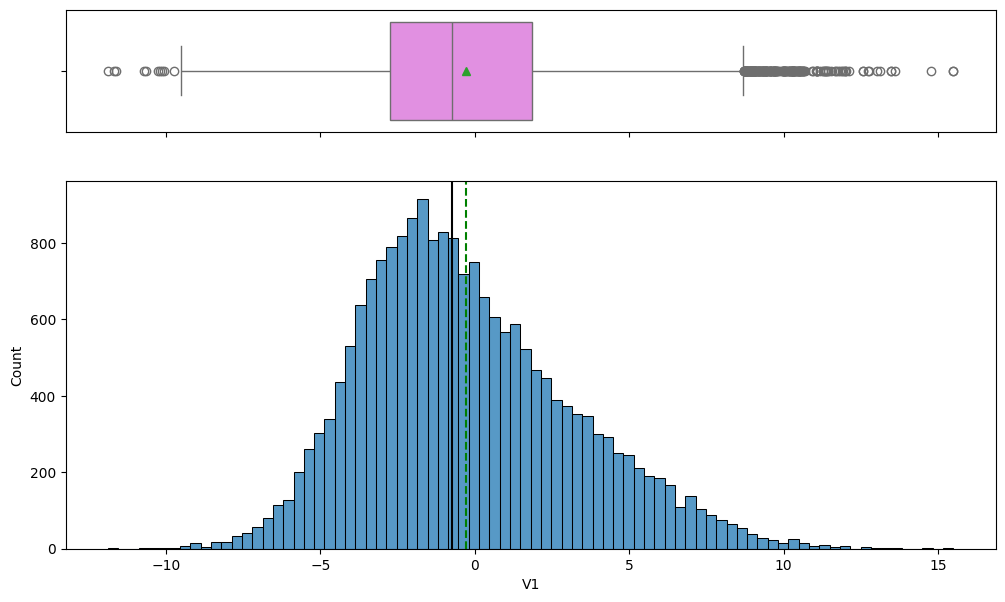

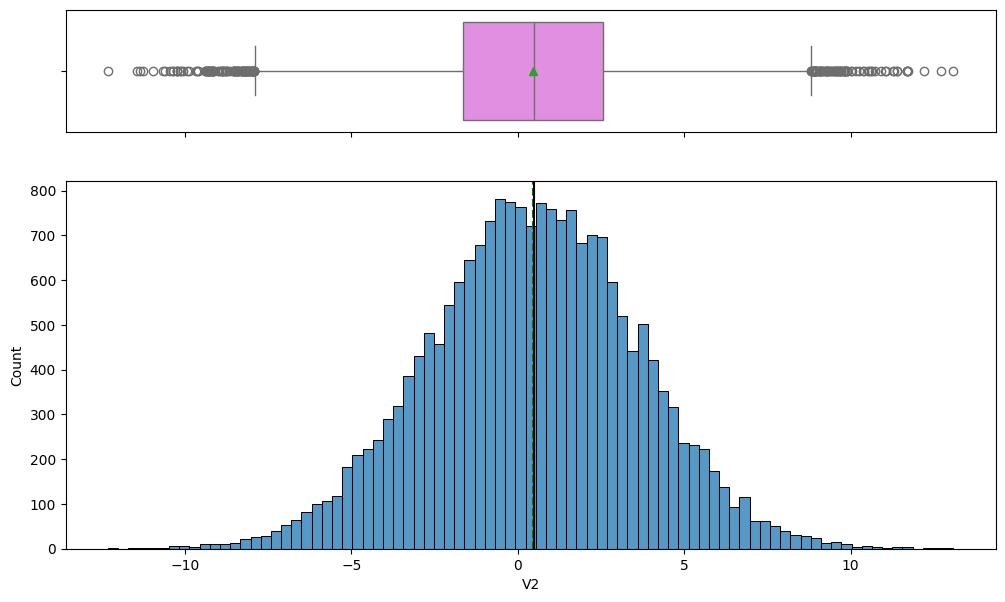

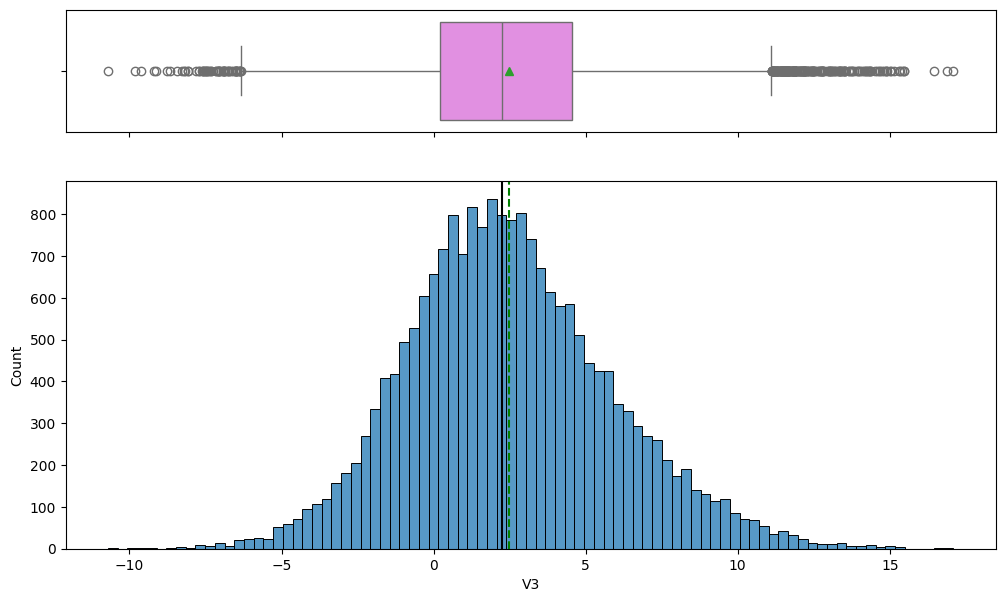

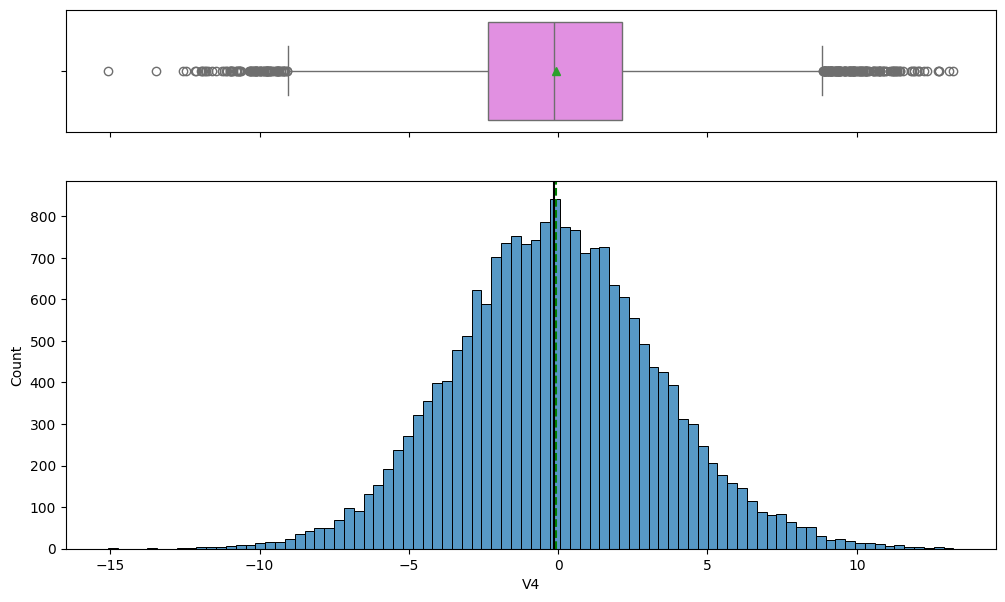

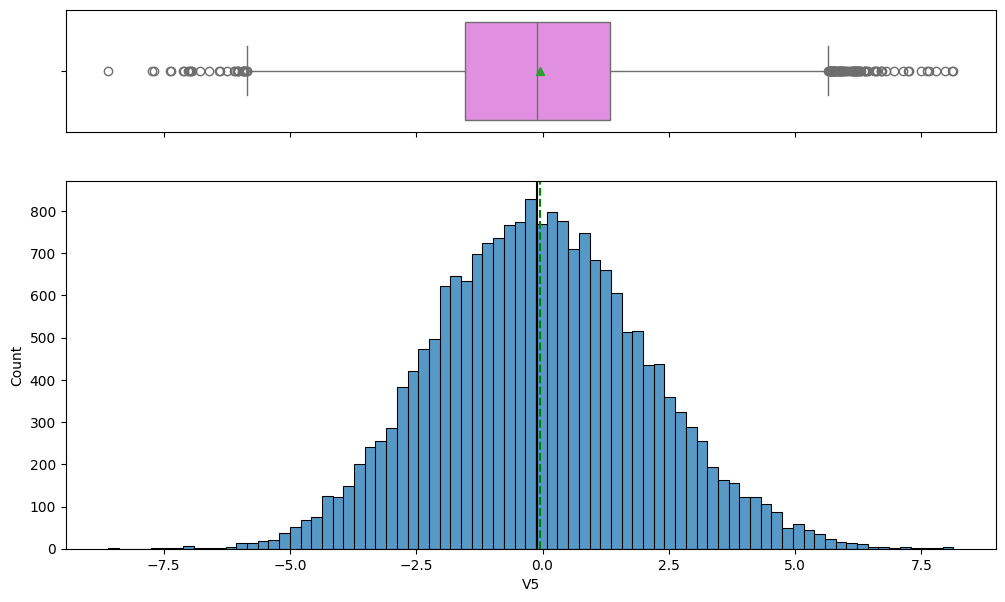

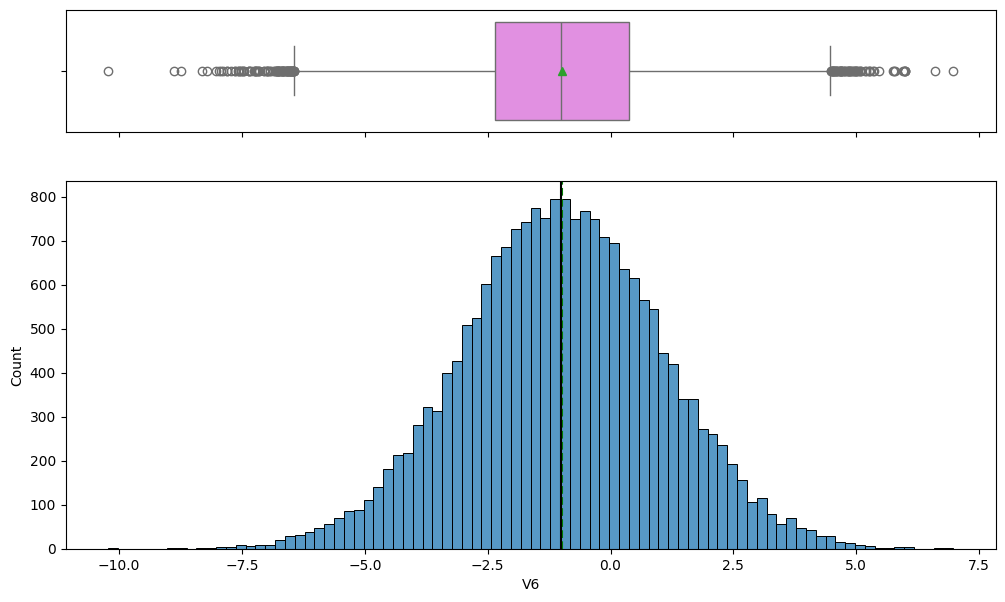

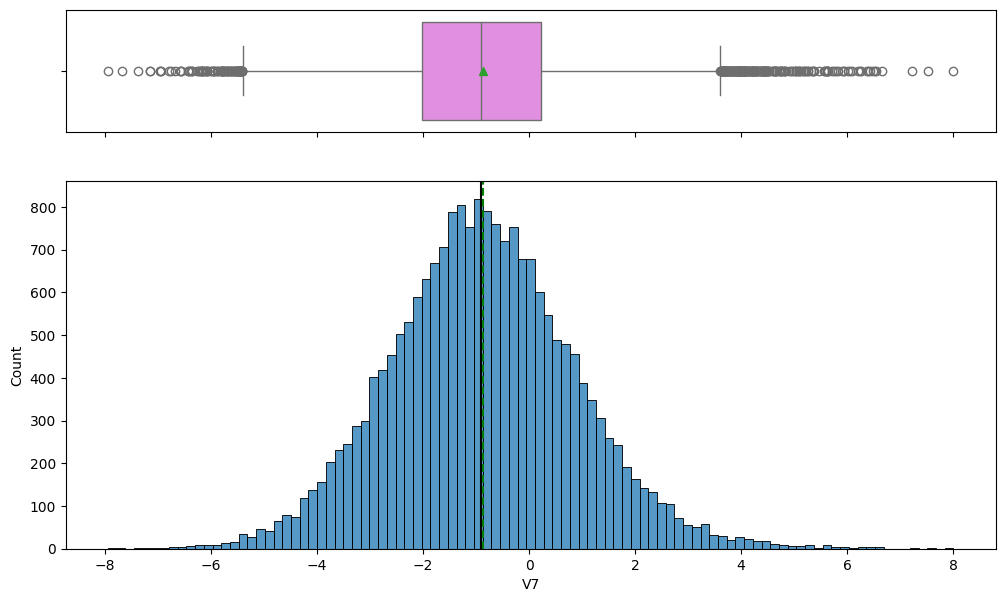

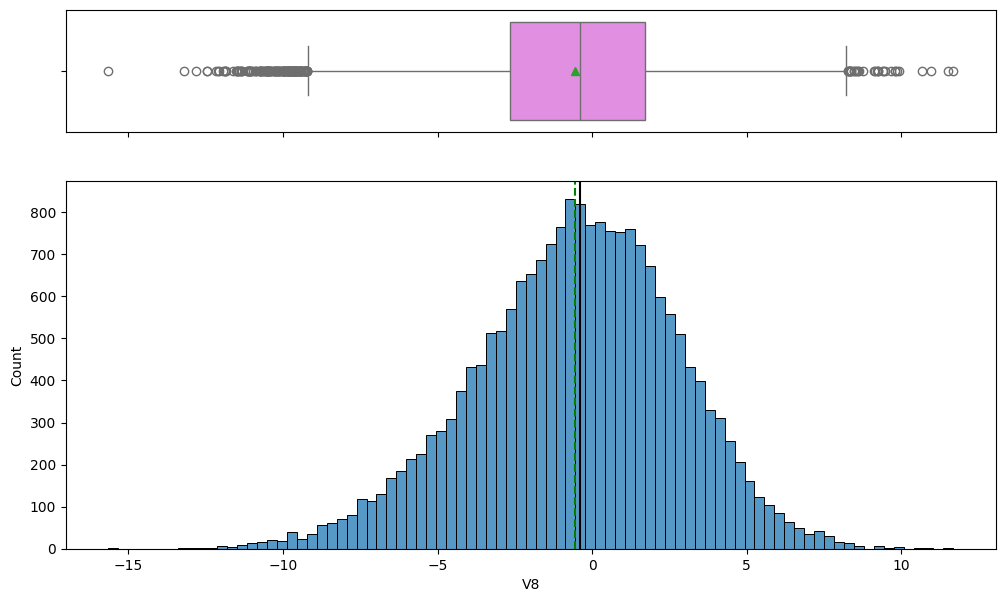

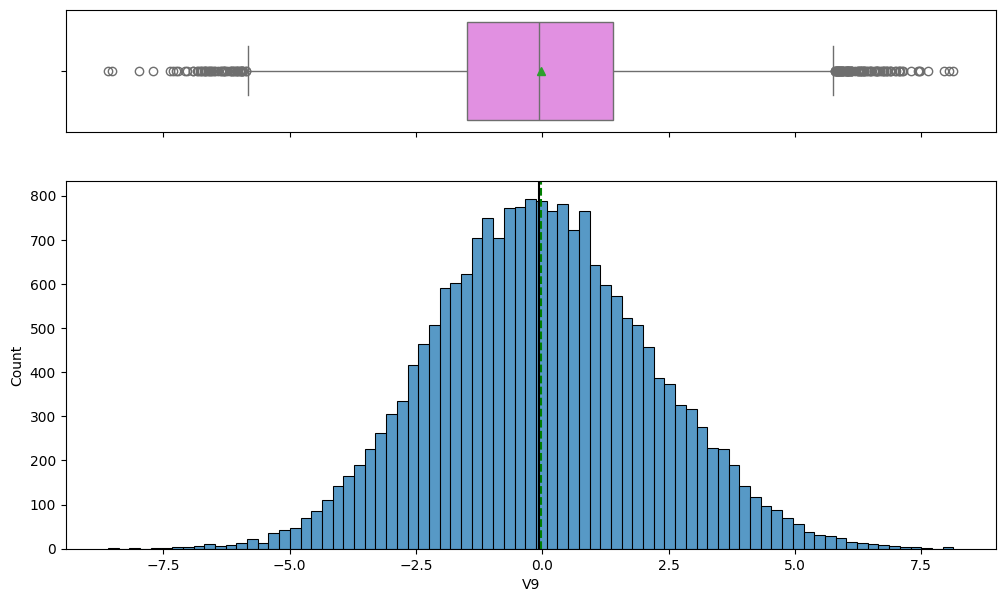

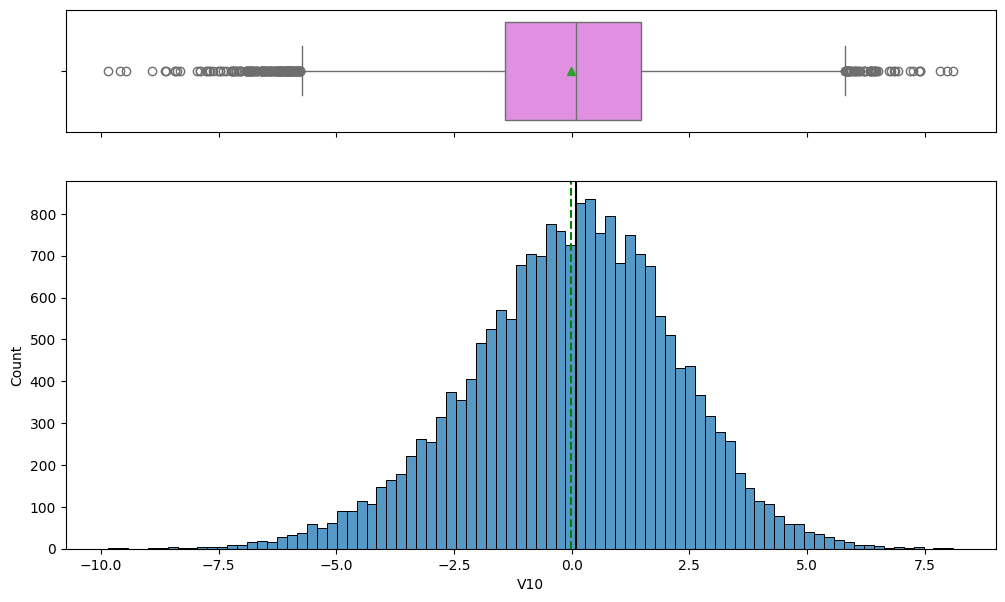

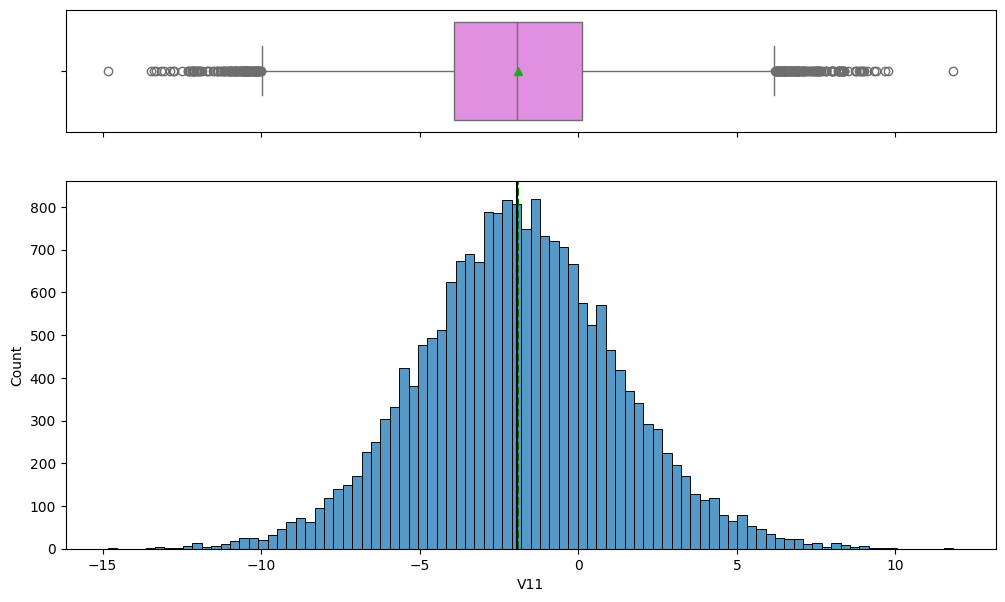

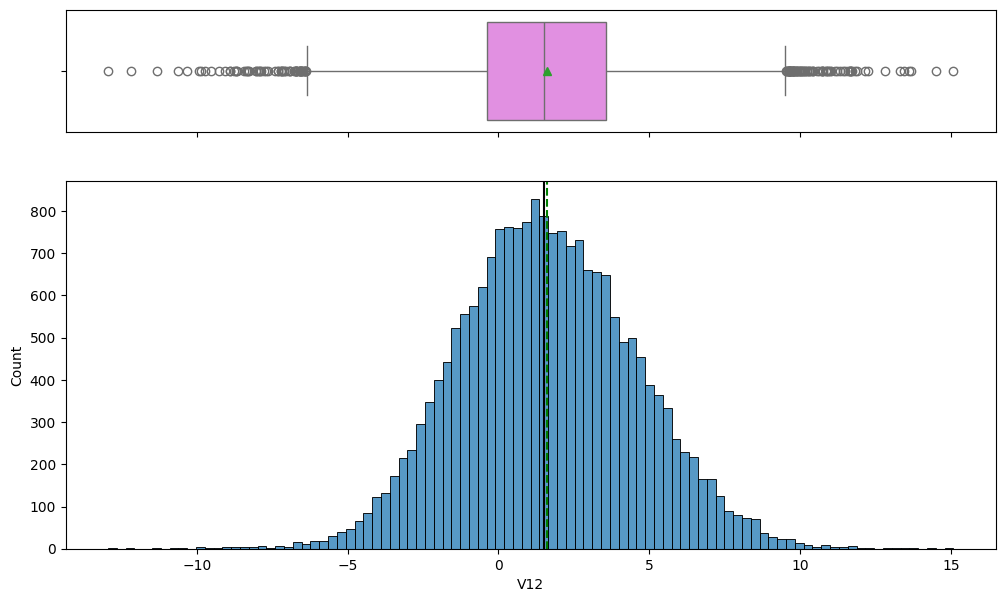

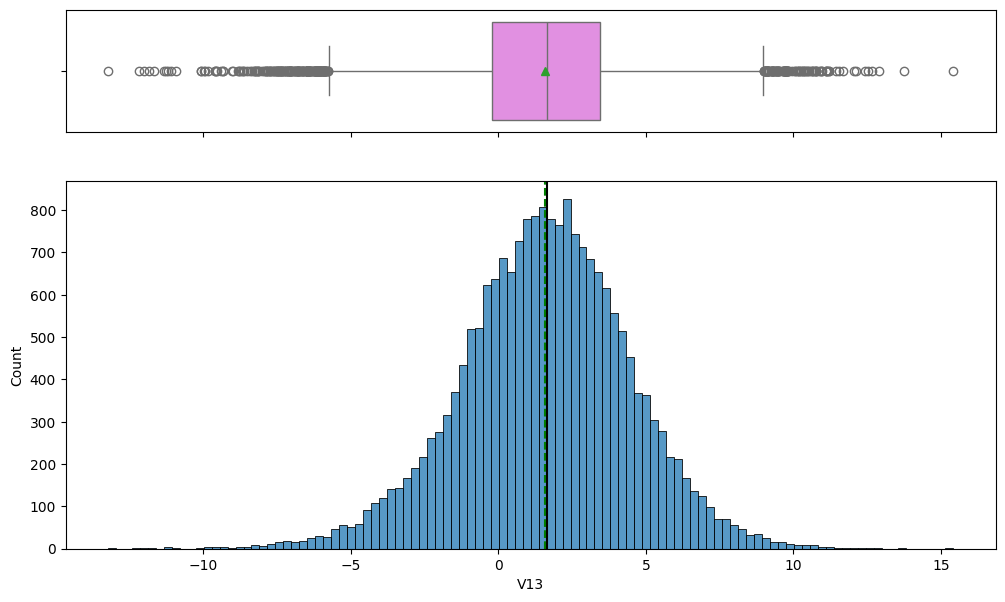

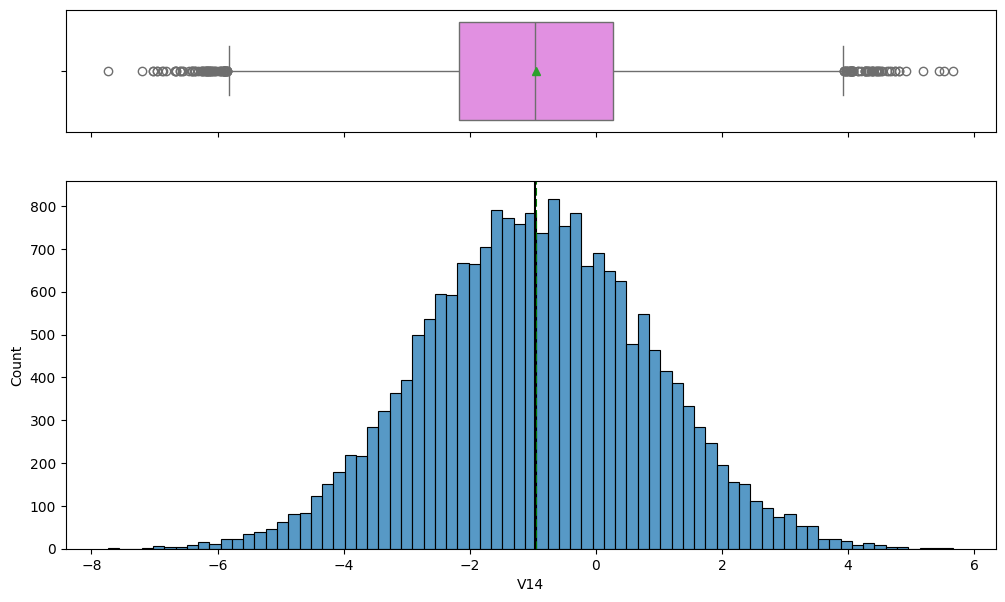

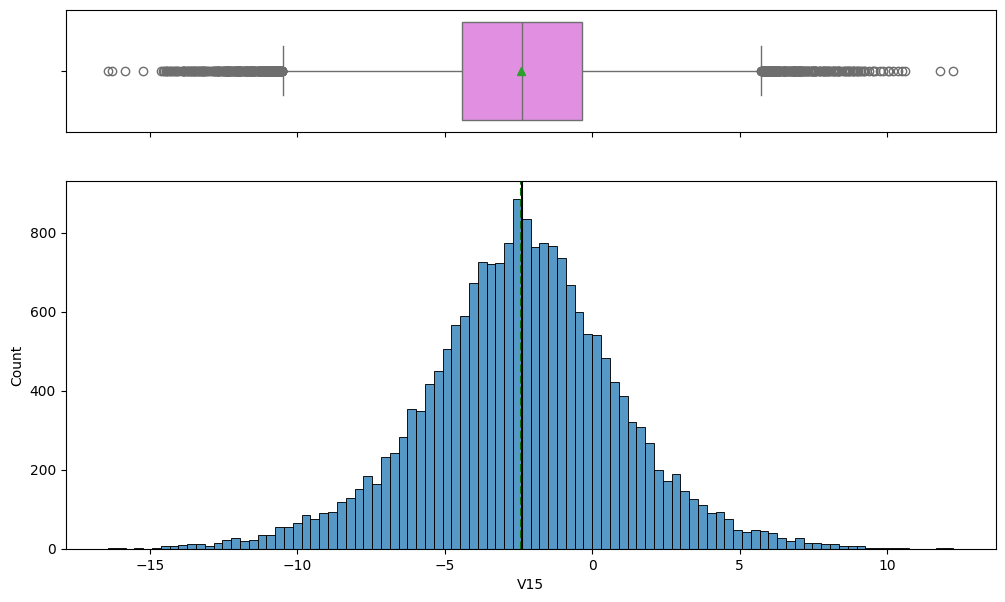

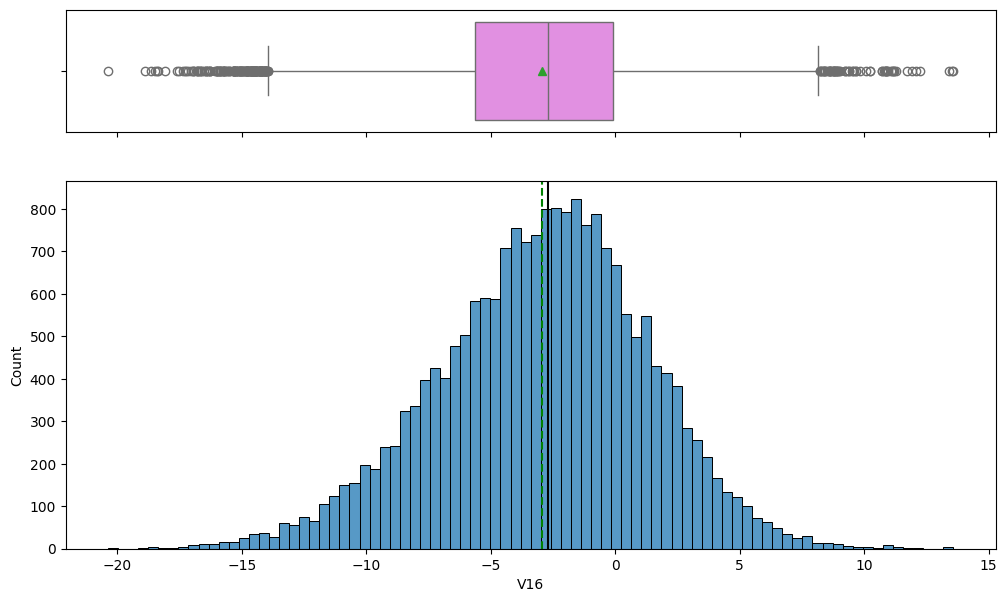

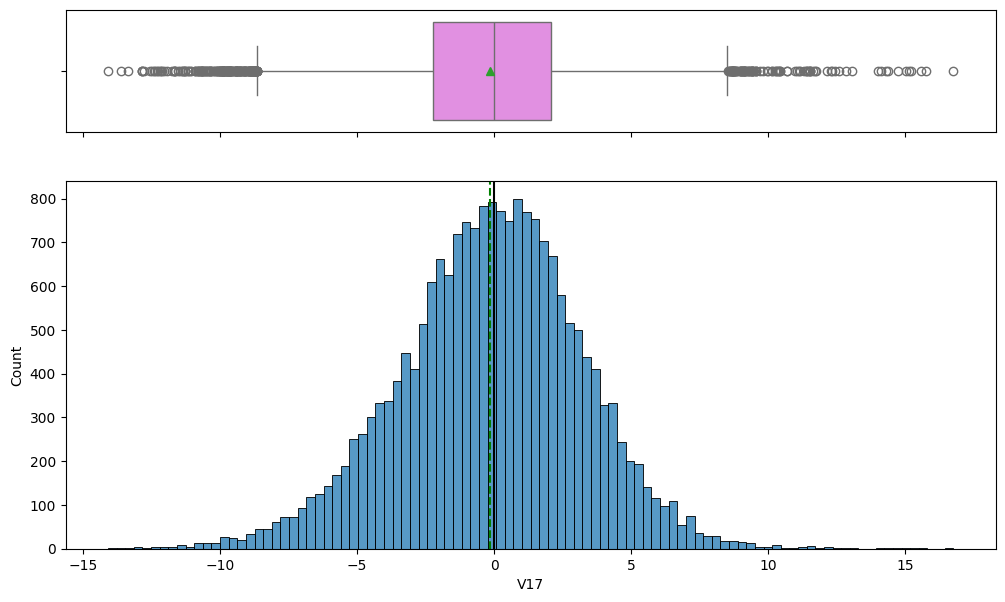

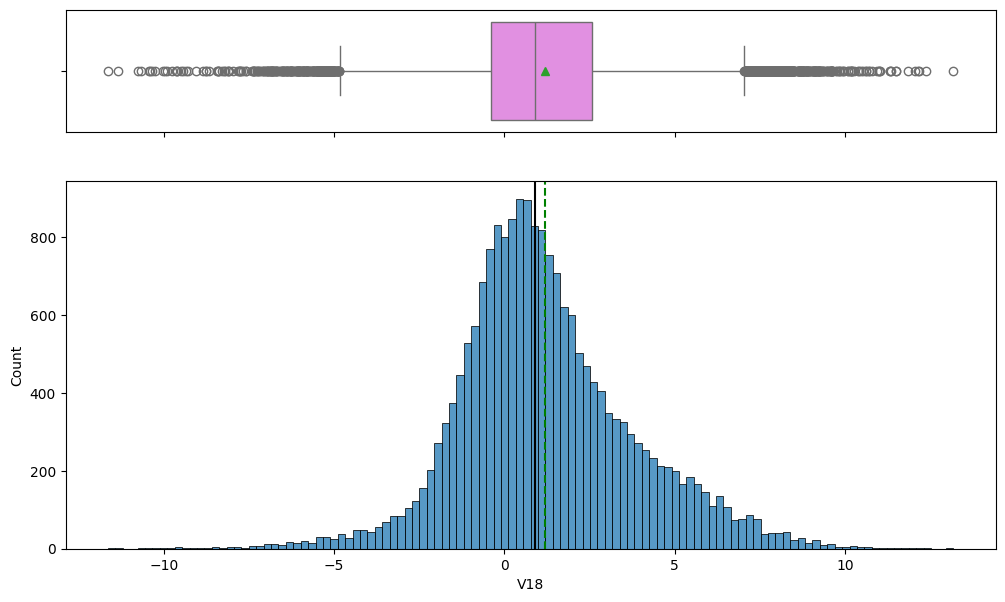

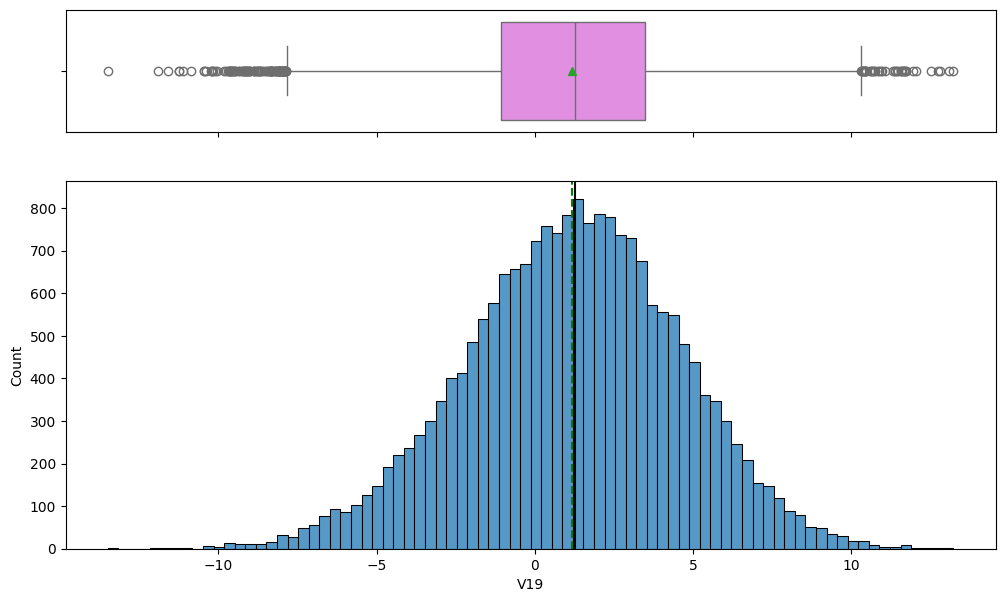

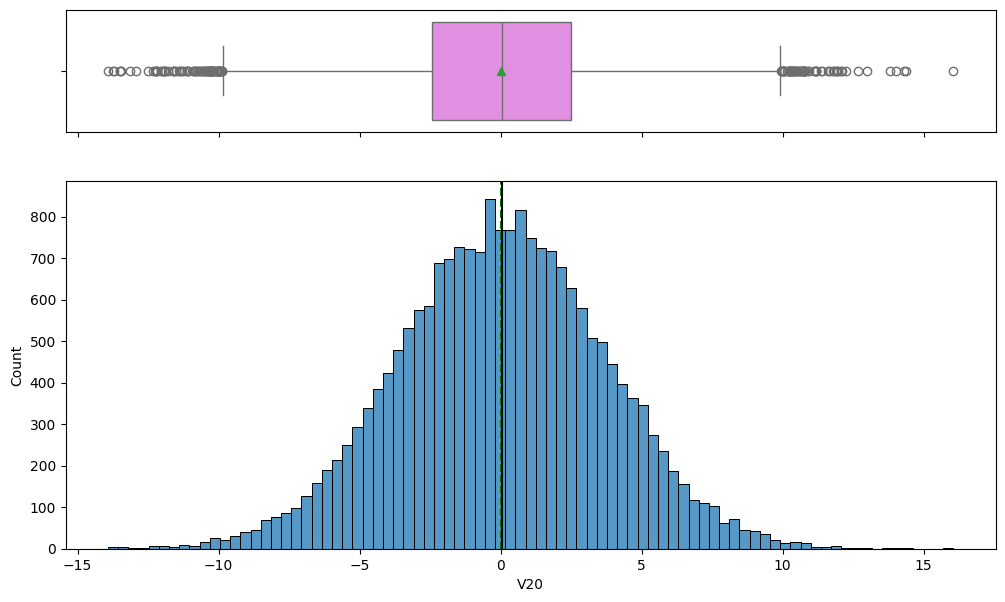

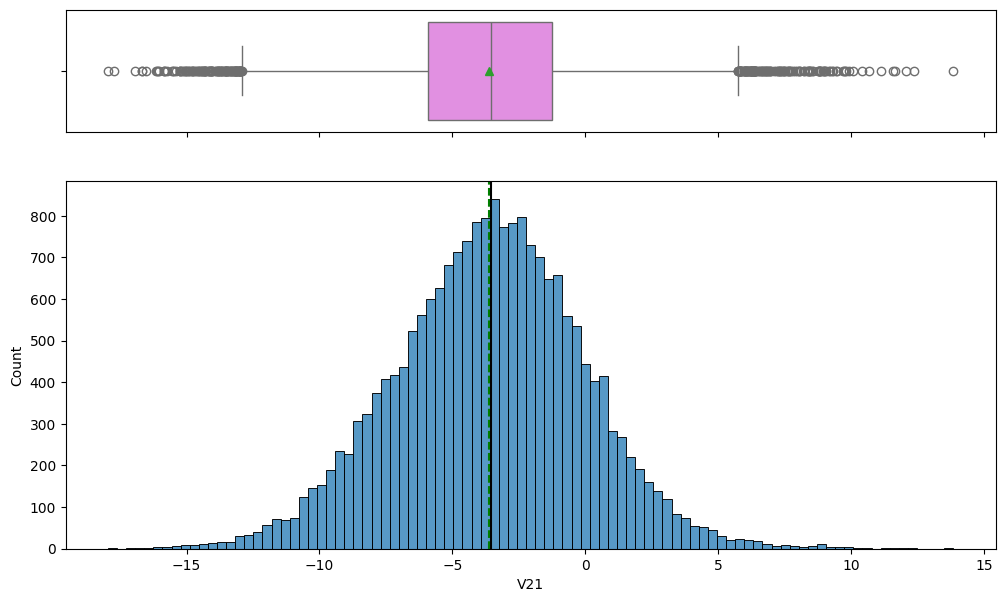

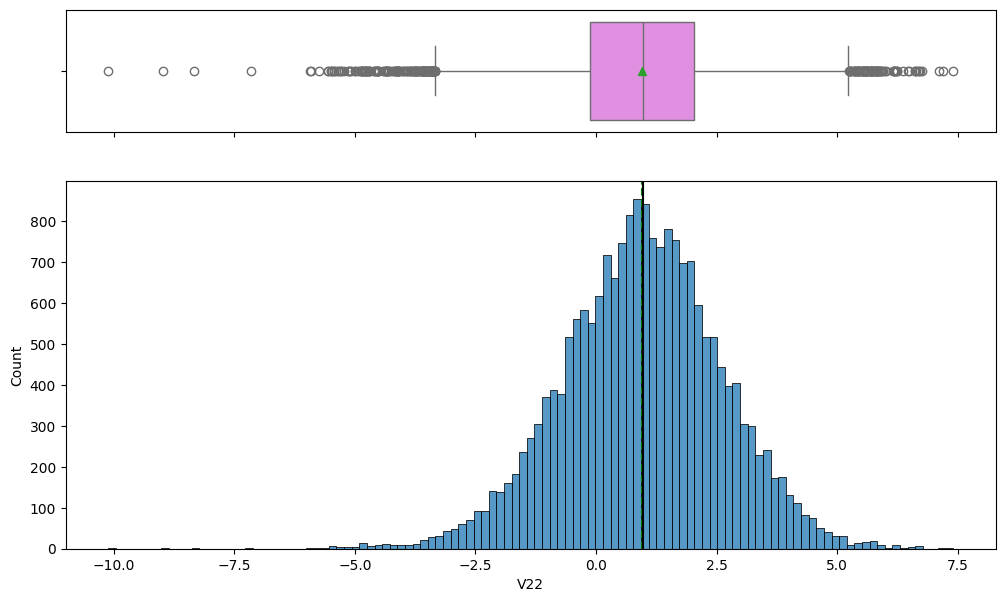

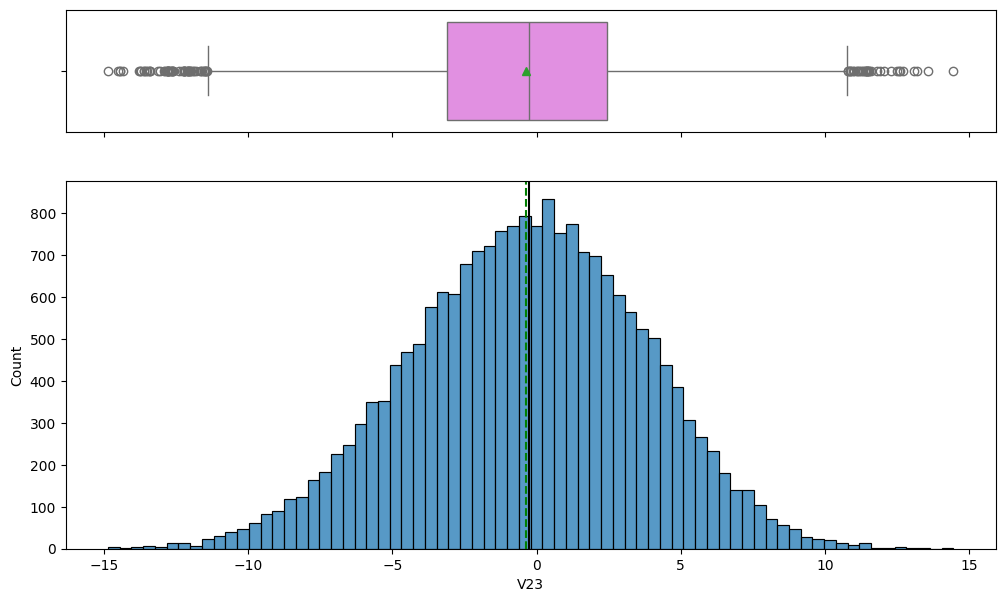

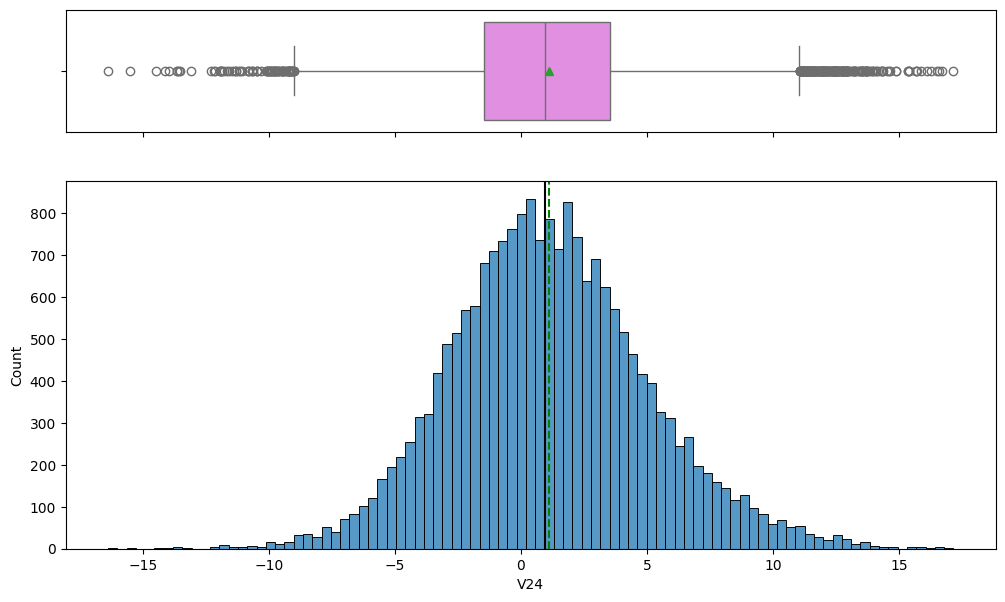

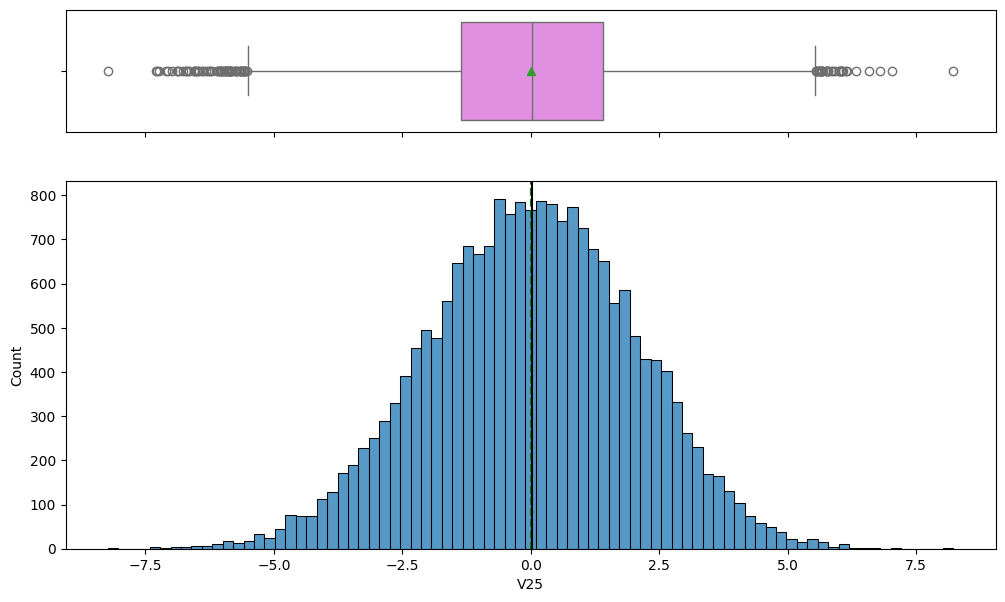

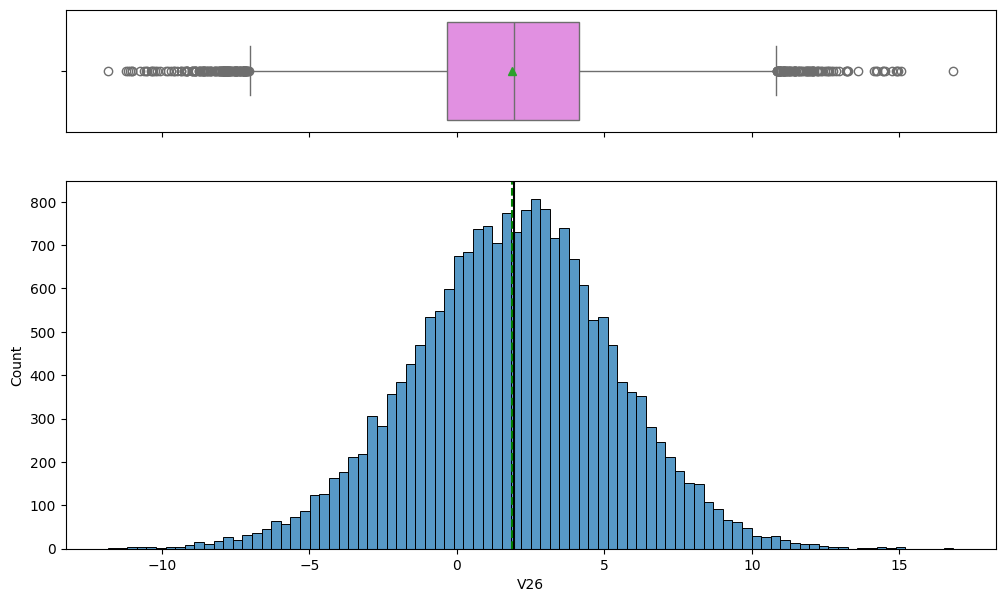

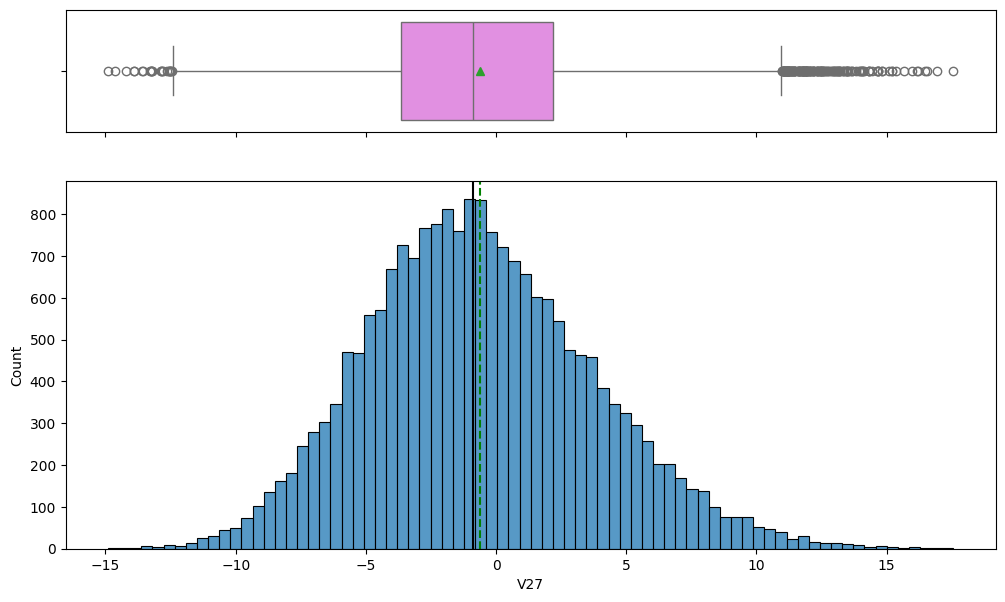

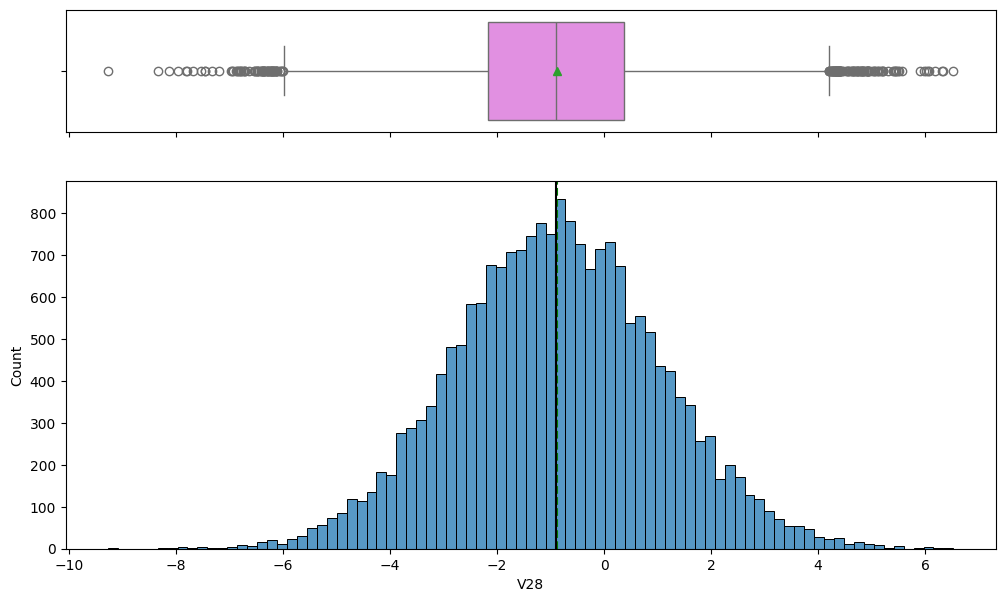

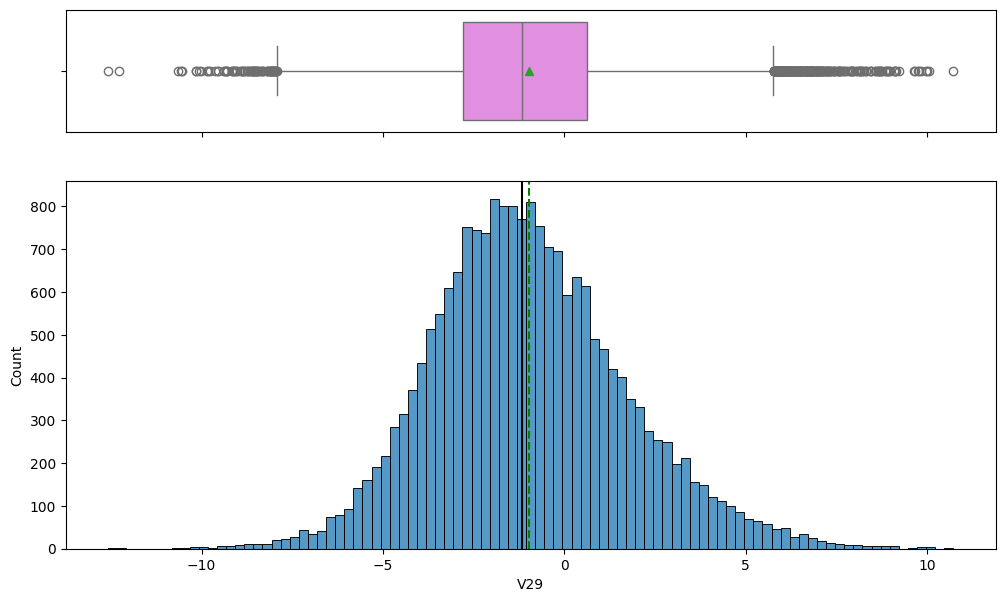

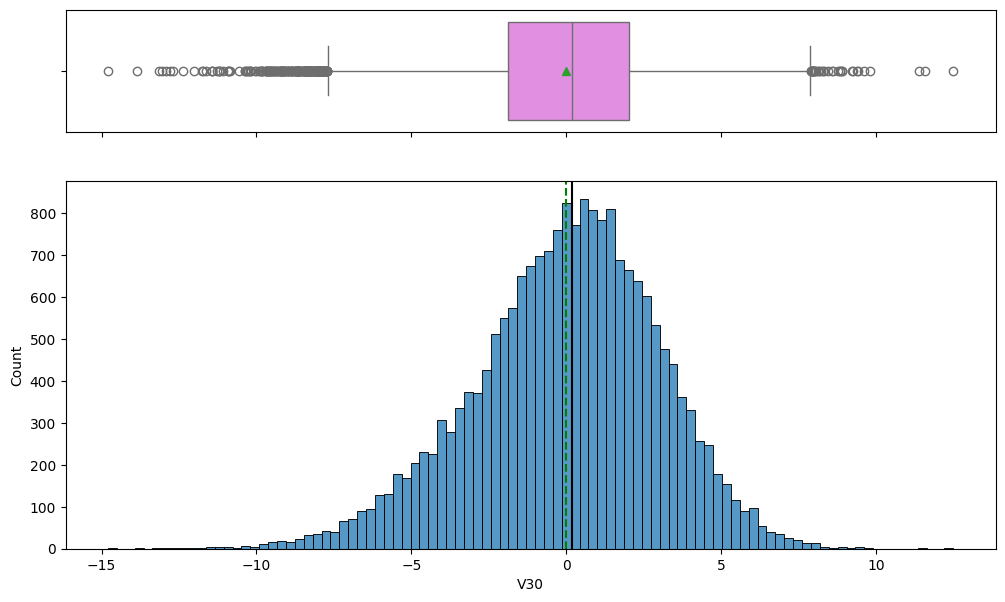

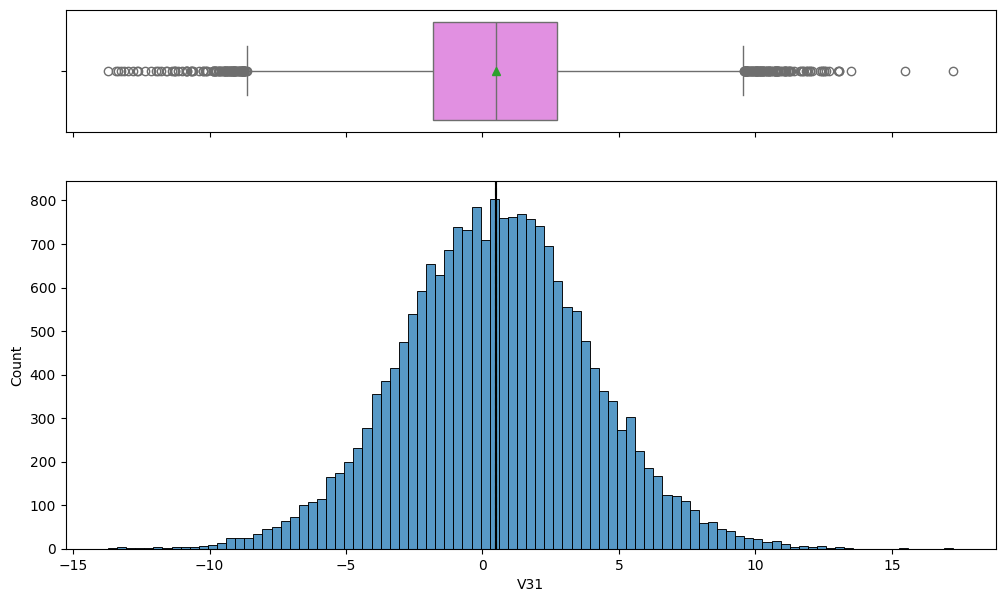

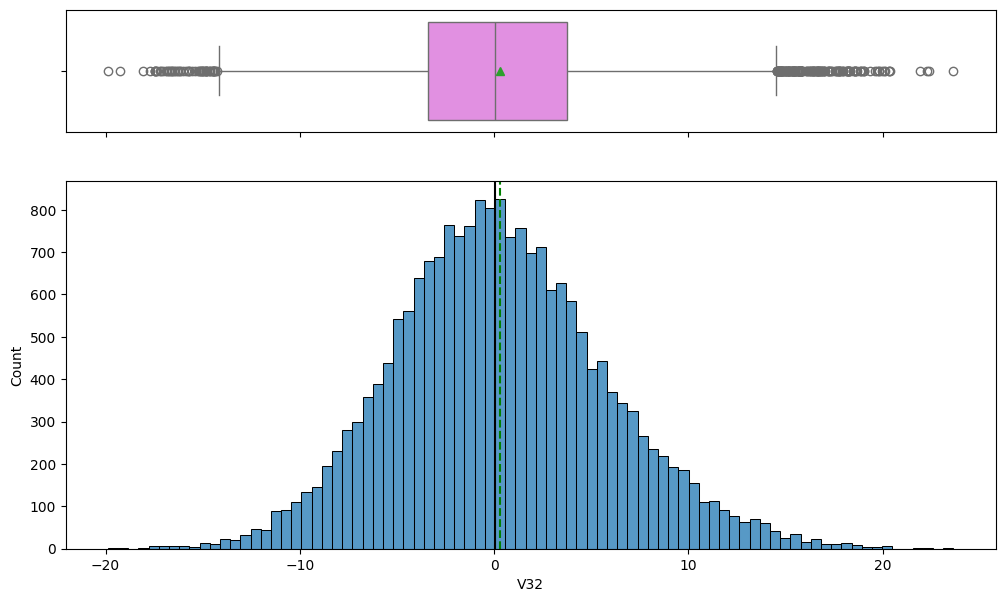

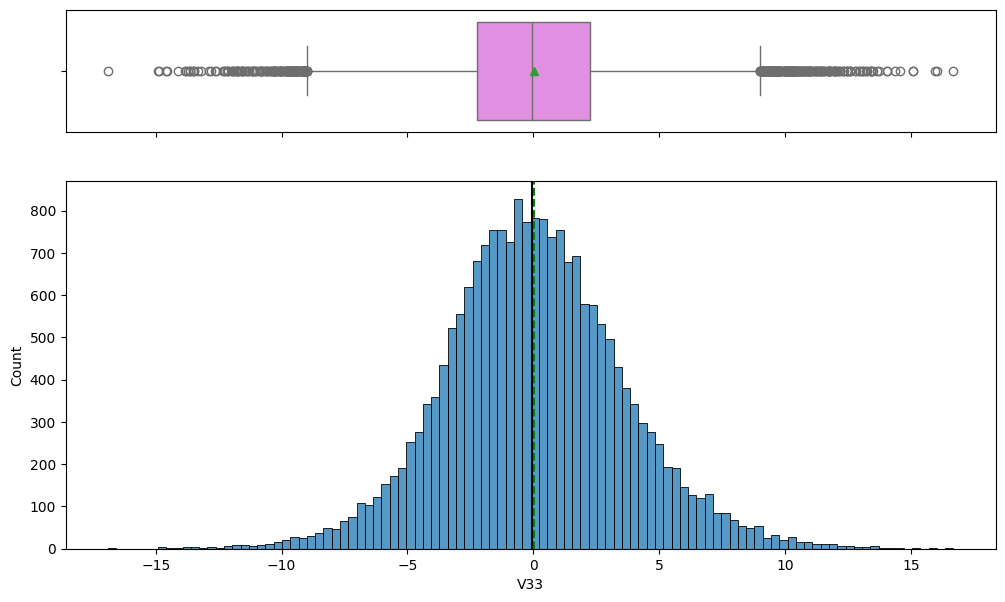

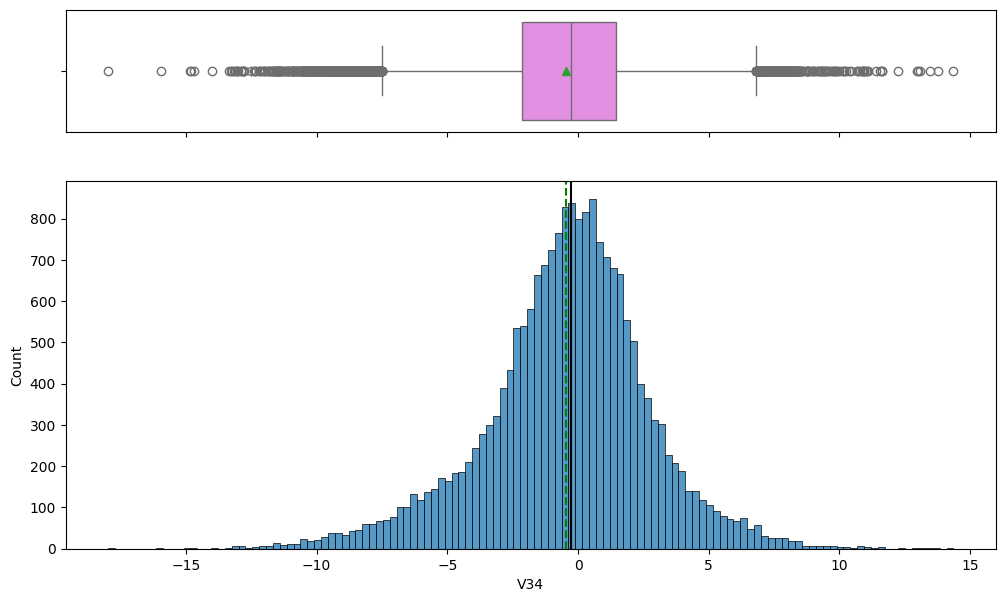

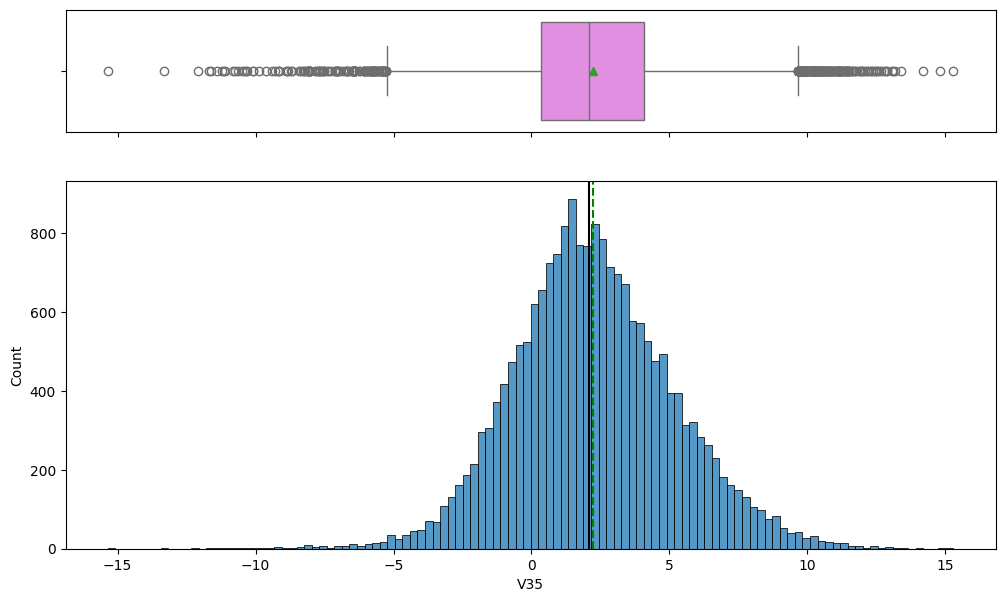

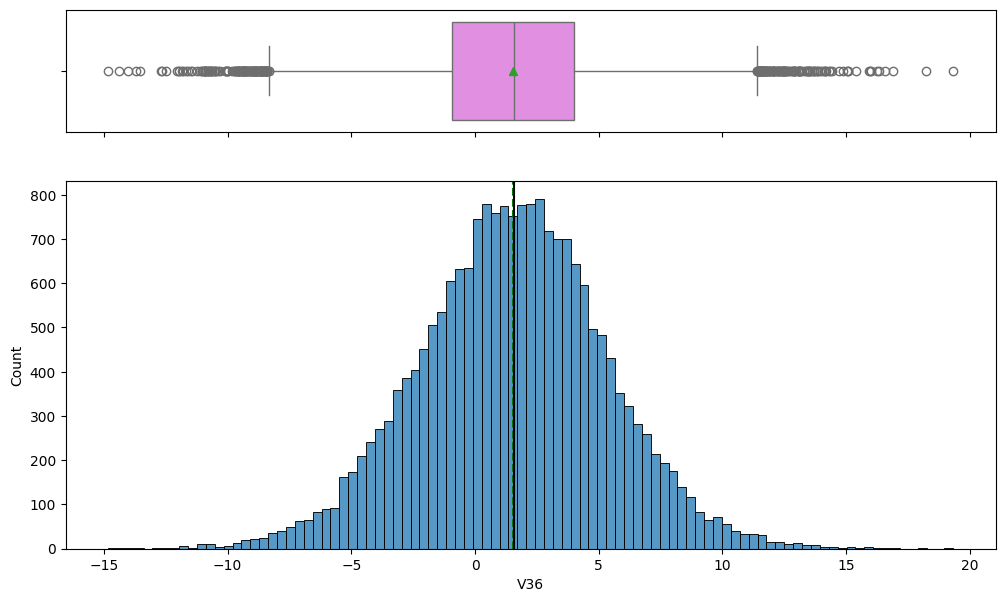

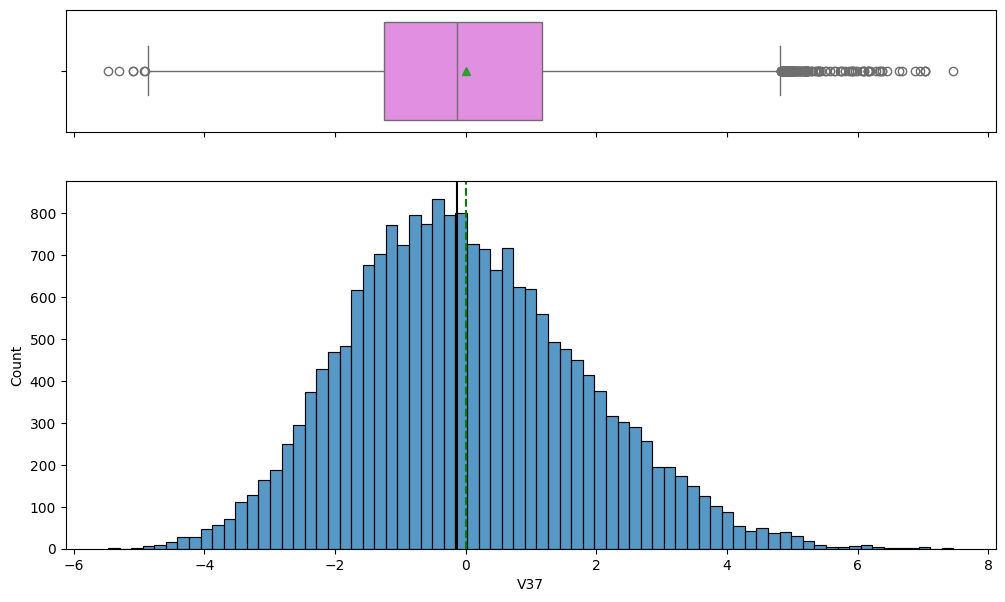

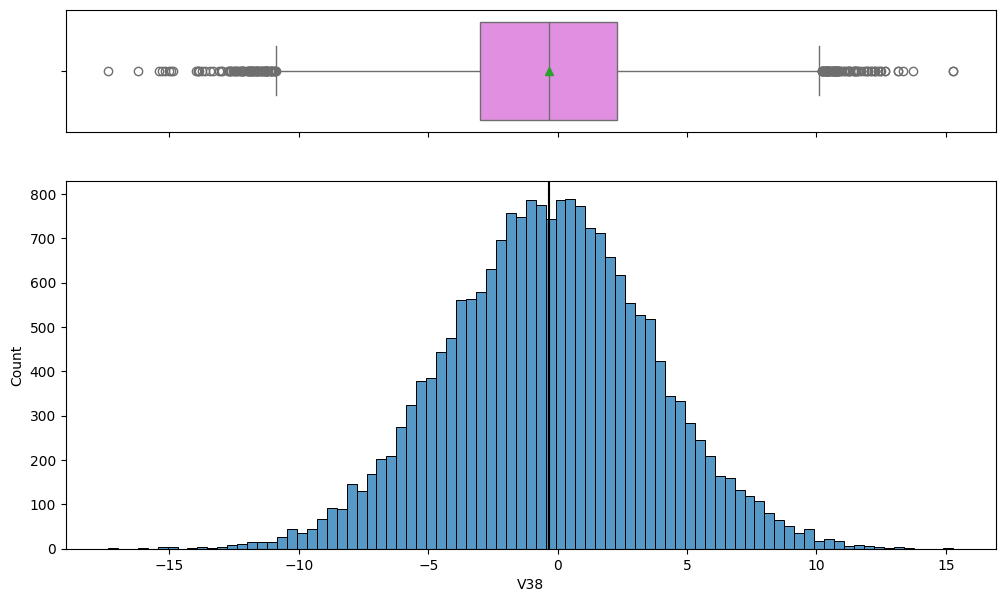

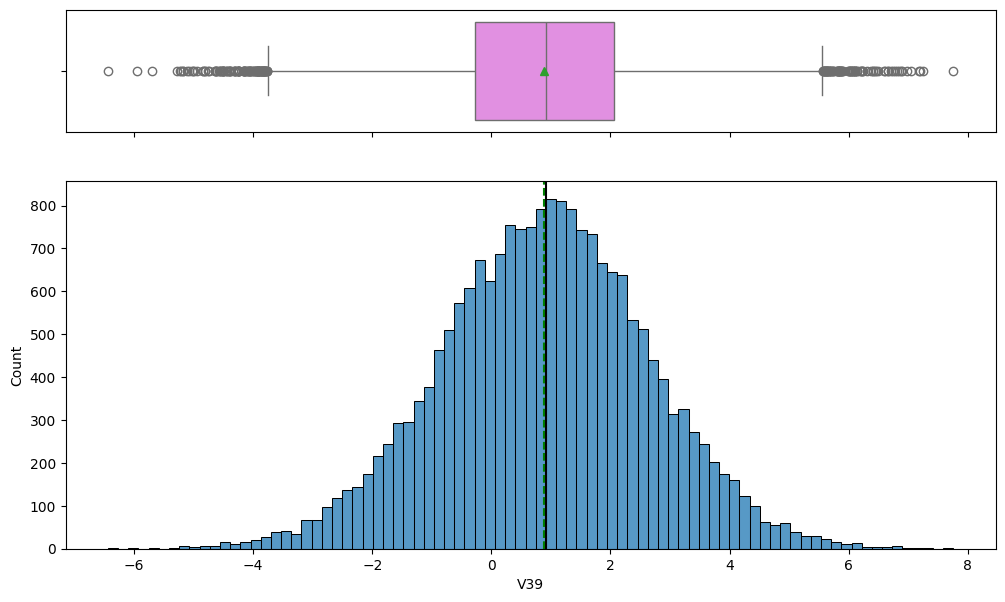

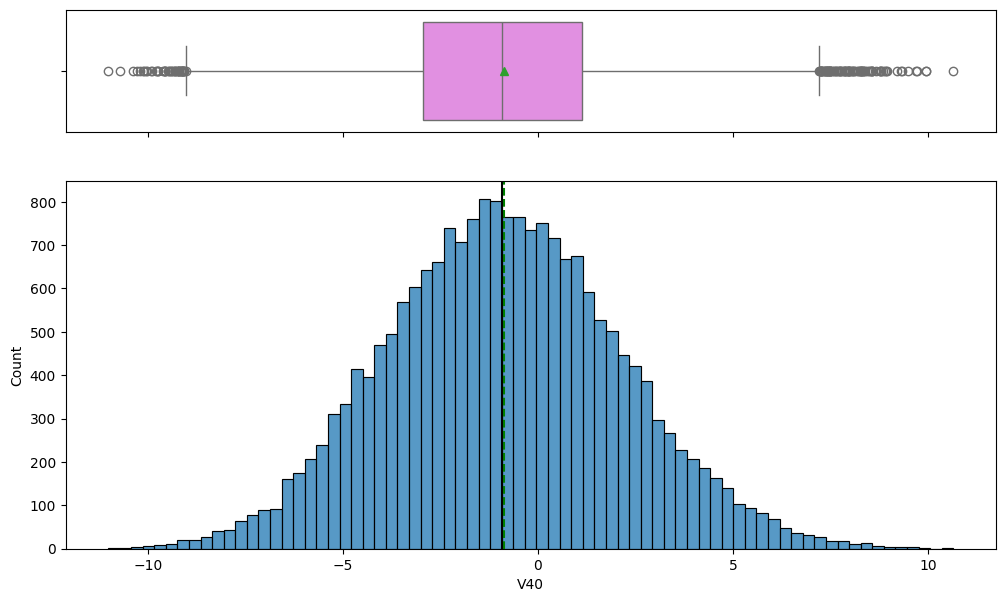

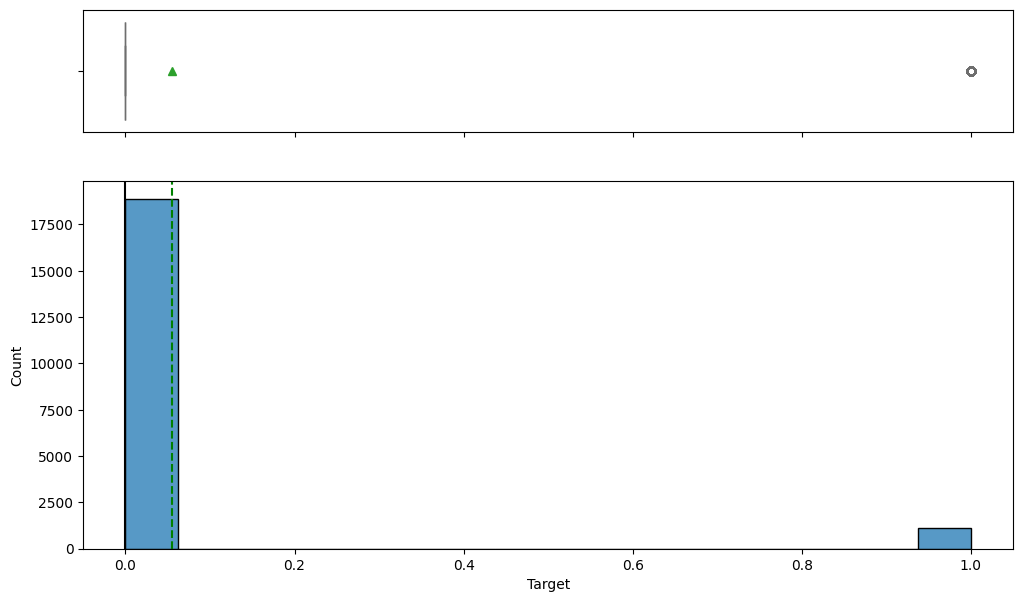

In [356]:
for feature in df.columns:
    histogram_boxplot(df, feature, figsize=(12, 7), kde=False, bins=None) ## Please change the dataframe name as you define while reading the data

In [357]:
# Checking the number of 'No Failure' vs 'Failure' ration
data['Target'].value_counts()

Target
0    18890
1     1110
Name: count, dtype: int64

Observations:

1. All the columns from V1 to V40 shows normal distribution

2. There are higher number of 'No Failures' than 'Failures'. In train data, total number of 'No failure' are 18890 and 'Failure' are 1110 which means there could be class imbalance in predicting data

In [358]:
# function to plot a boxplot and a histogram along the same scale for test data


def histogram_boxplot(data, feature, figsize=(12, 7), kde=False, bins=None):
    """
    Boxplot and histogram combined

    data: dataframe
    feature: dataframe column
    figsize: size of figure (default (12,7))
    kde: whether to the show density curve (default False)
    bins: number of bins for histogram (default None)
    """
    f2, (ax_box2, ax_hist2) = plt.subplots(
        nrows=2,  # Number of rows of the subplot grid= 2
        sharex=True,  # x-axis will be shared among all subplots
        gridspec_kw={"height_ratios": (0.25, 0.75)},
        figsize=figsize,
    )  # creating the 2 subplots
    sns.boxplot(
        data=data_test, x=feature, ax=ax_box2, showmeans=True, color="violet"
    )  # boxplot will be created and a star will indicate the mean value of the column
    sns.histplot(
        data=data_test, x=feature, kde=kde, ax=ax_hist2, bins=bins, palette="winter"
    ) if bins else sns.histplot(
        data=data_test, x=feature, kde=kde, ax=ax_hist2
    )  # For histogram
    ax_hist2.axvline(
        data[feature].mean(), color="green", linestyle="--"
    )  # Add mean to the histogram
    ax_hist2.axvline(
        data[feature].median(), color="black", linestyle="-"
    )  # Add median to the histogram

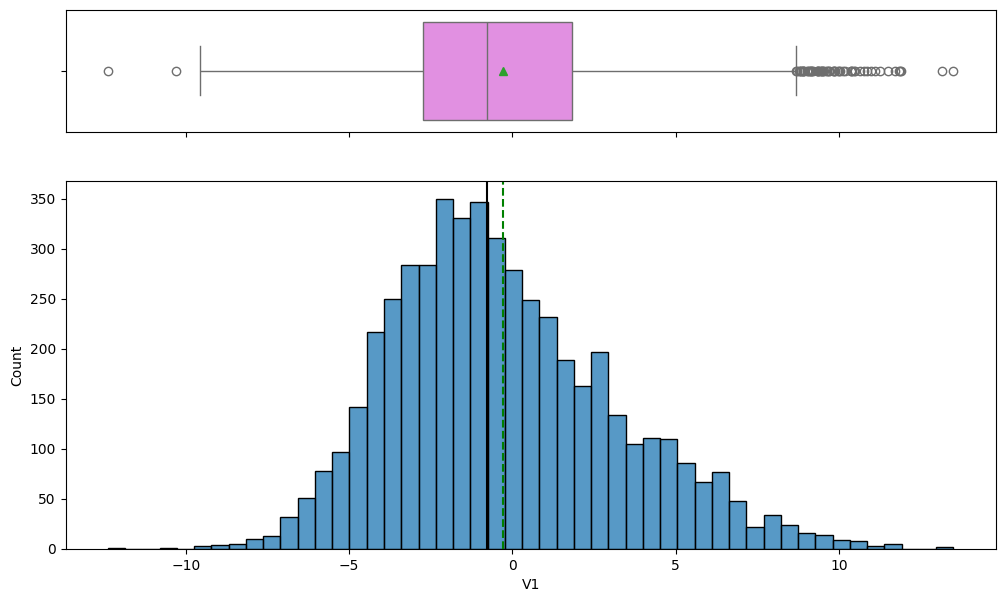

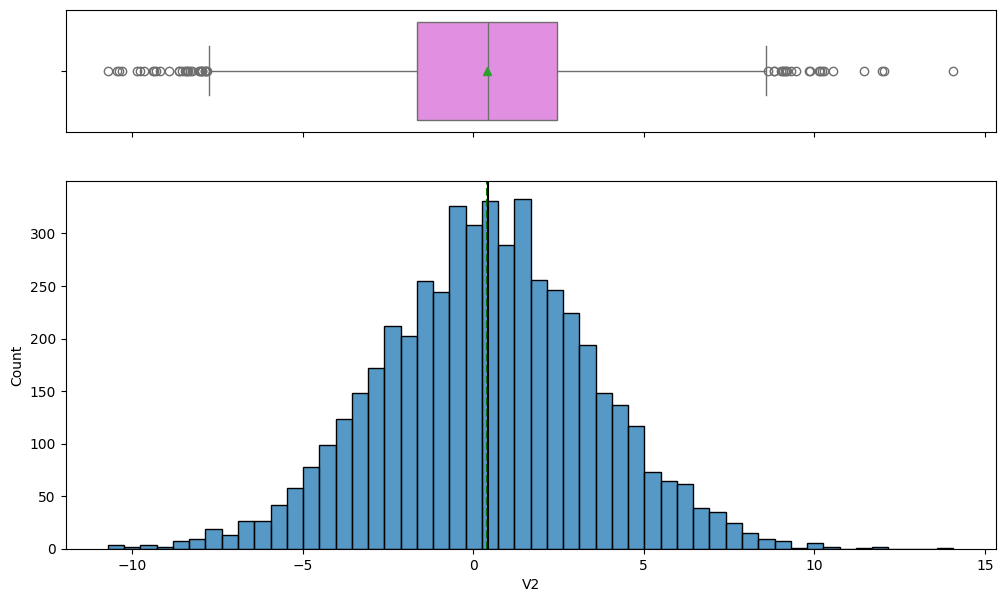

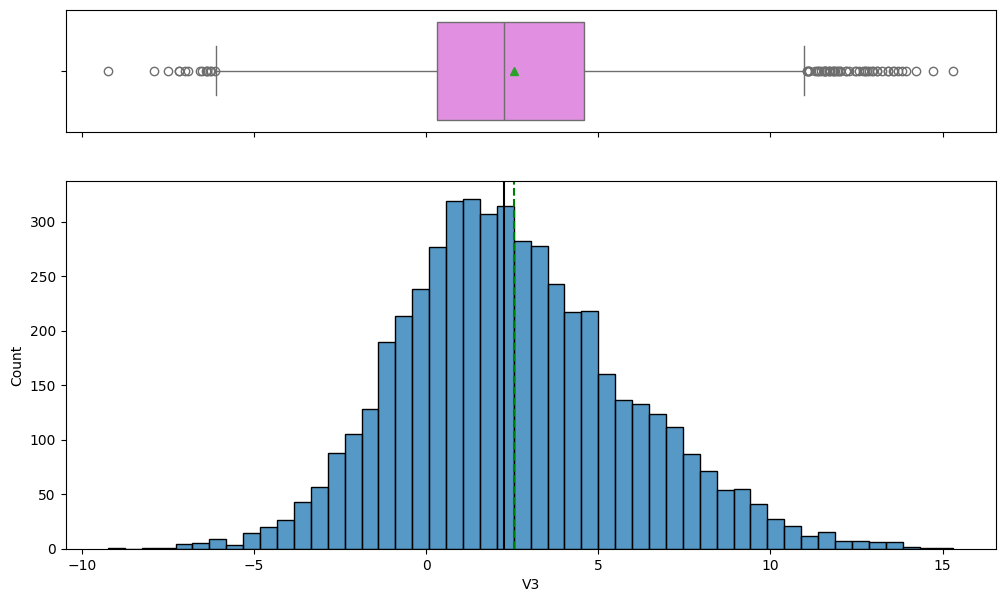

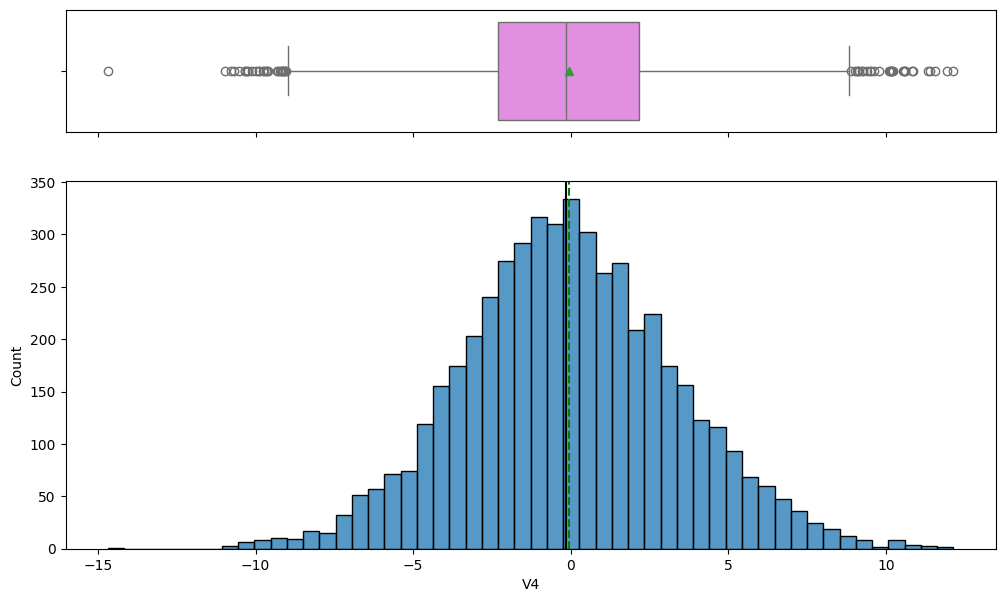

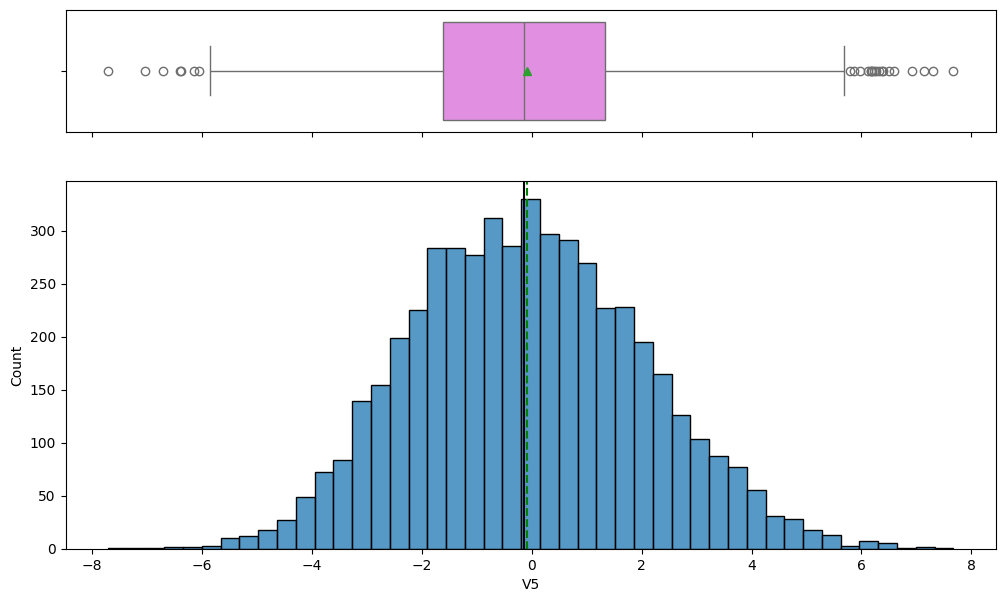

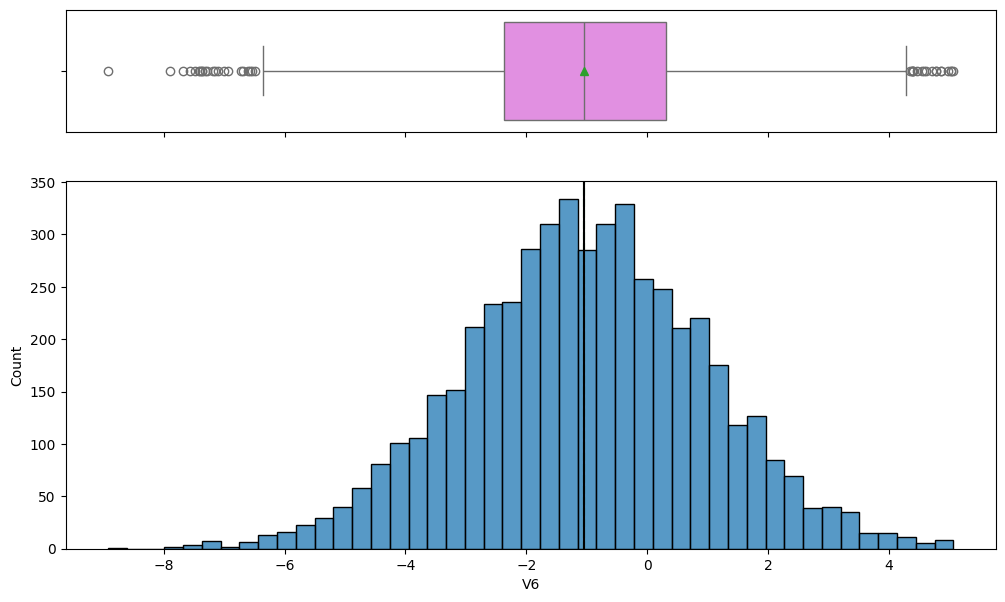

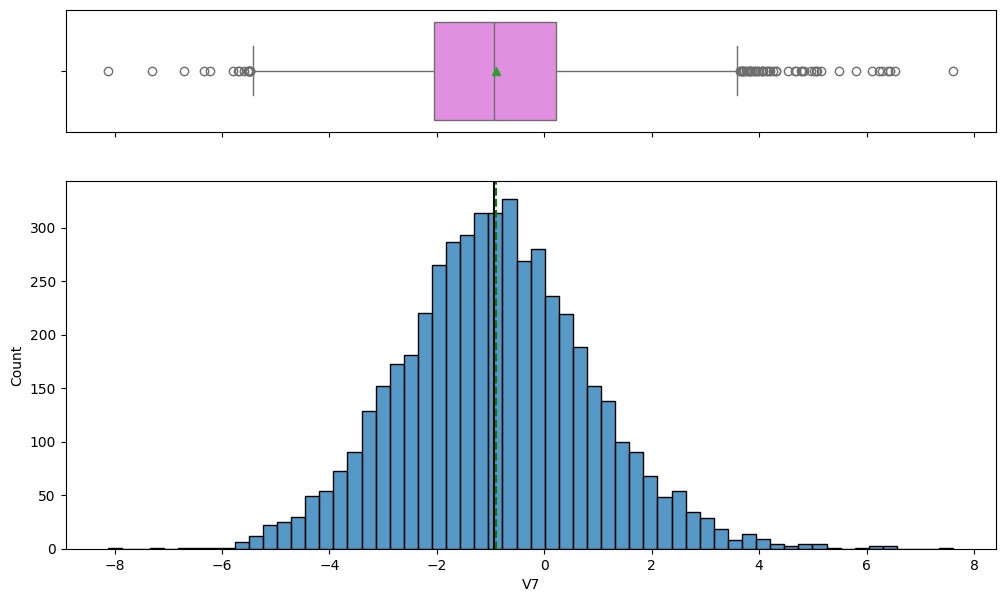

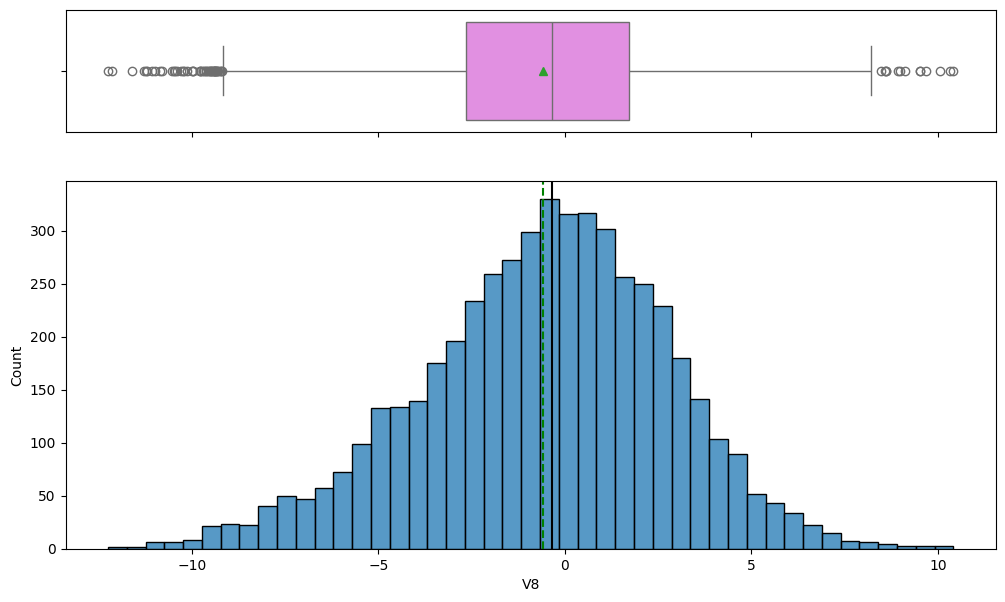

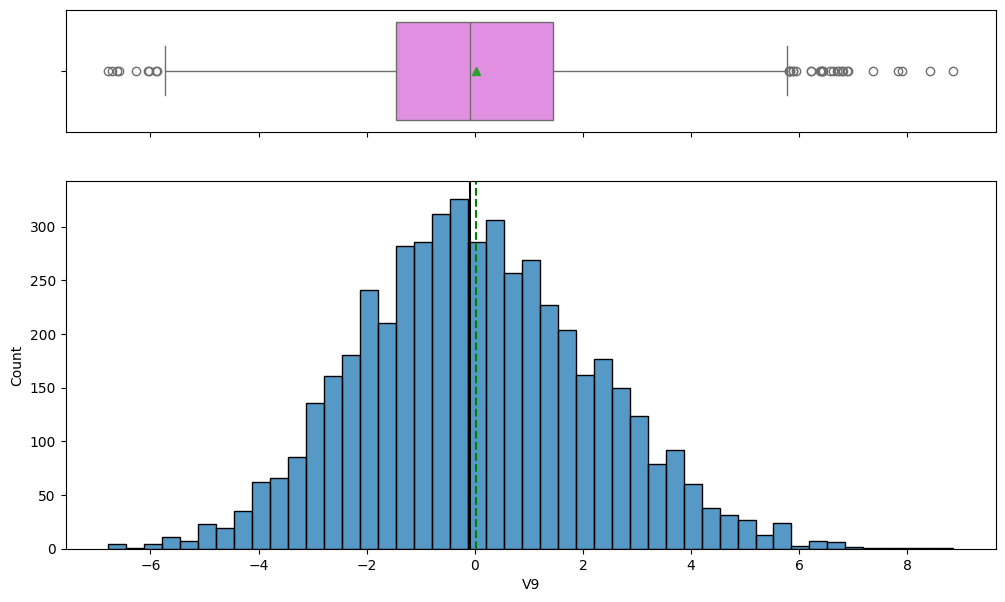

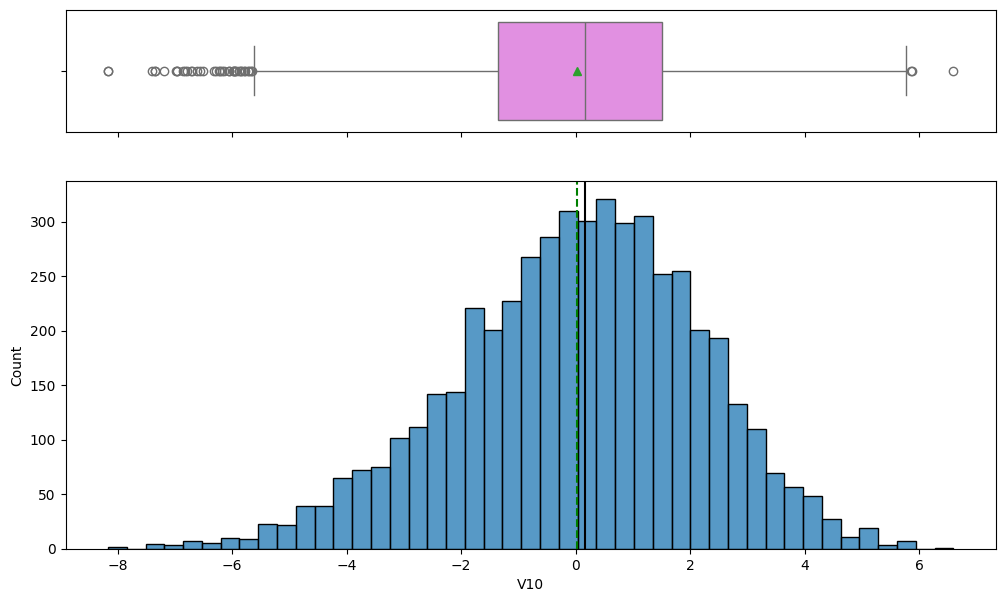

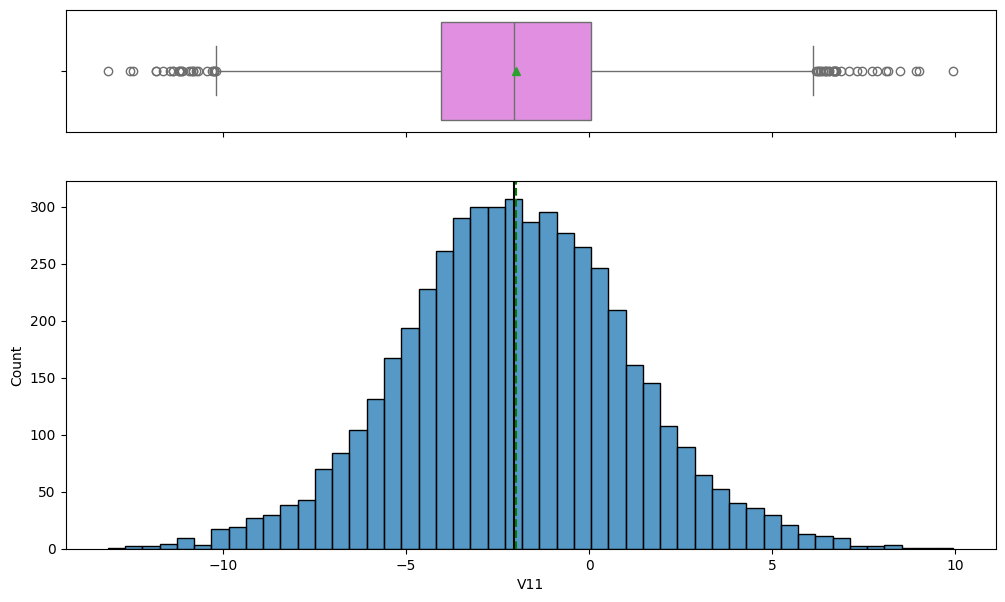

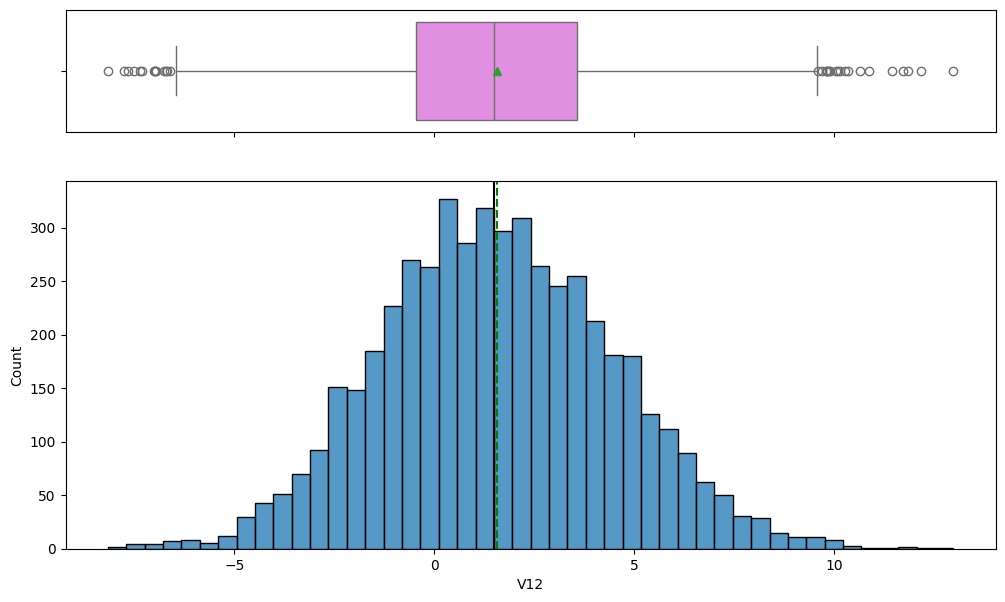

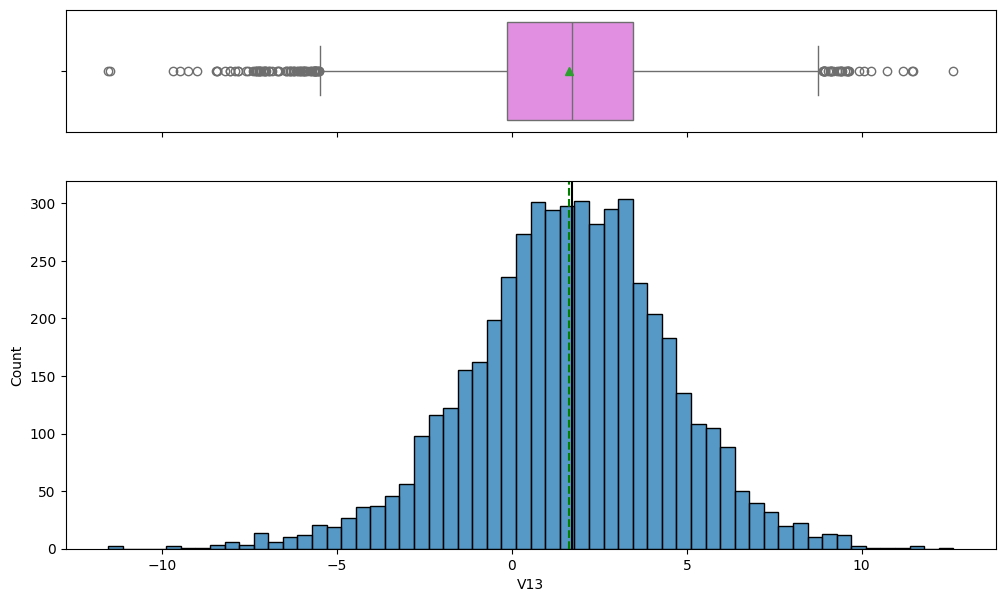

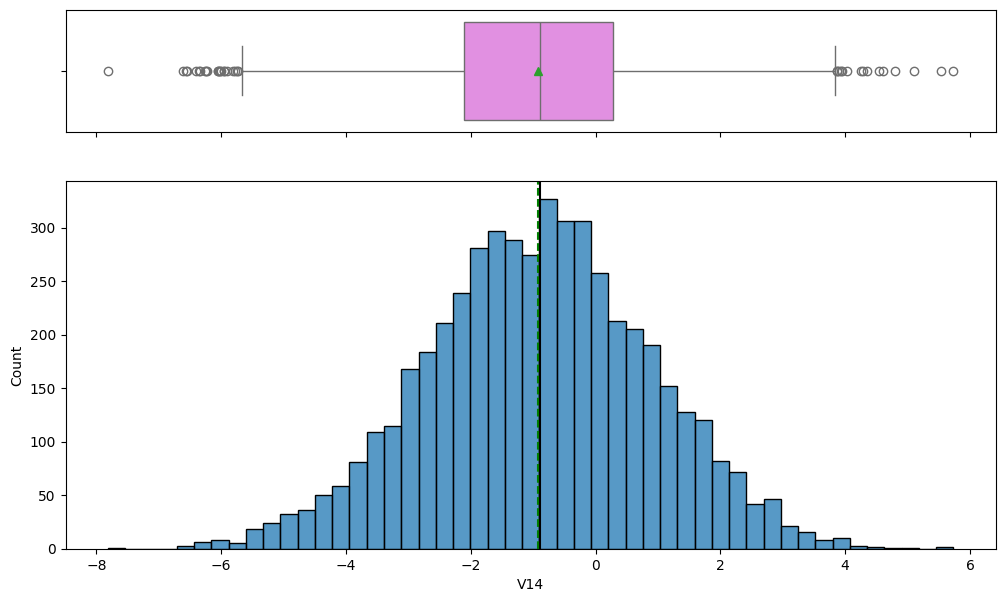

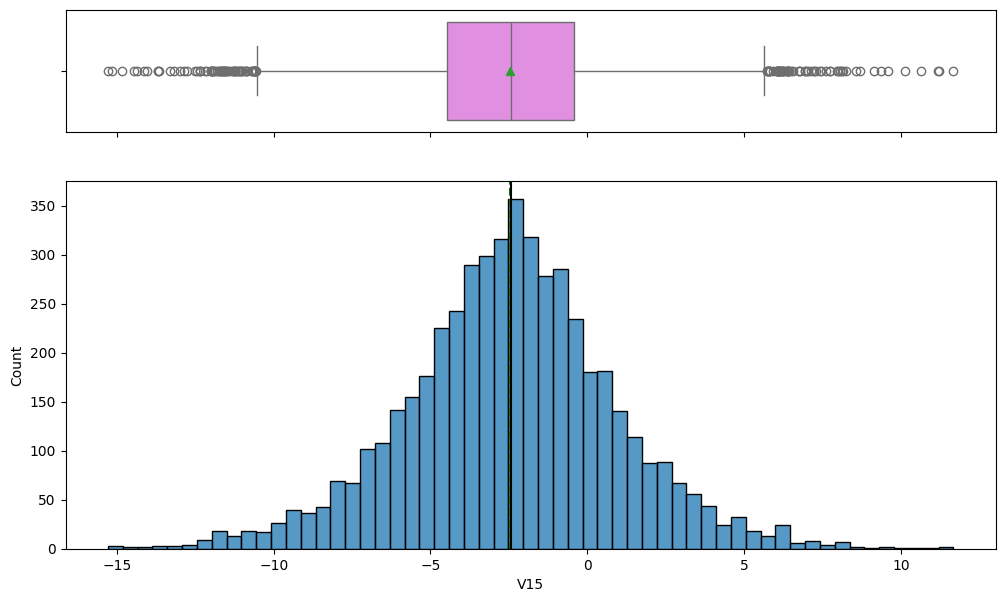

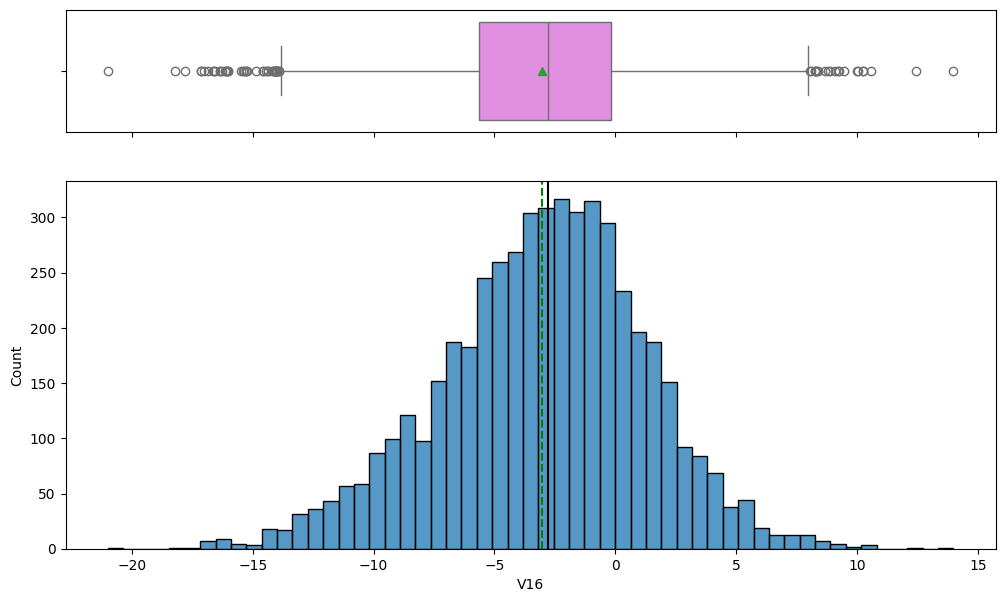

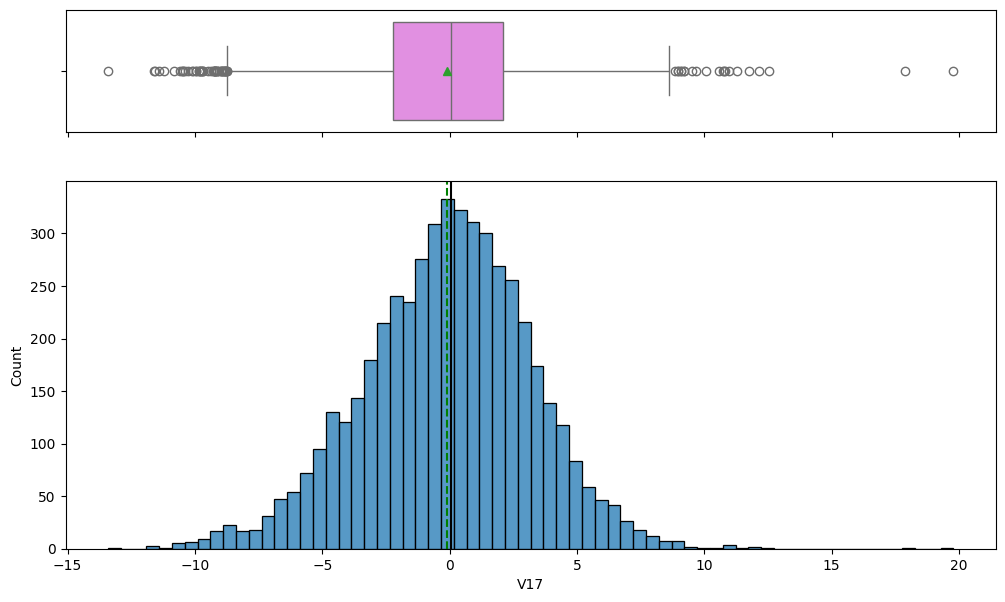

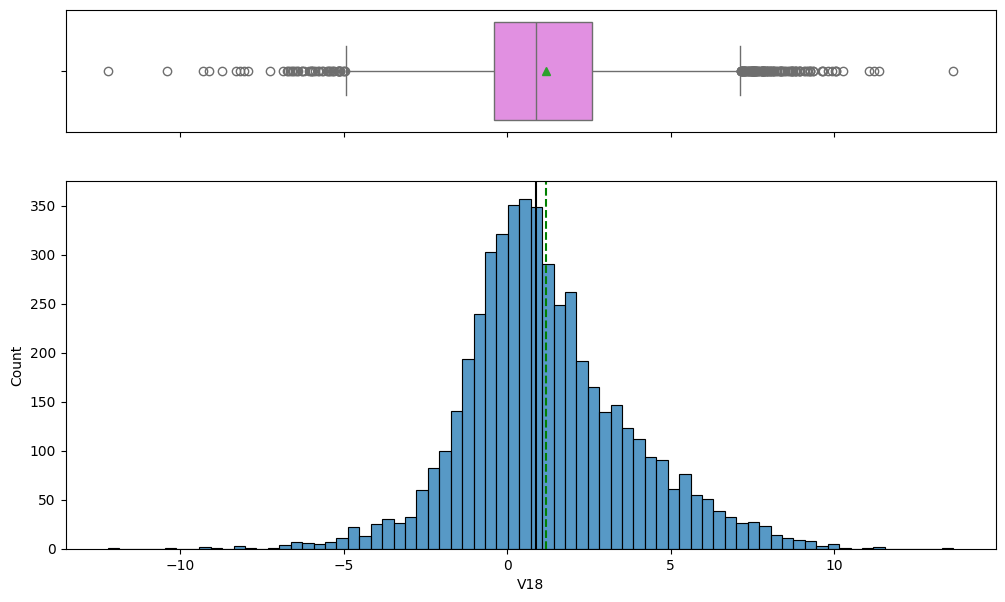

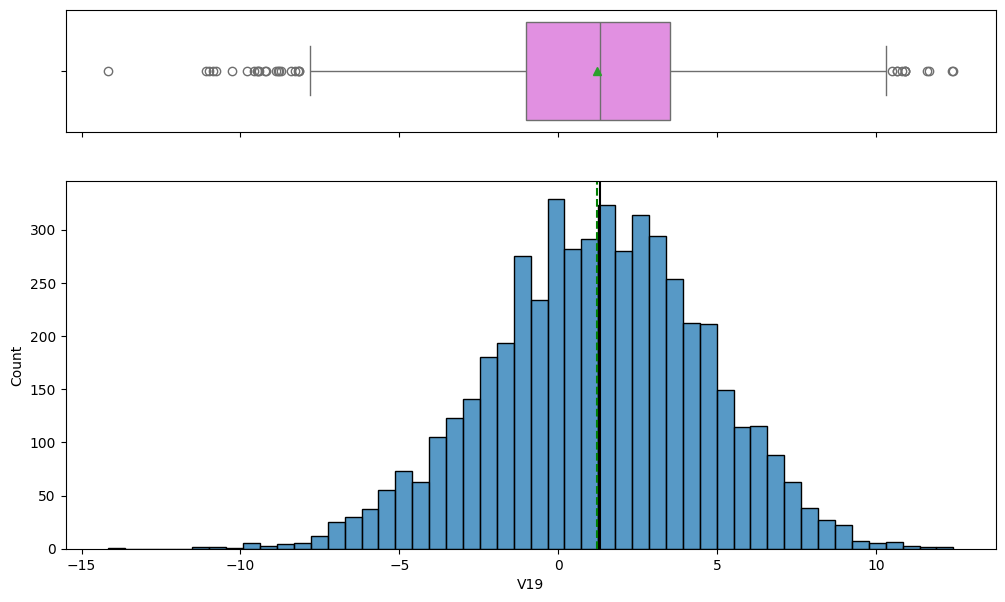

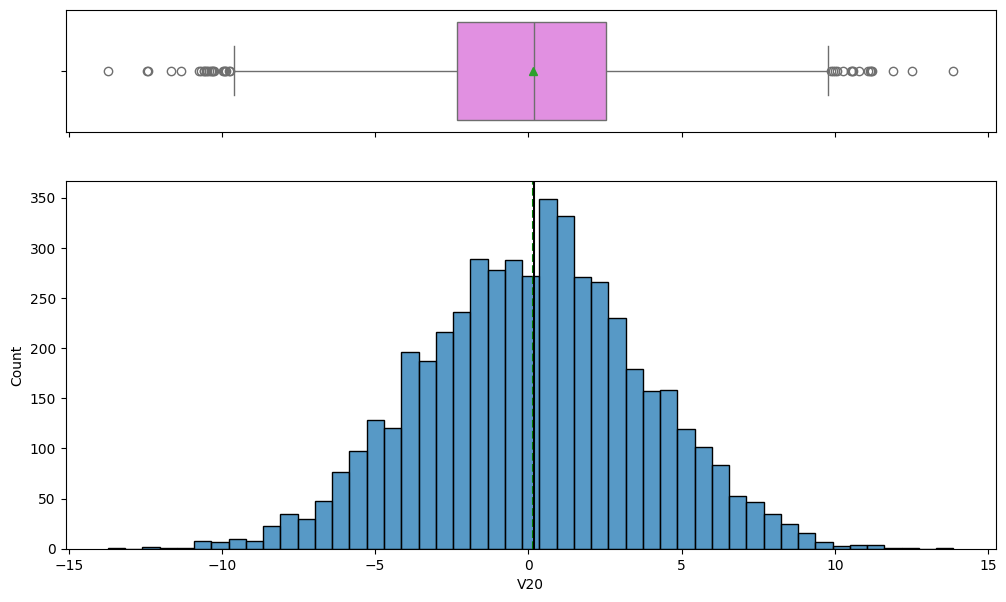

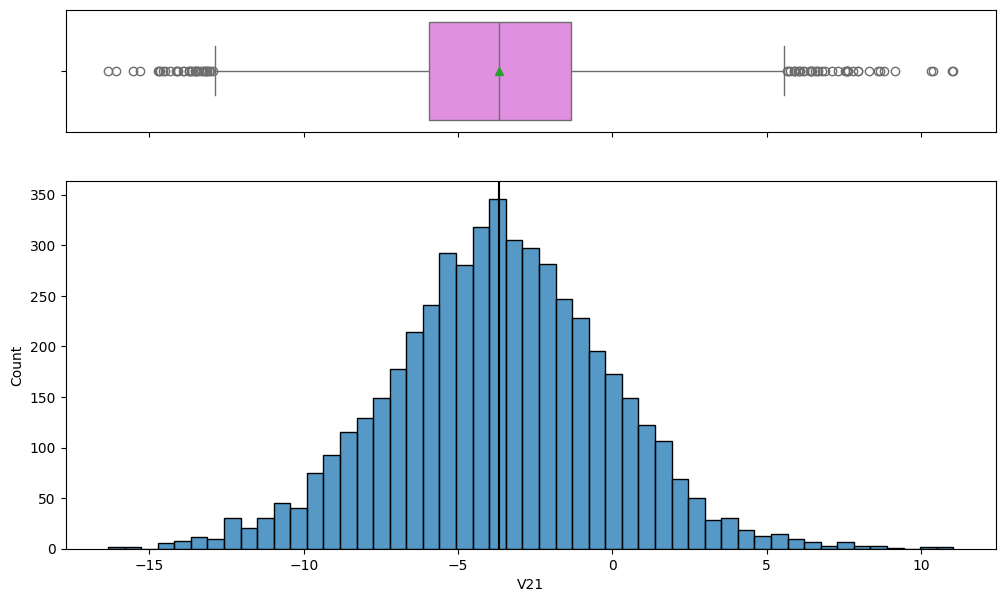

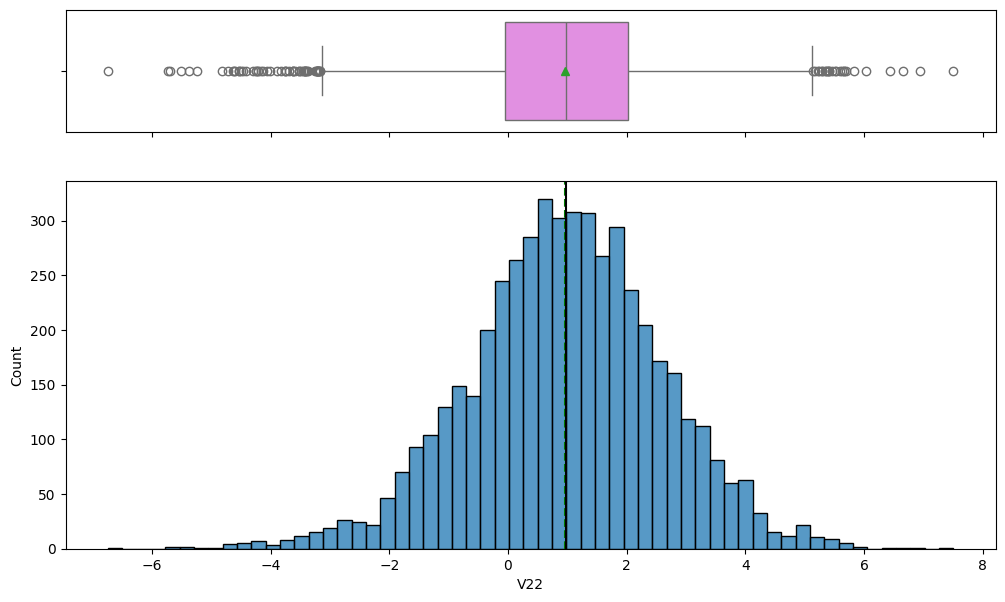

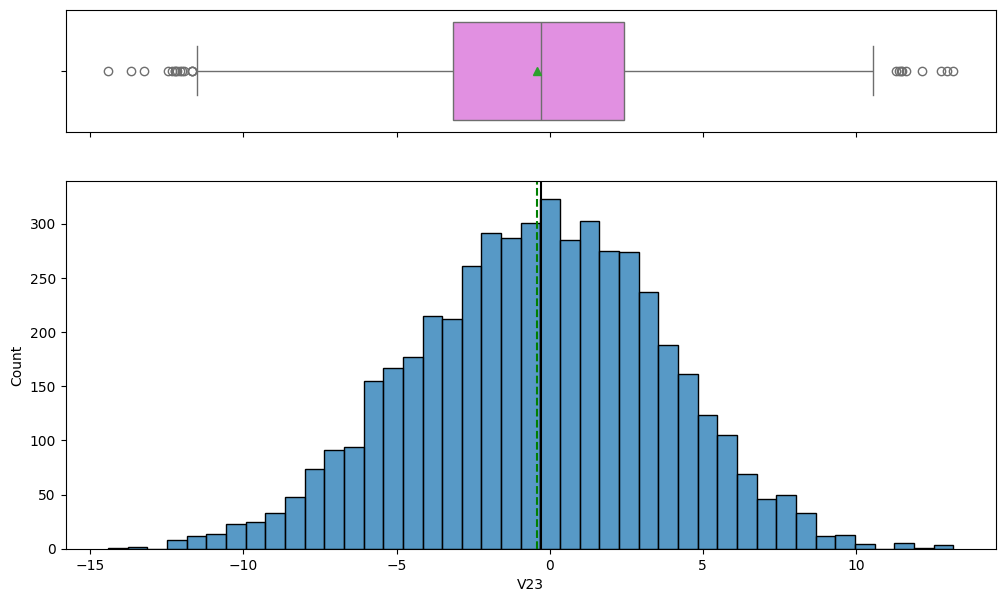

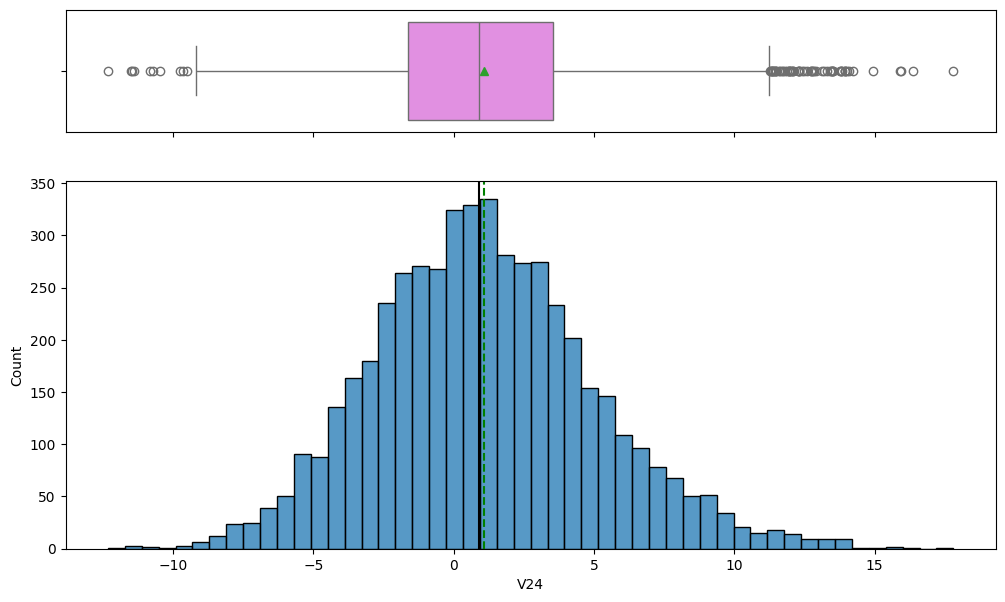

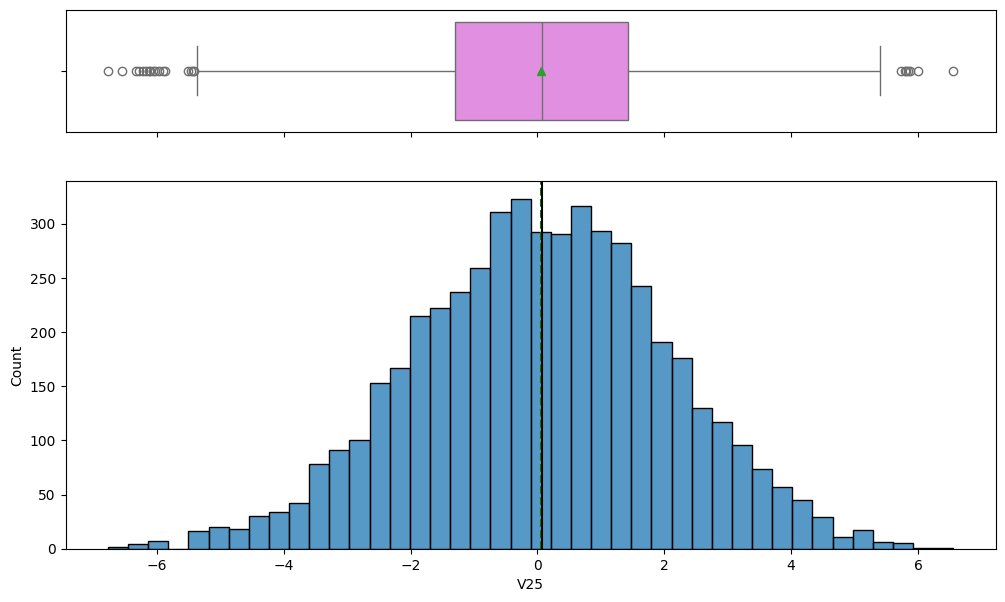

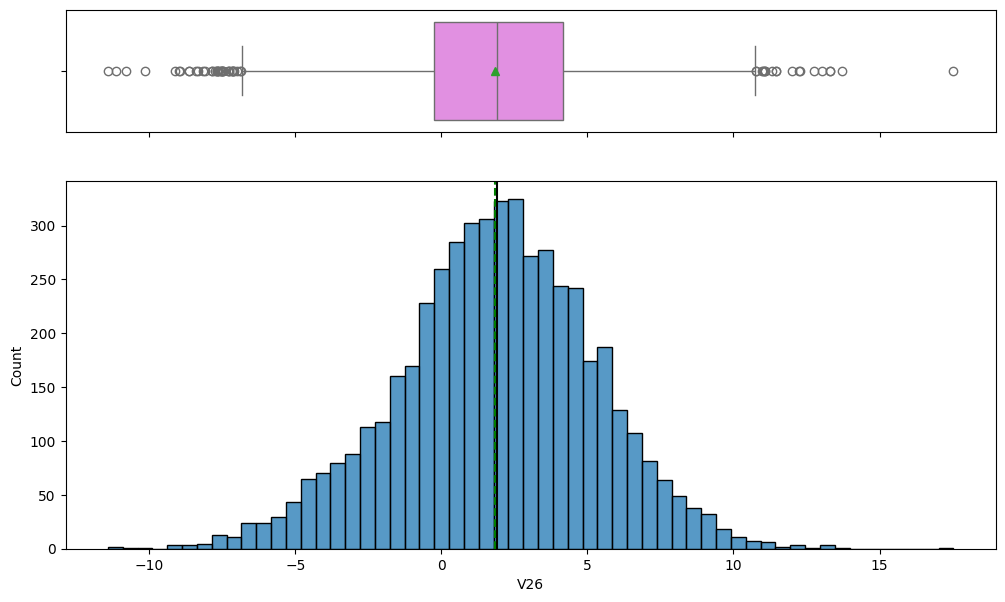

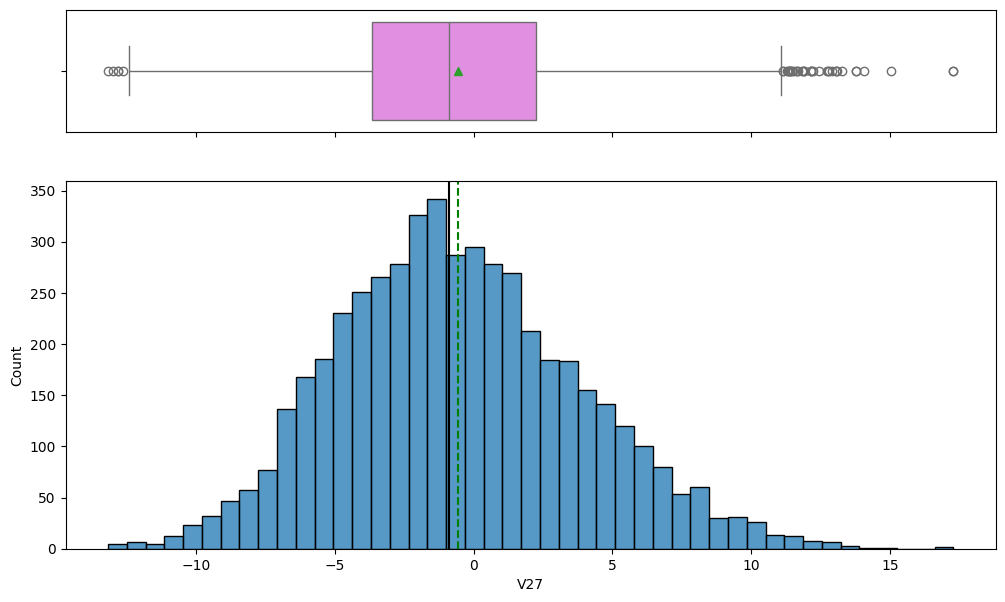

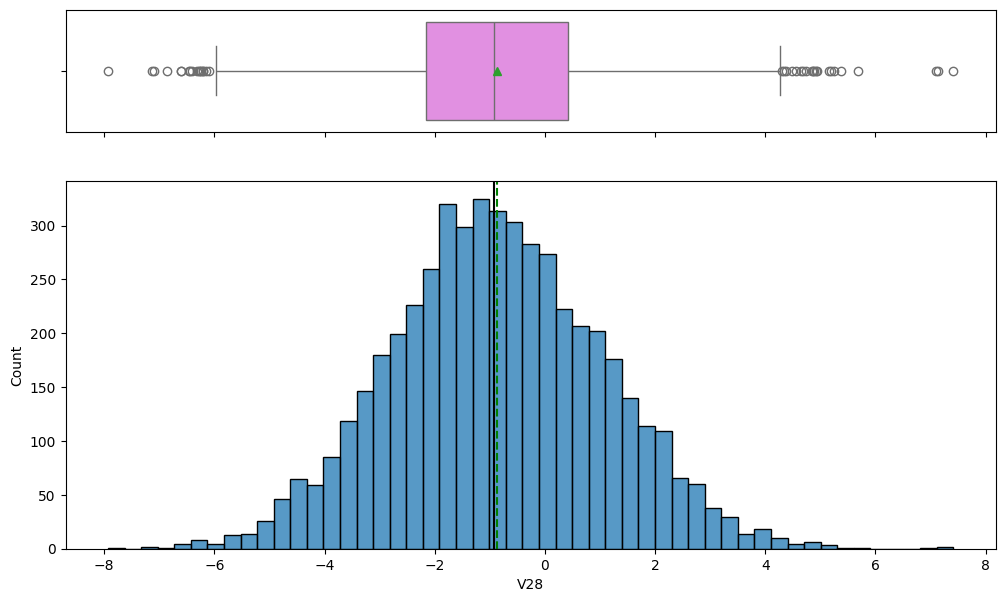

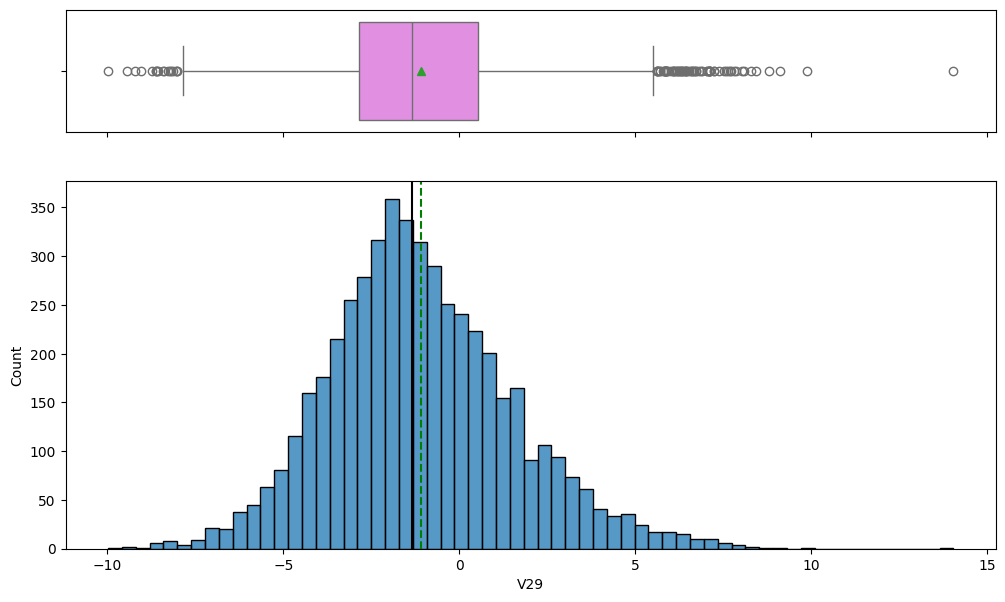

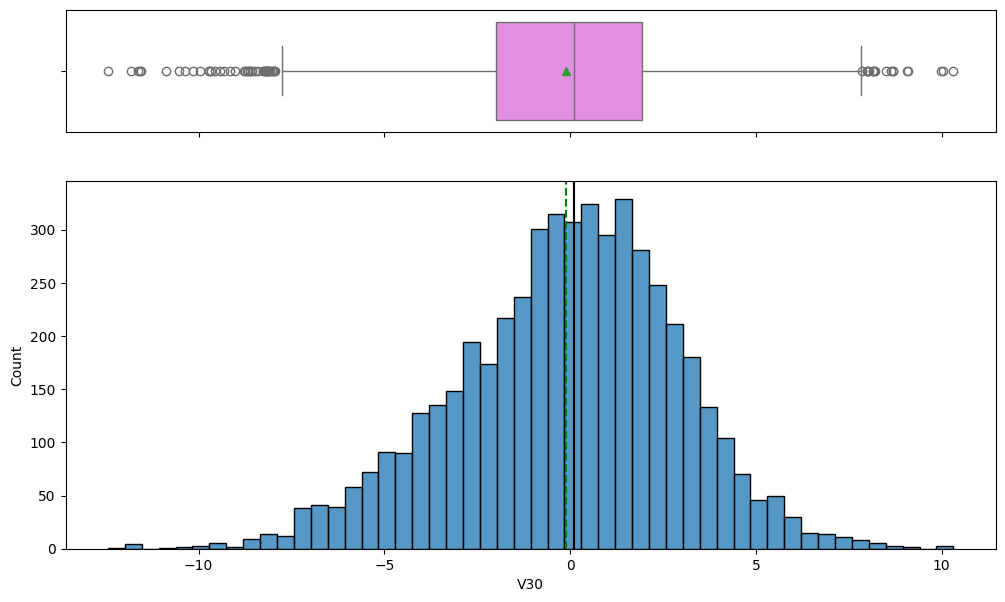

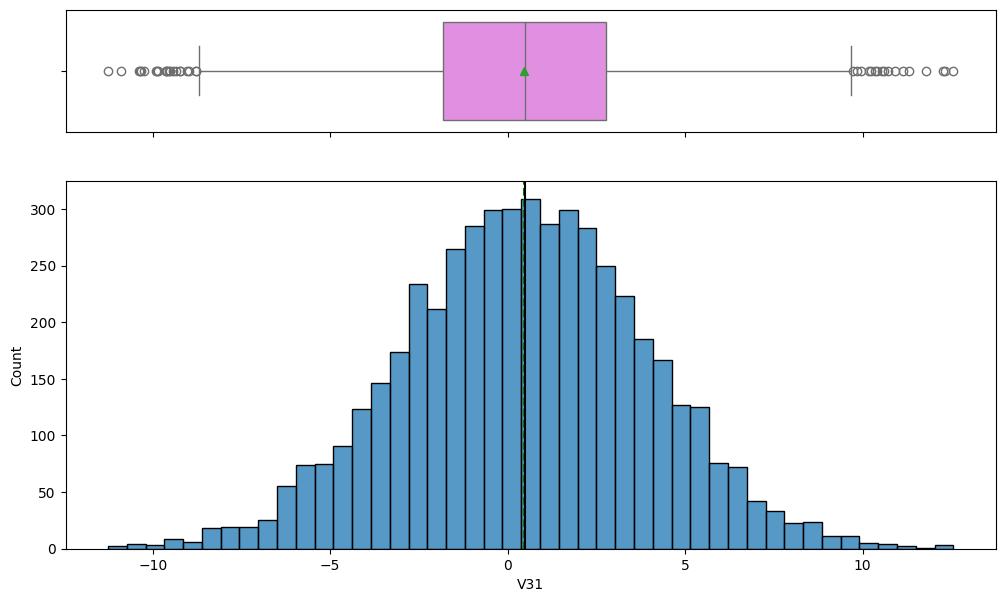

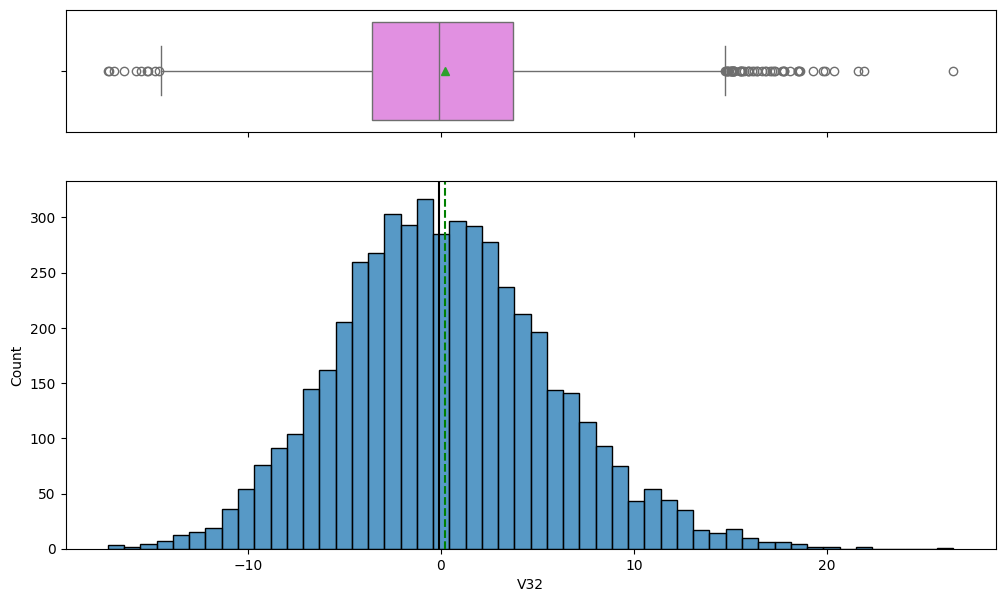

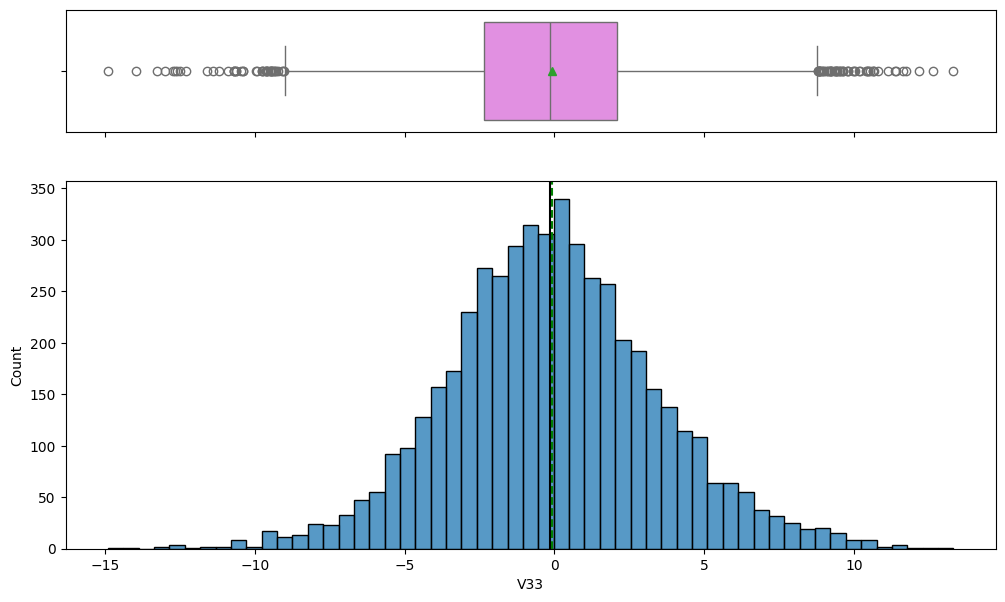

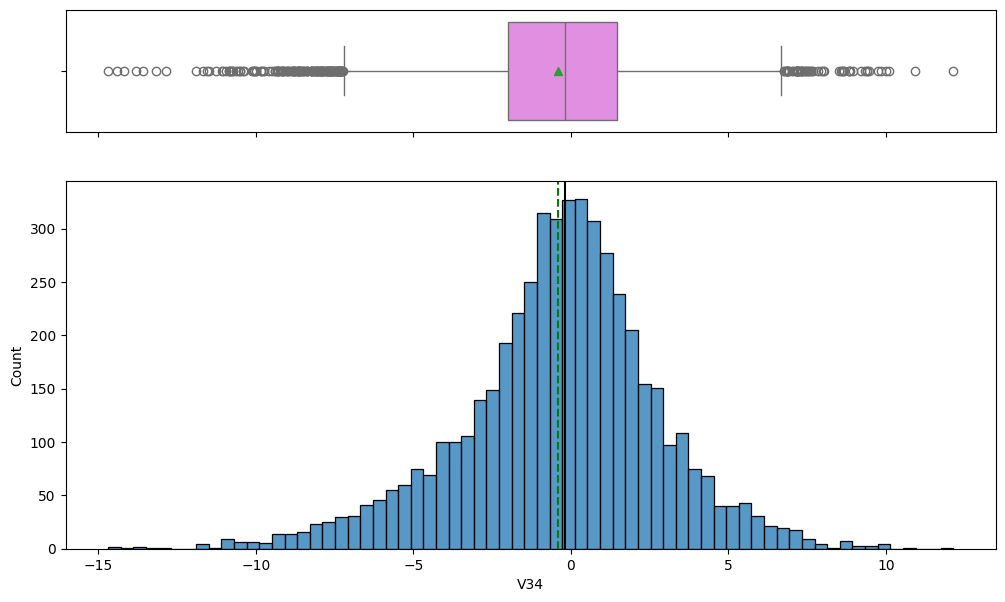

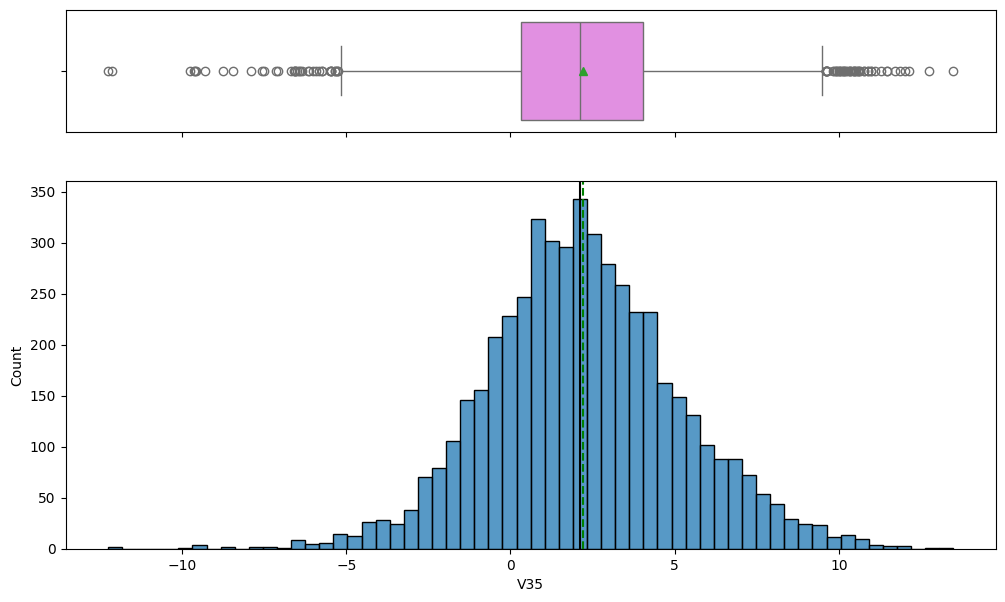

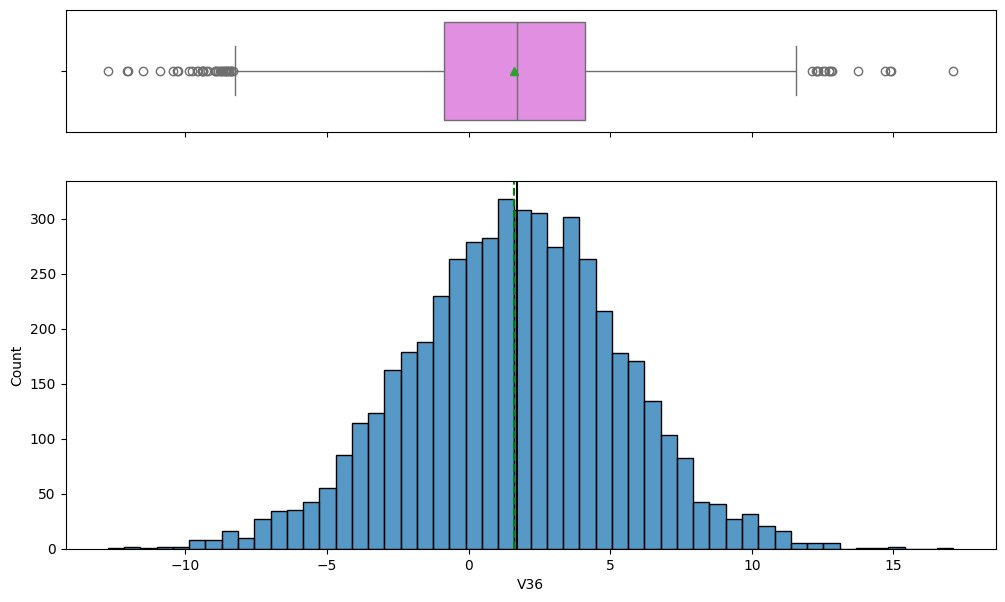

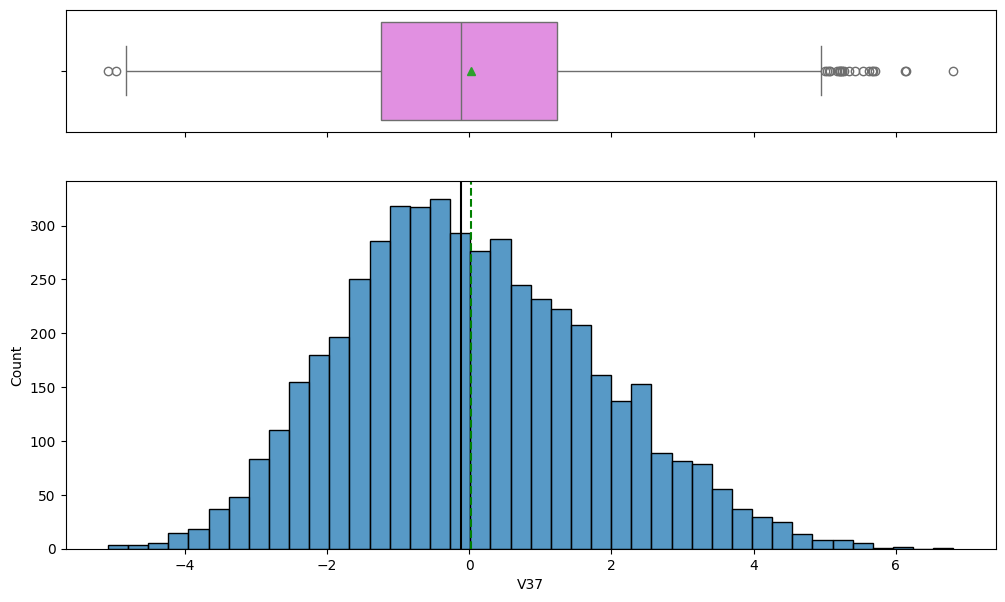

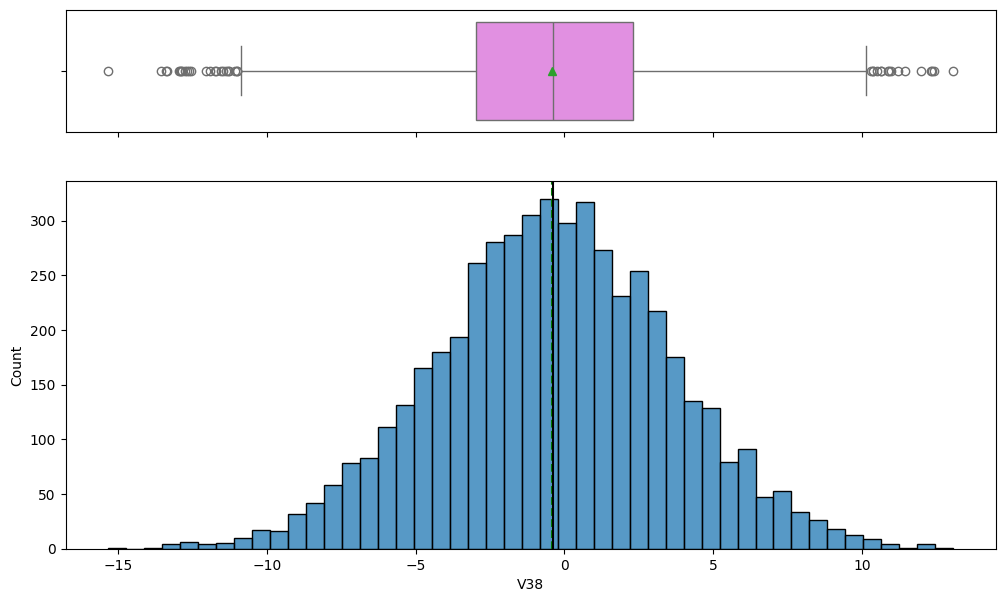

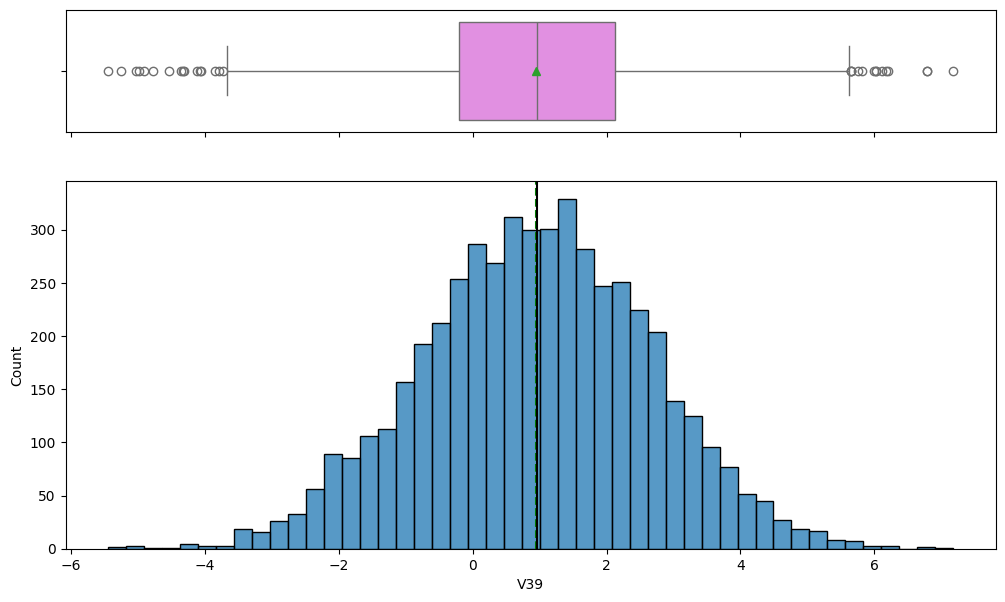

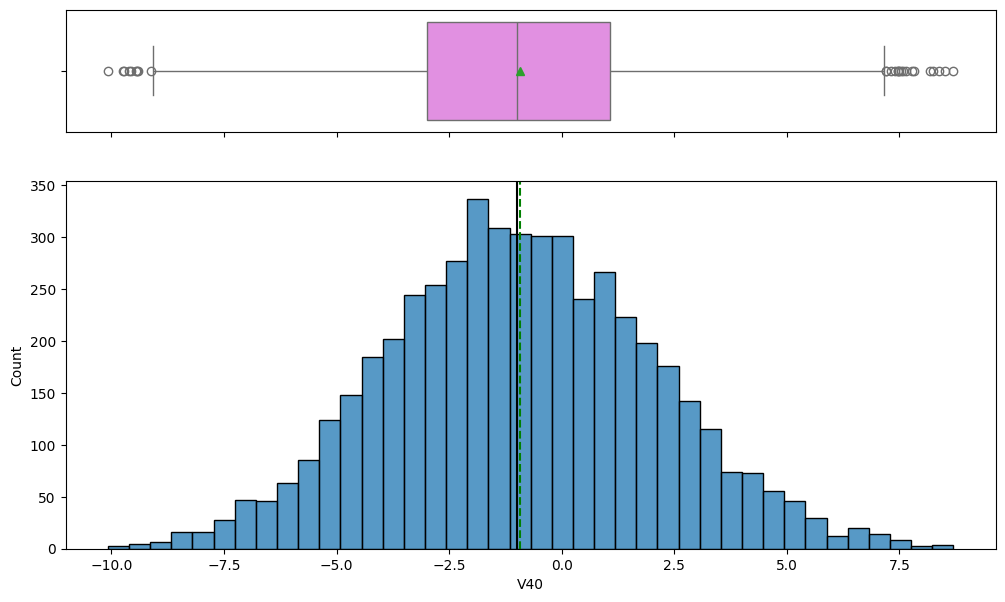

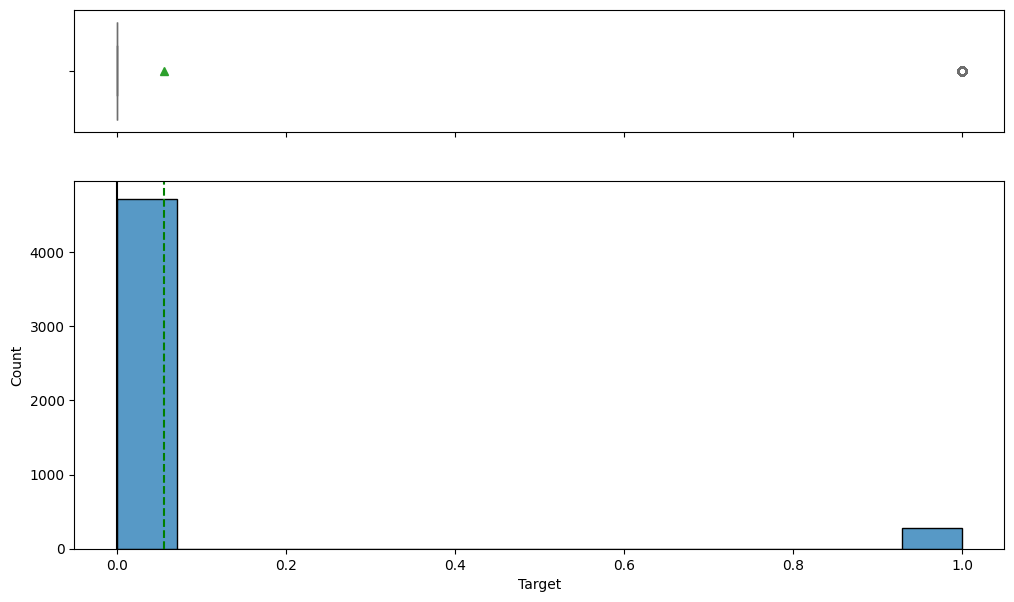

In [359]:
for feature in df_test.columns:
    histogram_boxplot(df_test, feature, figsize=(12, 7), kde=False, bins=None)

In [360]:
# Checking value counts of 0 and 1
data_test['Target'].value_counts()

Target
0    4718
1     282
Name: count, dtype: int64

Observations:

1. All columns from V1 to V40 demonstrates normal distribution

2. Number of 'No failure' outnumbered 'failure' in target variable. There are 4718 '0' and 282 '1' in test data target variable which means class is imbalanced in test data as well.

# **Bivariate Analysis:**

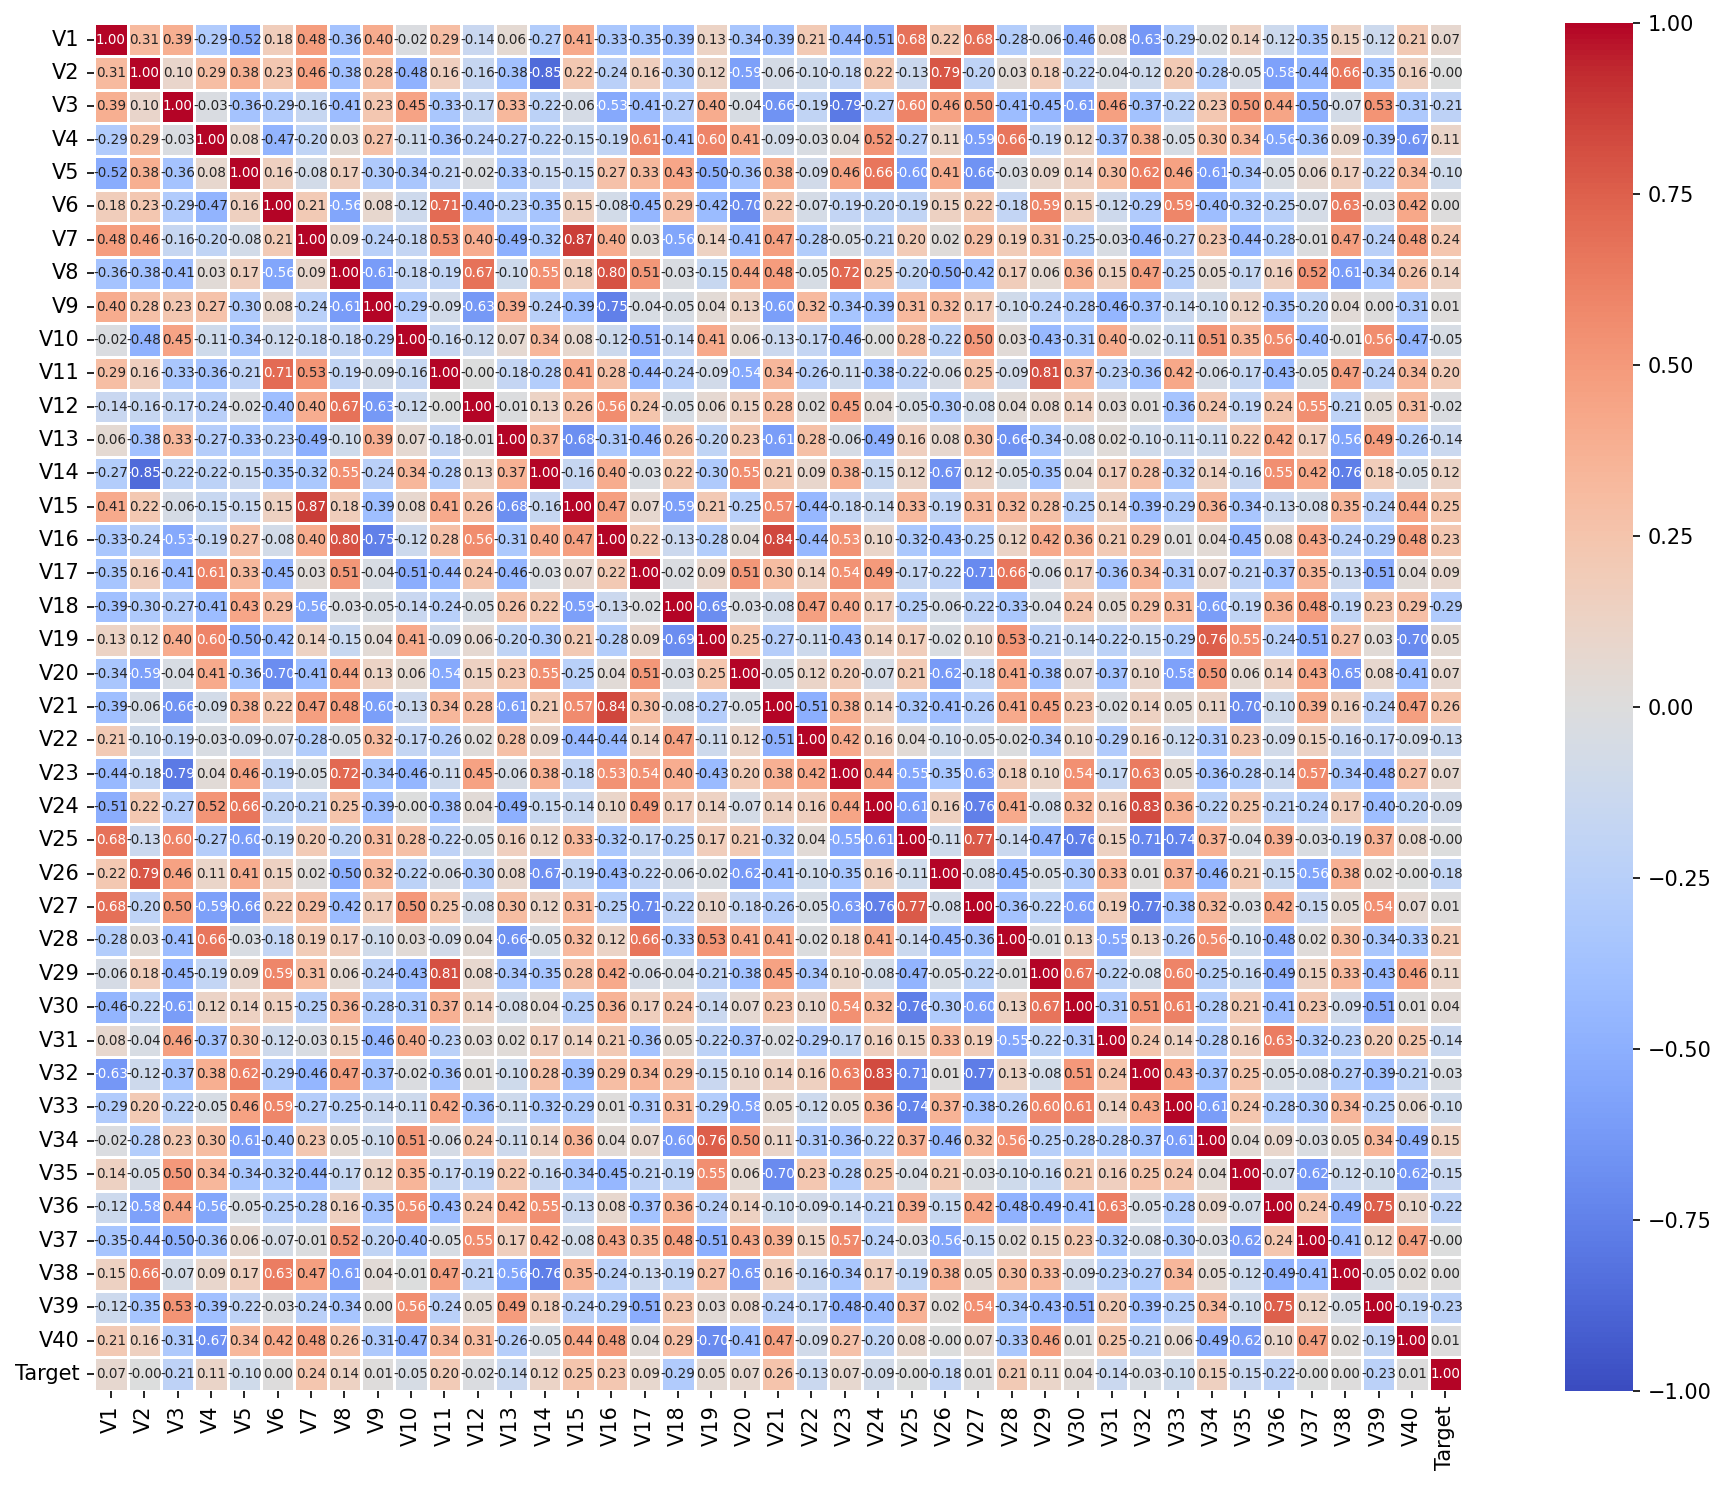

In [361]:
# plotting heat map of train data
plt.figure(figsize=(14, 10), dpi=150)  # Increase figure size and resolution

heatmap = sns.heatmap(data.corr(),
                      annot=True,
                      fmt=".2f",
                      annot_kws={'size': 6.5},  # Increase font size
                      vmin=-1, vmax=1,
                      cmap='coolwarm',
                      linewidths=0.5,
                      square=True)


plt.tight_layout()
plt.show();

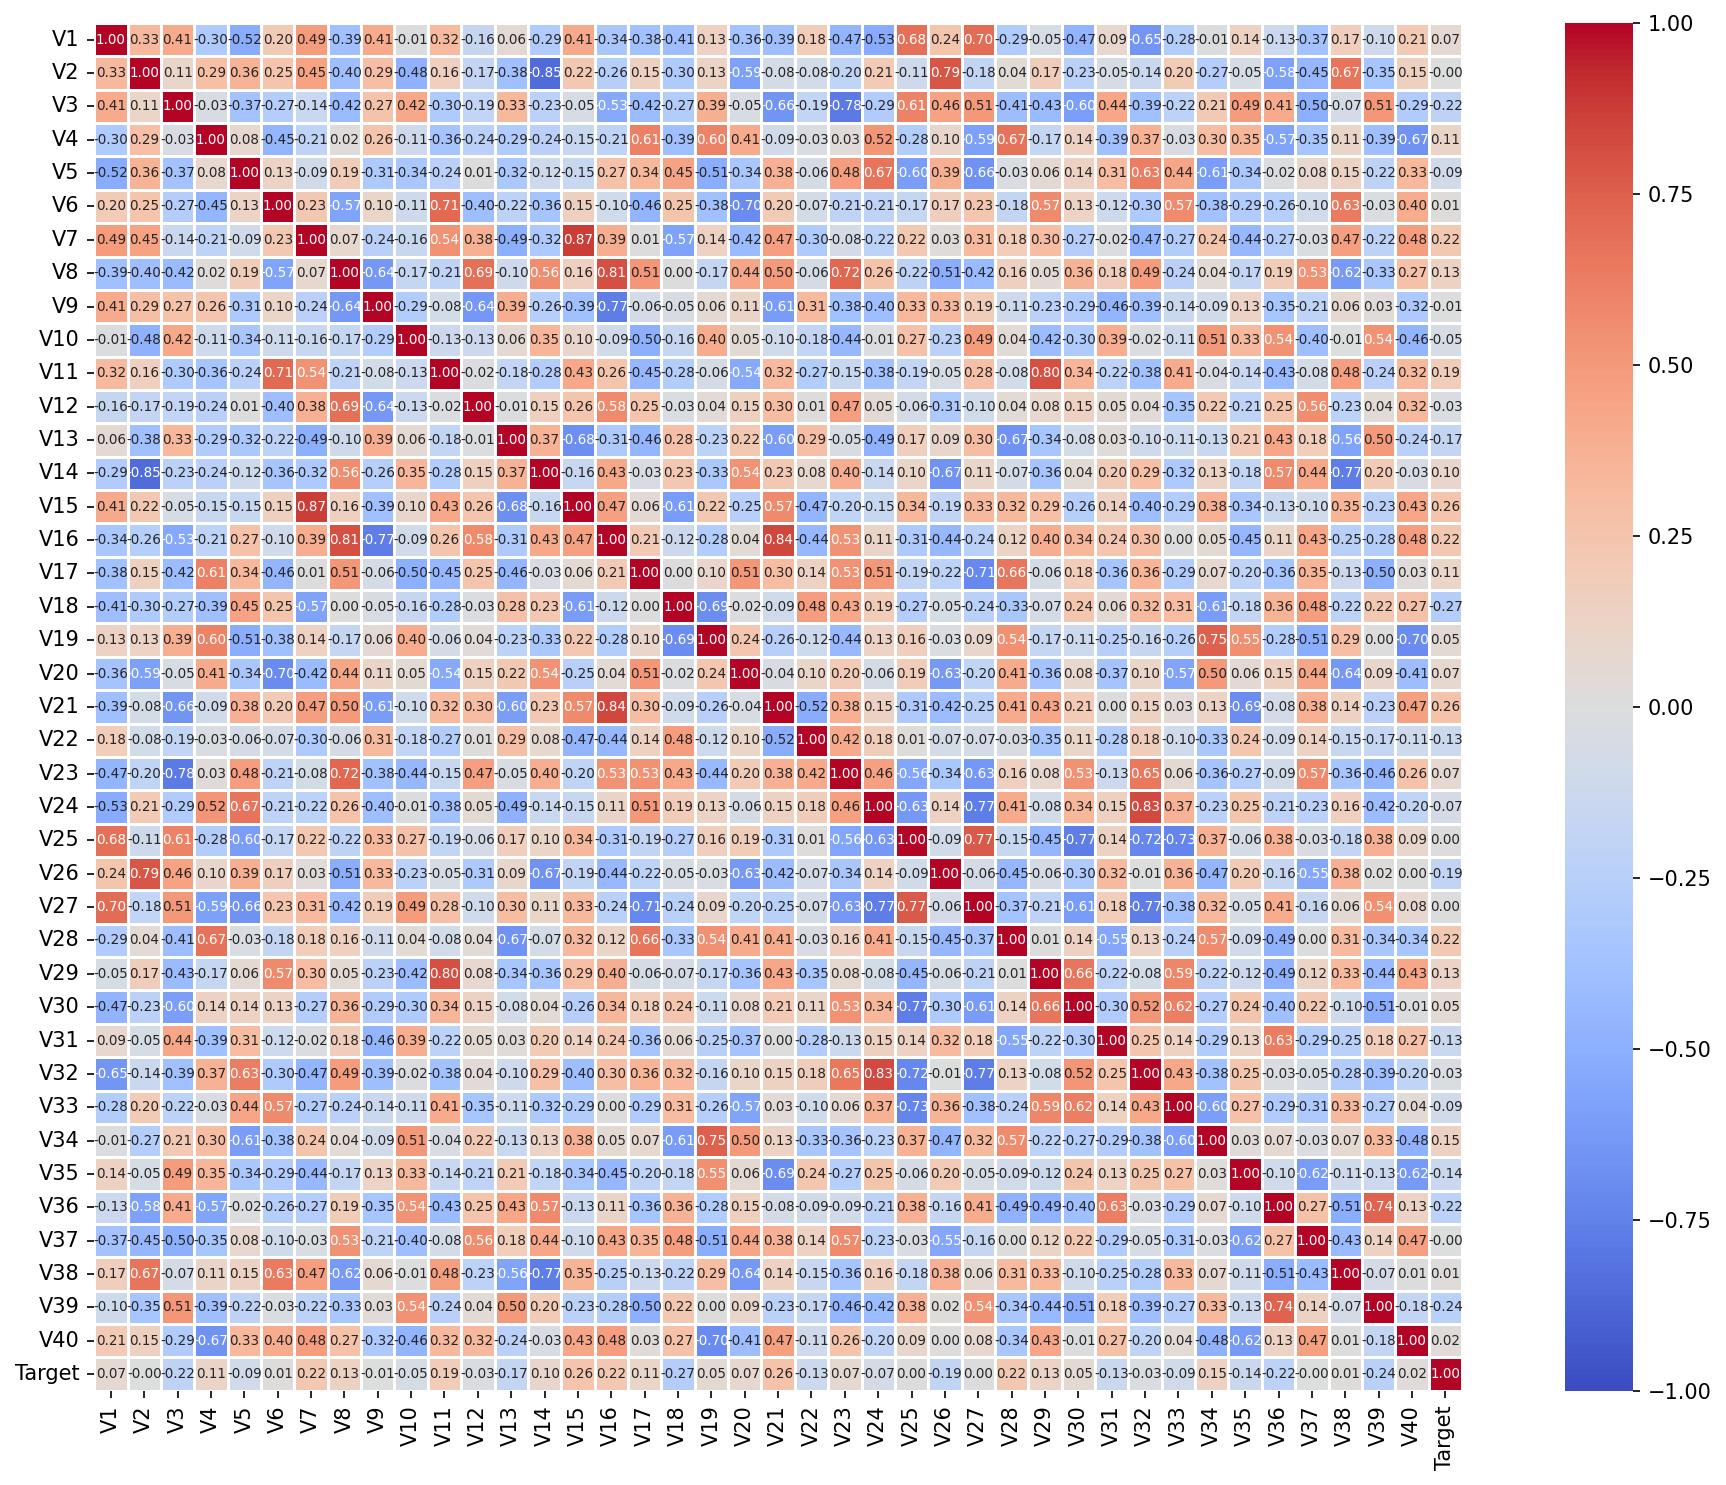

In [362]:
# Plotting heatmap for test data
plt.figure(figsize=(14, 10), dpi=150)  # Increase figure size and resolution

heatmap = sns.heatmap(data_test.corr(),
                      annot=True,
                      fmt=".2f",
                      annot_kws={'size': 6.5},  # Increase font size
                      vmin=-1, vmax=1,
                      cmap='coolwarm',
                      linewidths=0.5,
                      square=True)


plt.tight_layout()
plt.show();

Observations:

1. There are some strong correlations depicted in heatmap which is common in both train and test set

2. V2 and V26 demonstrate strong correlation which means V2 increases than V26 will increase as well

3. V7 is directly proportional to V15

4. V16 is directly proportional to V8 and V21

5. V11 is directly proportional to V29

6. V24 is directly proportional to V32

## Data Pre-processing

In [363]:
# Dividing data into X and y
X = data.drop(['Target'], axis=1)
y = data['Target']

In [364]:
# Splitting train data in train and validation set
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=1, stratify=y)
print('Shape of X_train:', X_train.shape)
print('Shape of X_val:', X_val.shape)
print('Shape of y_train:', y_train.shape)
print('Shape of y_val:', y_val.shape)

Shape of X_train: (14000, 40)
Shape of X_val: (6000, 40)
Shape of y_train: (14000,)
Shape of y_val: (6000,)


In [365]:
# Splitting test data in X_test and y_test
X_test = data_test.drop(['Target'], axis=1)
y_test = data_test['Target']
print('Shape of X_test:', X_test.shape)
print('Shape of y_test:', y_test.shape)

Shape of X_test: (5000, 40)
Shape of y_test: (5000,)


## Missing value imputation




In [366]:
# calling simple imputation function
imputer = SimpleImputer(strategy='median')

We will impute missing values with median because it is continuous values and also, some variables were skewed and has outliers

In [367]:
# Imputing the value of X_train, X_val and X_test with simple imputer (median)
X_train = pd.DataFrame(imputer.fit_transform(X_train), columns=X_train.columns)
X_val = pd.DataFrame(imputer.transform(X_val), columns=X_train.columns)
X_test = pd.DataFrame(imputer.transform(X_test), columns=X_train.columns)

In [368]:
# Checking that no column has missing values in train or test sets
print(X_train.isna().sum())
print("-" * 30)
print(X_val.isna().sum())
print("-" * 30)
print(X_test.isna().sum())

V1     0
V2     0
V3     0
V4     0
V5     0
V6     0
V7     0
V8     0
V9     0
V10    0
V11    0
V12    0
V13    0
V14    0
V15    0
V16    0
V17    0
V18    0
V19    0
V20    0
V21    0
V22    0
V23    0
V24    0
V25    0
V26    0
V27    0
V28    0
V29    0
V30    0
V31    0
V32    0
V33    0
V34    0
V35    0
V36    0
V37    0
V38    0
V39    0
V40    0
dtype: int64
------------------------------
V1     0
V2     0
V3     0
V4     0
V5     0
V6     0
V7     0
V8     0
V9     0
V10    0
V11    0
V12    0
V13    0
V14    0
V15    0
V16    0
V17    0
V18    0
V19    0
V20    0
V21    0
V22    0
V23    0
V24    0
V25    0
V26    0
V27    0
V28    0
V29    0
V30    0
V31    0
V32    0
V33    0
V34    0
V35    0
V36    0
V37    0
V38    0
V39    0
V40    0
dtype: int64
------------------------------
V1     0
V2     0
V3     0
V4     0
V5     0
V6     0
V7     0
V8     0
V9     0
V10    0
V11    0
V12    0
V13    0
V14    0
V15    0
V16    0
V17    0
V18    0
V19    0
V20    0
V21    0
V22

We have done missing value treatment and as we can see there are no null values present in this data now on.

## Model Building

### Model evaluation criterion

The nature of predictions made by the classification model will translate as follows:

- True positives (TP) are failures correctly predicted by the model.
- False negatives (FN) are real failures in a generator where there is no detection by model.
- False positives (FP) are failure detections in a generator where there is no failure.

**Which metric to optimize?**

* We need to choose the metric which will ensure that the maximum number of generator failures are predicted correctly by the model.
* We would want Recall to be maximized as greater the Recall, the higher the chances of minimizing false negatives.
* We want to minimize false negatives because if a model predicts that a machine will have no failure when there will be a failure, it will increase the maintenance cost.

**Let's define a function to output different metrics (including recall) on the train and test set and a function to show confusion matrix so that we do not have to use the same code repetitively while evaluating models.**

In [369]:
# defining a function to compute different metrics to check performance of a classification model built using sklearn
def model_performance_classification_sklearn(model, predictors, target):
    """
    Function to compute different metrics to check classification model performance

    model: classifier
    predictors: independent variables
    target: dependent variable
    """

    # predicting using the independent variables
    pred = model.predict(predictors)

    acc = accuracy_score(target, pred)  # to compute Accuracy
    recall = recall_score(target, pred)  # to compute Recall
    precision = precision_score(target, pred)  # to compute Precision
    f1 = f1_score(target, pred)  # to compute F1-score

    # creating a dataframe of metrics
    df_perf = pd.DataFrame(
        {
            "Accuracy": acc,
            "Recall": recall,
            "Precision": precision,
            "F1": f1

        },
        index=[0],
    )

    return df_perf

In [370]:
def confusion_matrix_sklearn(model, predictors, target):
    """
    To plot the confusion_matrix with percentages

    model: classifier
    predictors: independent variables
    target: dependent variable
    """
    y_pred = model.predict(predictors)
    cm = confusion_matrix(target, y_pred)
    labels = np.asarray(
        [
            ["{0:0.0f}".format(item) + "\n{0:.2%}".format(item / cm.flatten().sum())]
            for item in cm.flatten()
        ]
    ).reshape(2, 2)

    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=labels, fmt="")
    plt.ylabel("True label")
    plt.xlabel("Predicted label")

### Defining scorer to be used for cross-validation and hyperparameter tuning

- We want to reduce false negatives and will try to maximize "Recall".
- To maximize Recall, we can use Recall as a **scorer** in cross-validation and hyperparameter tuning.

In [371]:
# Type of scoring used to compare parameter combinations
scorer = metrics.make_scorer(metrics.recall_score)

### Model Building with original data

Sample Decision Tree model building with original data

In [372]:
models = []  # Empty list to store all the models

# Appending models into the list
models.append(("dtree", DecisionTreeClassifier(random_state=1)))
models.append(("log.reg", LogisticRegression(random_state=1)))
models.append(("bg", BaggingClassifier(random_state=1)))
models.append(("rf", RandomForestClassifier(random_state=1)))
models.append(("ada", AdaBoostClassifier(random_state=1)))
models.append(("gb", GradientBoostingClassifier(random_state=1)))
models.append(("xg", XGBClassifier(random_state=1)))

results1 = []  # Empty list to store all model's CV scores
names = []  # Empty list to store name of the models


# loop through all models to get the mean cross validated score
print("\n" "Cross-Validation performance on training dataset:" "\n")

for name, model in models:
    kfold = StratifiedKFold(
        n_splits=5, shuffle=True, random_state=1
    )  # Setting number of splits equal to 5
    cv_result = cross_val_score(
        estimator=model, X=X_train, y=y_train, scoring=scorer, cv=kfold
    )
    results1.append(cv_result)
    names.append(name)
    print("{}: {}".format(name, cv_result.mean()))

print("\n" "Validation Performance:" "\n")

for name, model in models:
    model.fit(X_train, y_train)
    scores = recall_score(y_val, model.predict(X_val))
    print("{}: {}".format(name, scores))


Cross-Validation performance on training dataset:

dtree: 0.7078246484698097
log.reg: 0.4902481389578163
bg: 0.707808105872622
rf: 0.7194127377998345
ada: 0.5109181141439206
gb: 0.7220016542597187
xg: 0.8095368072787427

Validation Performance:

dtree: 0.7057057057057057
log.reg: 0.5015015015015015
bg: 0.7267267267267268
rf: 0.7357357357357357
ada: 0.5555555555555556
gb: 0.7357357357357357
xg: 0.8288288288288288


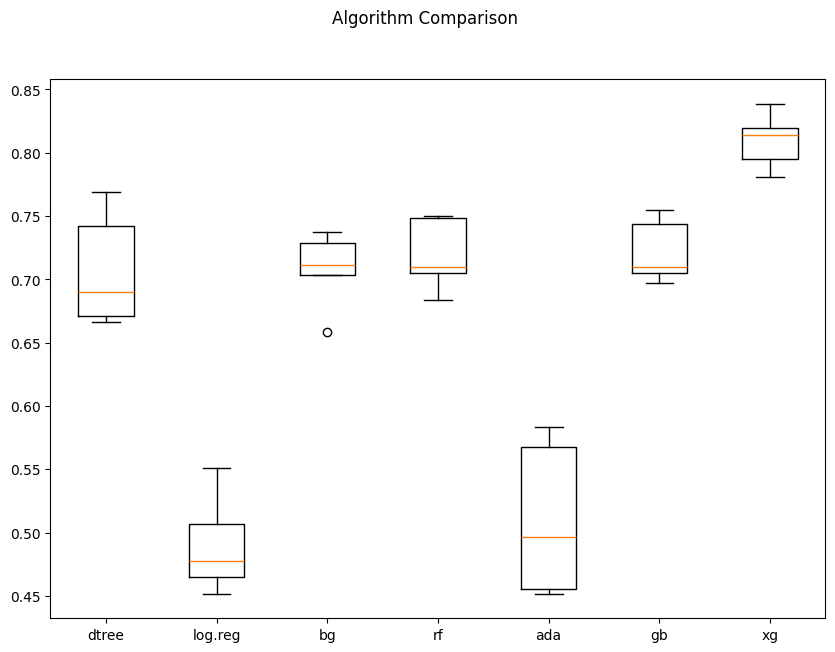

In [373]:
# Plotting boxplots for CV scores of all models defined above
fig = plt.figure(figsize=(10, 7))

fig.suptitle("Algorithm Comparison")
ax = fig.add_subplot(111)

plt.boxplot(results1)
ax.set_xticklabels(names)

plt.show()

Observations:

1. The decision tree cross validation accuracy was 70.78% and validation data set recall score was 70.57%
2. The logistic regression cross validation accuracy was 49.02% and validation data set recall score was 50.15%
3. The bagging classifier cross validation accuracy was 70.78% and validation data set recall score was 72.67%
4. The random forest classifier cross validation accuracy was 71.94% and validation data set recall score was 73.57%
5. The adaboost classifier cross validation accuracy was 51.09% and validation data set recall score was 55.55%
6. The gradient boosting cross validation accuracy was 72.20% and validation data set recall score was 73.57%
7. The xgboost cross validation accuracy was 80.95% and validation data set recall score was 82.88%

XGBoost Classifier model cross validation accuracy score as well as validation data set recall score is outperforming all the other models in predicting the failure and non-failure of generators


### Model Building with Oversampled data


In [374]:
print("Before OverSampling, counts of label '1': {}".format(sum(y_train == 1)))
print("Before OverSampling, counts of label '0': {} \n".format(sum(y_train == 0)))

# Synthetic Minority Over Sampling Technique
sm = SMOTE(sampling_strategy=1, k_neighbors=5, random_state=1)
X_train_over, y_train_over = sm.fit_resample(X_train, y_train)


print("After OverSampling, counts of label '1': {}".format(sum(y_train_over == 1)))
print("After OverSampling, counts of label '0': {} \n".format(sum(y_train_over == 0)))


print("After OverSampling, the shape of train_X: {}".format(X_train_over.shape))
print("After OverSampling, the shape of train_y: {} \n".format(y_train_over.shape))

Before OverSampling, counts of label '1': 777
Before OverSampling, counts of label '0': 13223 

After OverSampling, counts of label '1': 13223
After OverSampling, counts of label '0': 13223 

After OverSampling, the shape of train_X: (26446, 40)
After OverSampling, the shape of train_y: (26446,) 



In [375]:
models_over = []  # Empty list to store all the models

# Appending models into the list
models_over.append(("dtree_over", DecisionTreeClassifier(random_state=1)))
models_over.append(("log.reg_over", LogisticRegression(random_state=1)))
models_over.append(("bg_over", BaggingClassifier(random_state=1)))
models_over.append(("rf_over", RandomForestClassifier(random_state=1)))
models_over.append(("ada_over", AdaBoostClassifier(random_state=1)))
models_over.append(("gb_over", GradientBoostingClassifier(random_state=1)))
models_over.append(("xg_over", XGBClassifier(random_state=1)))

results1_over = []  # Empty list to store all model's CV scores
names_over = []  # Empty list to store name of the models


# loop through all models to get the mean cross validated score
print("\n" "Cross-Validation performance on training dataset_oversampled:" "\n")

for name, model in models_over:
    kfold = StratifiedKFold(
        n_splits=5, shuffle=True, random_state=1
    )  # Setting number of splits equal to 5
    cv_result_over = cross_val_score(
        estimator=model, X=X_train_over, y=y_train_over, scoring=scorer, cv=kfold
    )  ## Complete the code to build models on oversampled data
    results1_over.append(cv_result_over)
    names_over.append(name)
    print("{}: {}".format(name, cv_result_over.mean()))

print("\n" "Validation Performance_over sampled:" "\n")

for name, model in models_over:
    model.fit(X_train_over,y_train_over)## Complete the code to build models on oversampled data
    scores = recall_score(y_val, model.predict(X_val))
    print("{}: {}".format(name, scores))


Cross-Validation performance on training dataset_oversampled:

dtree_over: 0.970128321355339
log.reg_over: 0.8917044404851445
bg_over: 0.975119441528989
rf_over: 0.9829090368319754
ada_over: 0.8966949600908288
gb_over: 0.9329201902370526
xg_over: 0.9904713314591799

Validation Performance_over sampled:

dtree_over: 0.7837837837837838
log.reg_over: 0.8498498498498499
bg_over: 0.8258258258258259
rf_over: 0.8558558558558559
ada_over: 0.8588588588588588
gb_over: 0.8768768768768769
xg_over: 0.8558558558558559


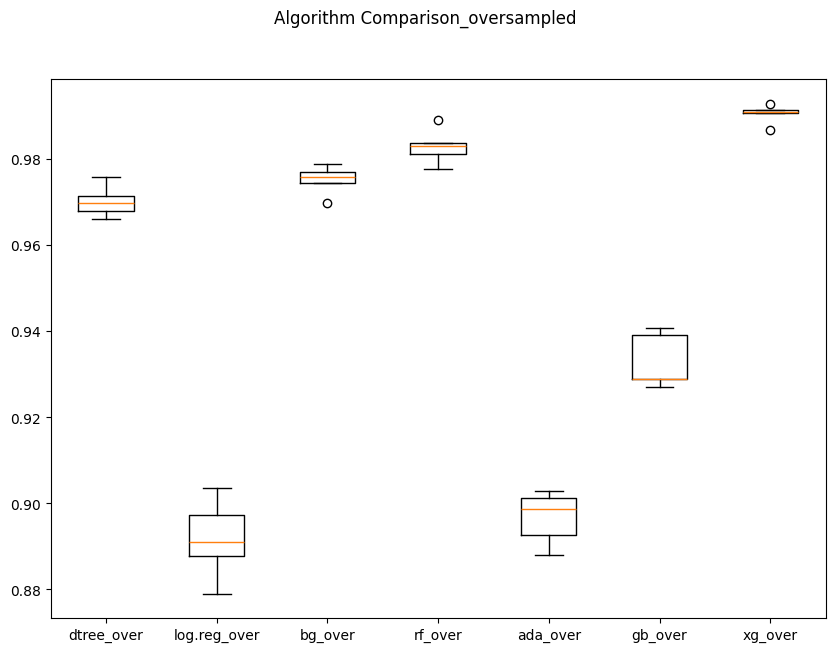

In [376]:
# Plotting boxplots for CV scores of all models defined above
fig = plt.figure(figsize=(10, 7))

fig.suptitle("Algorithm Comparison_oversampled")
ax = fig.add_subplot(111)

plt.boxplot(results1_over)
ax.set_xticklabels(names_over)

plt.show()

Observations on OverSampled model:

1. The decision tree cross validation accuracy was 97.01% and validation data set recall score was 78.37%
2. The logistic regression cross validation accuracy was 89.17% and validation data set recall score was 84.98%
3. The bagging classifier cross validation accuracy was 97.51% and validation data set recall score was 82.58%
4. The random forest classifier cross validation accuracy was 98.29% and validation data set recall score was 85.58%
5. The adaboost classifier cross validation accuracy was 89.66% and validation data set recall score was 85.88%
6. The gradient boosting cross validation accuracy was 93.29% and validation data set recall score was 87.68%
7. The xgboost cross validation accuracy was 99.04% and validation data set recall score was 85.58%


Almost every model's accuracy of cross validation and validation data recall score after oversampling has been improved.


Looks like RandomForest Classifier, Gradient Boost classifier and XGBoost Classifier oversampled models' cross validation accuracy score as well as validation data set recall score is outperforming all the other models in predicting the failure and non-failure of generators

### Model Building with Undersampled data

In [377]:
print("Before UnderSampling, counts of label '1': {}".format(sum(y_train == 1)))
print("Before UnderSampling, counts of label '0': {} \n".format(sum(y_train == 0)))

# Random undersampler for under sampling the data
rus = RandomUnderSampler(random_state=1, sampling_strategy=1)
X_train_un, y_train_un = rus.fit_resample(X_train, y_train)


print("After UnderSampling, counts of label '1': {}".format(sum(y_train_un == 1)))
print("After UnderSampling, counts of label '0': {} \n".format(sum(y_train_un == 0)))


print("After UnderSampling, the shape of train_X: {}".format(X_train_un.shape))
print("After UnderSampling, the shape of train_y: {} \n".format(y_train_un.shape))

Before UnderSampling, counts of label '1': 777
Before UnderSampling, counts of label '0': 13223 

After UnderSampling, counts of label '1': 777
After UnderSampling, counts of label '0': 777 

After UnderSampling, the shape of train_X: (1554, 40)
After UnderSampling, the shape of train_y: (1554,) 



In [378]:
models_un = []  # Empty list to store all the models

# Appending models into the list
models_un.append(("dtree_un", DecisionTreeClassifier(random_state=1)))
models_un.append(("log.reg_un", LogisticRegression(random_state=1)))
models_un.append(("bg_un", BaggingClassifier(random_state=1)))
models_un.append(("rf_un", RandomForestClassifier(random_state=1)))
models_un.append(("ada_un", AdaBoostClassifier(random_state=1)))
models_un.append(("gb_un", GradientBoostingClassifier(random_state=1)))
models_un.append(("xg_un", XGBClassifier(random_state=1)))

results1_un = []  # Empty list to store all model's CV scores
names_un = []  # Empty list to store name of the models


# loop through all models to get the mean cross validated score
print("\n" "Cross-Validation performance on training dataset_undersampled:" "\n")

for name, model in models_un:
    kfold = StratifiedKFold(
        n_splits=5, shuffle=True, random_state=1
    )  # Setting number of splits equal to 5
    cv_result_un = cross_val_score(
        estimator=model, X=X_train_un, y=y_train_un, scoring=scorer, cv=kfold
    )  ## Complete the code to build models on oversampled data
    results1_un.append(cv_result_un)
    names_un.append(name)
    print("{}: {}".format(name, cv_result_un.mean()))

print("\n" "Validation Performance_Under sampled:" "\n")

for name, model in models_un:
    model.fit(X_train_un,y_train_un)## Complete the code to build models on oversampled data
    scores = recall_score(y_val, model.predict(X_val))
    print("{}: {}".format(name, scores))


Cross-Validation performance on training dataset_undersampled:

dtree_un: 0.8622167080231596
log.reg_un: 0.8726220016542598
bg_un: 0.880339123242349
rf_un: 0.9034822167080232
ada_un: 0.8687427626137303
gb_un: 0.8932009925558313
xg_un: 0.8983457402812242

Validation Performance_Under sampled:

dtree_un: 0.8408408408408409
log.reg_un: 0.8468468468468469
bg_un: 0.8708708708708709
rf_un: 0.8828828828828829
ada_un: 0.8468468468468469
gb_un: 0.8828828828828829
xg_un: 0.8828828828828829


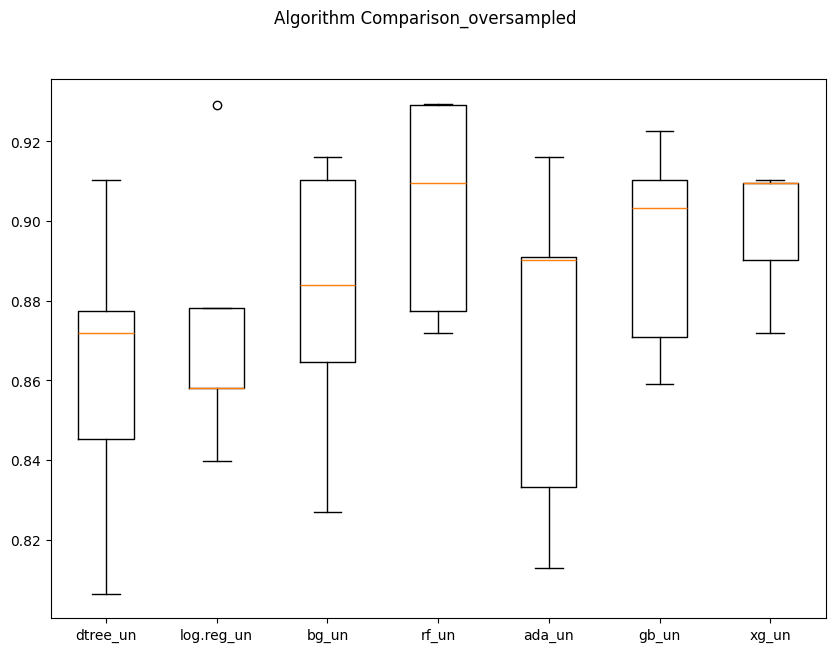

In [379]:
# Plotting boxplots for CV scores of all models defined above
fig = plt.figure(figsize=(10, 7))

fig.suptitle("Algorithm Comparison_oversampled")
ax = fig.add_subplot(111)

plt.boxplot(results1_un)
ax.set_xticklabels(names_un)

plt.show()

Observations on UnderSampling:

1. The decision tree cross validation accuracy was 86.22% and validation data set recall score was 84.08%
2. The logistic regression cross validation accuracy was 87.26% and validation data set recall score was 84.68%
3. The bagging classifier cross validation accuracy was 88.03% and validation data set recall score was 87.08%
4. The random forest classifier cross validation accuracy was 90.34% and validation data set recall score was 88.28%
5. The adaboost classifier cross validation accuracy was 86.87% and validation data set recall score was 84.68%
6. The gradient boosting cross validation accuracy was 89.32% and validation data set recall score was 88.28%
7. The xgboost cross validation accuracy was 89.83% and validation data set recall score was 88.28%

Seems like undersampling reduces accuracy of cross validation as well as validation recall score compared to Oversampling. Hence, oversampling is more preferrable than undersampling.

Random Forest, Gradient boost and XGboost undersampled models outperformed others as per results.

## HyperparameterTuning

**Observations:**

Choosing best models for hypertuning from previous results of CV and validation recall score:

From the above results, the models which are concluded to further hypertuning are: **RandomForest Classifier, GradientBoost Classifier and XGBoost Classifier**

We will also perform tuning on decision tree classifier as mentioned in following project

### Sample Parameter Grids

**Hyperparameter tuning can take a long time to run, so to avoid that time complexity - you can use the following grids, wherever required.**

- For Gradient Boosting:

param_grid = {
    "n_estimators": np.arange(100,150,25),
    "learning_rate": [0.2, 0.05, 1],
    "subsample":[0.5,0.7],
    "max_features":[0.5,0.7]
}

- For Adaboost:

param_grid = {
    "n_estimators": [100, 150, 200],
    "learning_rate": [0.2, 0.05],
    "base_estimator": [DecisionTreeClassifier(max_depth=1, random_state=1), DecisionTreeClassifier(max_depth=2, random_state=1), DecisionTreeClassifier(max_depth=3, random_state=1),
    ]
}

- For Bagging Classifier:

param_grid = {
    'max_samples': [0.8,0.9,1],
    'max_features': [0.7,0.8,0.9],
    'n_estimators' : [30,50,70],
}

- For Random Forest:

param_grid = {
    "n_estimators": [200,250,300],
    "min_samples_leaf": np.arange(1, 4),
    "max_features": [np.arange(0.3, 0.6, 0.1),'sqrt'],
    "max_samples": np.arange(0.4, 0.7, 0.1)
}

- For Decision Trees:

param_grid = {
    'max_depth': np.arange(2,6),
    'min_samples_leaf': [1, 4, 7],
    'max_leaf_nodes' : [10, 15],
    'min_impurity_decrease': [0.0001,0.001]
}

- For Logistic Regression:

param_grid = {'C': np.arange(0.1,1.1,0.1)}

- For XGBoost:

param_grid={
    'n_estimators': [150, 200, 250],
    'scale_pos_weight': [5,10],
    'learning_rate': [0.1,0.2],
    'gamma': [0,3,5],
    'subsample': [0.8,0.9]
}

### Sample tuning method for Decision tree with original data

In [380]:
%%time
# defining model
Model_dt = DecisionTreeClassifier(random_state=1)

# Parameter grid to pass in RandomSearchCV
param_grid = {'max_depth': np.arange(2,6),
              'min_samples_leaf': [1, 4, 7],
              'max_leaf_nodes' : [10,15],
              'min_impurity_decrease': [0.0001,0.001] }

#Calling RandomizedSearchCV
randomized_cv = RandomizedSearchCV(estimator=Model_dt, param_distributions=param_grid, n_iter=10, n_jobs = 1, scoring=scorer, cv=5, random_state=1)

#Fitting parameters in RandomizedSearchCV
randomized_cv.fit(X_train,y_train)

print("Best parameters are {} with CV score={}:" .format(randomized_cv.best_params_,randomized_cv.best_score_))

Best parameters are {'min_samples_leaf': 7, 'min_impurity_decrease': 0.0001, 'max_leaf_nodes': 15, 'max_depth': np.int64(5)} with CV score=0.550752688172043:
CPU times: user 16.7 s, sys: 8.01 ms, total: 16.7 s
Wall time: 16.8 s


In [381]:
# Creating new pipeline with best parameters
tuned_dt = DecisionTreeClassifier(
    min_samples_leaf=7,
    min_impurity_decrease=0.0001,
    max_leaf_nodes=15,
    max_depth=np.int64(5),
    random_state=1)

tuned_dt.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=np.int64(5), max_leaf_nodes=15,
                       min_impurity_decrease=0.0001, min_samples_leaf=7,
                       random_state=1)

In [382]:
# Model performance of train set
dt_score = model_performance_classification_sklearn(tuned_dt, X_train, y_train)
dt_score

Accuracy  Recall  Precision    F1
0     0.976   0.631      0.911 0.745

In [383]:
# Model Performance on val set
dt_score_val = model_performance_classification_sklearn(tuned_dt, X_val, y_val)
dt_score_val

Accuracy  Recall  Precision    F1
0     0.972   0.631      0.814 0.711

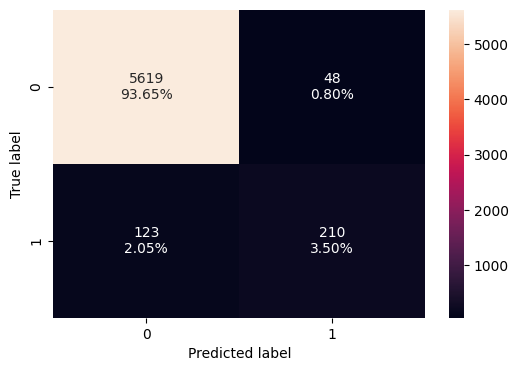

In [384]:
confusion_matrix_sklearn(tuned_dt, X_val, y_val)

Observations:

1. Tuned Decision Tree train set performance was 97.6% Accuracy, 63.1% Recall, 91.1% Precision and 74.5% F1 score

2. Tuned Decision Tree validation set performance was 97.2% Accuracy, 63.1% Recall, 81.4% Precision and 71.1% F1 score

3. Time taken for tuned model to run was 16.8 s

4. Cross validation accuracy score was 55.07%

Hence, validation set shows slightly low performance score compared to training set

### Sample tuning method for Decision tree with oversampled data

In [385]:
%%time
# defining model
Model_dt_over = DecisionTreeClassifier(random_state=1)

# Parameter grid to pass in RandomSearchCV
param_grid = {'max_depth': np.arange(2,6),
              'min_samples_leaf': [1, 4, 7],
              'max_leaf_nodes' : [10,15],
              'min_impurity_decrease': [0.0001,0.001] }

#Calling RandomizedSearchCV
randomized_cv = RandomizedSearchCV(estimator=Model_dt_over, param_distributions=param_grid, n_iter=10, n_jobs = 1, scoring=scorer, cv=5, random_state=1)

#Fitting parameters in RandomizedSearchCV
randomized_cv.fit(X_train_over,y_train_over)

print("Best parameters are {} with CV score={}:" .format(randomized_cv.best_params_,randomized_cv.best_score_))

Best parameters are {'min_samples_leaf': 7, 'min_impurity_decrease': 0.001, 'max_leaf_nodes': 15, 'max_depth': np.int64(3)} with CV score=0.9240715362242579:
CPU times: user 32 s, sys: 27 ms, total: 32.1 s
Wall time: 32.2 s


In [386]:
# Creating new pipeline with best parameters
tuned_dt_over = DecisionTreeClassifier(
    min_samples_leaf=7,
    min_impurity_decrease=0.001,
    max_leaf_nodes=15,
    max_depth=np.int64(3),
    random_state=1)

tuned_dt_over.fit(X_train_over, y_train_over)

DecisionTreeClassifier(max_depth=np.int64(3), max_leaf_nodes=15,
                       min_impurity_decrease=0.001, min_samples_leaf=7,
                       random_state=1)

In [387]:
# Model performance on training set
dt_score_over = model_performance_classification_sklearn(tuned_dt_over, X_train_over, y_train_over)
dt_score_over

Accuracy  Recall  Precision    F1
0     0.843   0.925      0.794 0.855

In [388]:
# Model performance on validation set
dt_score_over_val = model_performance_classification_sklearn(tuned_dt_over, X_val, y_val)
dt_score_over_val

Accuracy  Recall  Precision    F1
0     0.754   0.877      0.169 0.284

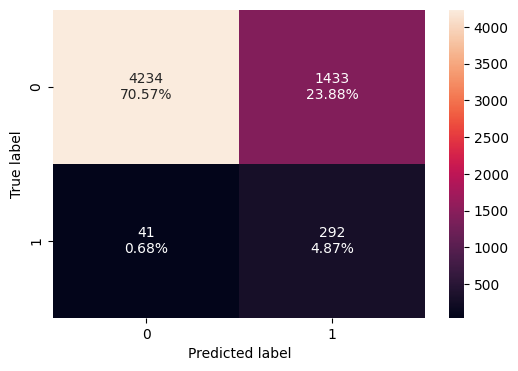

In [389]:
confusion_matrix_sklearn(tuned_dt_over, X_val, y_val)

Observations:

1. Tuned Decision Tree train set performance was 84.3% Accuracy, 92,5% Recall, 79.4% Precision and 85.5% F1 score

2. Tuned Decision Tree validation set performance was 75.4% Accuracy, 87.7% Recall, 16.9% Precision and 28.4% F1 score

3. Time taken for tuned model to run was 32.2 s

4. Cross validation accuracy score was 92.40%

Hence, validation set shows slightly low performance score compared to training set. Also, we are getting improved Recall score on oversampled data compared to original data but Precision and F1 score were less compared to original data. Also, this oversampled model took more time to run than original data. This model gave improved cross validation accuracy score of 92.40% compared to original model

### Sample tuning method for Decision tree with undersampled data

In [390]:
%%time
# defining model
Model_dt_un = DecisionTreeClassifier(random_state=1)

# Parameter grid to pass in RandomSearchCV
param_grid = {'max_depth': np.arange(2,20),
              'min_samples_leaf': [1, 2, 5, 7],
              'max_leaf_nodes' : [5, 10,15],
              'min_impurity_decrease': [0.0001,0.001] }

#Calling RandomizedSearchCV
randomized_cv = RandomizedSearchCV(estimator=Model_dt_un, param_distributions=param_grid, n_iter=10, n_jobs = 1, scoring=scorer, cv=5, random_state=1)

#Fitting parameters in RandomizedSearchCV
randomized_cv.fit(X_train_un,y_train_un)

print("Best parameters are {} with CV score={}:" .format(randomized_cv.best_params_,randomized_cv.best_score_))

Best parameters are {'min_samples_leaf': 1, 'min_impurity_decrease': 0.001, 'max_leaf_nodes': 15, 'max_depth': np.int64(11)} with CV score=0.83520264681555:
CPU times: user 2.03 s, sys: 5 ms, total: 2.04 s
Wall time: 2.03 s


In [391]:
# Creating new pipeline with best parameters
tuned_dt_un = DecisionTreeClassifier(
    min_samples_leaf=1,
    min_impurity_decrease=0.001,
    max_leaf_nodes=15,
    max_depth=np.int64(11),
    random_state=1)

tuned_dt_un.fit(X_train_un, y_train_un)

DecisionTreeClassifier(max_depth=np.int64(11), max_leaf_nodes=15,
                       min_impurity_decrease=0.001, random_state=1)

In [392]:
# Model performance on training set
dt_score_un = model_performance_classification_sklearn(tuned_dt_un, X_train_un, y_train_un)
dt_score_un

Accuracy  Recall  Precision    F1
0     0.912   0.880      0.940 0.909

In [393]:
# Model performance on validation set
dt_score_un_val = model_performance_classification_sklearn(tuned_dt_un, X_val, y_val)
dt_score_un_val

Accuracy  Recall  Precision    F1
0     0.909   0.844      0.363 0.507

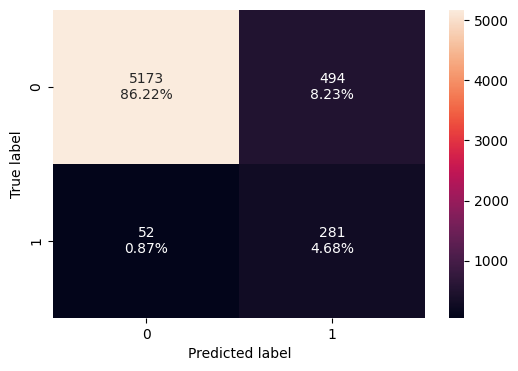

In [394]:
confusion_matrix_sklearn(tuned_dt_un, X_val, y_val)

Observations:

1. Tuned Decision Tree train set performance was 91.2% Accuracy, 88.0% Recall, 94.0% Precision and 90.9% F1 score

2. Tuned Decision Tree validation set performance was 90.9% Accuracy, 84.4% Recall, 36.3% Precision and 50.7% F1 score

3. Time taken for tuned model to run was 2.03 s

4. Cross validation accuracy score was 83.52%

Hence, validation set shows slightly low performance score compared to training set. Also, we are getting reduced Recall score on undersampled data compared to oversampled data. Also, this undersampled model took lowest time to run comparatively. This model gave improved cross validation accuracy score of 83.52% compared to original model but reduced in comparison with oversampled data.

**Looks like, original tuned decision tree model performance outperformed oversampled and undersampled model performance.**

## Best three models Hyperparameter tuning:

**Observations:**

From the above results, the models which are concluded to further hypertuning are: **RandomForest Classifier, GradientBoost Classifier and XGBoost Classifier*

**RandomForest Classifier: Original Model Tuning**

In [395]:
%%time
# defining model
Model_rf = RandomForestClassifier(random_state=1)

# Parameter grid to pass in RandomSearchCV
param_grid = { "n_estimators": [200,250,300],
              "min_samples_leaf": np.arange(1, 4),
               "max_features": [np.arange(0.3, 0.6, 0.1),'sqrt'],
               "max_samples": np.arange(0.4, 0.7, 0.1) }

#Calling RandomizedSearchCV
randomized_cv = RandomizedSearchCV(estimator=Model_rf, param_distributions=param_grid, n_iter=10, n_jobs = 1, scoring=scorer, cv=5, random_state=1)

#Fitting parameters in RandomizedSearchCV
randomized_cv.fit(X_train,y_train)

print("Best parameters are {} with CV score={}:" .format(randomized_cv.best_params_,randomized_cv.best_score_))

Best parameters are {'n_estimators': 250, 'min_samples_leaf': np.int64(1), 'max_samples': np.float64(0.6), 'max_features': 'sqrt'} with CV score=0.6950620347394542:
CPU times: user 12min 52s, sys: 525 ms, total: 12min 52s
Wall time: 12min 56s


In [396]:
# Creating new pipeline with best parameters
tuned_rf = RandomForestClassifier(
    n_estimators=250,
    min_samples_leaf= np.int64(1),
    max_samples= np.float64(0.6),
    max_features='sqrt',
    random_state=1)

tuned_rf.fit(X_train, y_train)

RandomForestClassifier(max_samples=np.float64(0.6),
                       min_samples_leaf=np.int64(1), n_estimators=250,
                       random_state=1)

In [397]:
# Model performance on training set
rf_score = model_performance_classification_sklearn(tuned_rf, X_train, y_train)
rf_score

Accuracy  Recall  Precision    F1
0     0.995   0.910      1.000 0.953

In [398]:
# Model performance on validation set
rf_score_val = model_performance_classification_sklearn(tuned_rf, X_val, y_val)
rf_score_val

Accuracy  Recall  Precision    F1
0     0.984   0.721      0.988 0.833

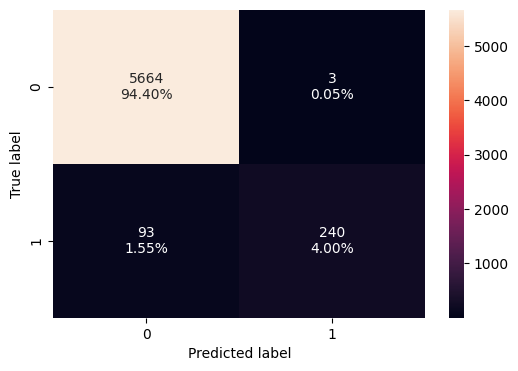

In [399]:
confusion_matrix_sklearn(tuned_rf, X_val, y_val)

Observation of original data tuning:

1. Tuned RandomForest Classifier train set performance was 99.5% Accuracy, 91.0% Recall, 100% Precision and 95.3% F1 score

2. Tuned RandomForest Classifier validation set performance was 98.4% Accuracy, 72.1% Recall, 98.8% Precision and 83.3% F1 score

3. Time taken for tuned model to run was 12 min 56 s

4. Cross validation accuracy score was 69.50%

Hence concluded, validation set showed reduced overall performance score compared to training set so it might be a possibility of overfitting. Also, this model took long time to run leading to fair cross validation accuracy score.

**Oversampled RF model:**

In [400]:
%%time
# defining model
Model_rf_over = RandomForestClassifier(random_state=1)

# Parameter grid to pass in RandomSearchCV
param_grid = { "n_estimators": [200,250,300],
              "min_samples_leaf": np.arange(1, 4),
               "max_features": [np.arange(0.3, 0.6, 0.1),'sqrt'],
               "max_samples": np.arange(0.4, 0.7, 0.1) }

#Calling RandomizedSearchCV
randomized_cv = RandomizedSearchCV(estimator=Model_rf_over, param_distributions=param_grid, n_iter=10, n_jobs = 1, scoring=scorer, cv=5, random_state=1)

#Fitting parameters in RandomizedSearchCV
randomized_cv.fit(X_train_over,y_train_over)

print("Best parameters are {} with CV score={}:" .format(randomized_cv.best_params_,randomized_cv.best_score_))

Best parameters are {'n_estimators': 250, 'min_samples_leaf': np.int64(1), 'max_samples': np.float64(0.6), 'max_features': 'sqrt'} with CV score=0.9815469200872826:
CPU times: user 18min 55s, sys: 676 ms, total: 18min 56s
Wall time: 19min 1s


In [401]:
# Creating new pipeline with best parameters
tuned_rf_over = RandomForestClassifier(
    n_estimators=250,
    min_samples_leaf= np.int64(1),
    max_samples= np.float64(0.6),
    max_features='sqrt',
    random_state=1)

tuned_rf_over.fit(X_train_over, y_train_over)

RandomForestClassifier(max_samples=np.float64(0.6),
                       min_samples_leaf=np.int64(1), n_estimators=250,
                       random_state=1)

In [402]:
# Model Performance on training set
rf_score_over = model_performance_classification_sklearn(tuned_rf_over, X_train_over, y_train_over)
rf_score_over

Accuracy  Recall  Precision    F1
0     1.000   0.999      1.000 1.000

In [403]:
# Model Performance on validation set
rf_score_over_val = model_performance_classification_sklearn(tuned_rf_over, X_val, y_val)
rf_score_over_val

Accuracy  Recall  Precision    F1
0     0.987   0.865      0.897 0.881

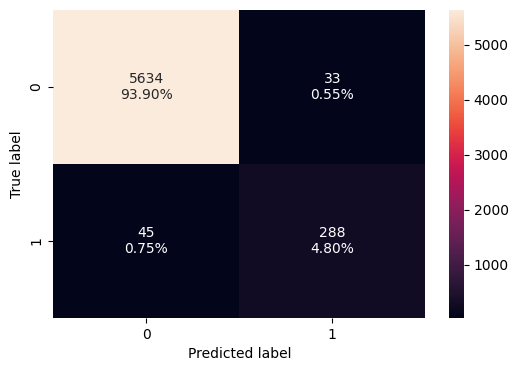

In [404]:
confusion_matrix_sklearn(tuned_rf_over, X_val, y_val)

Observation of oversampled data tuning:

1. Tuned RandomForest Classifier train set performance was 100% Accuracy, 99.9% Recall, 100% Precision and 100% F1 score

2. Tuned RandomForest Classifier validation set performance was 98.7% Accuracy, 86.5% Recall, 89.7% Precision and 88.1% F1 score

3. Time taken for tuned model to run was 19 min 1 s

4. Cross validation accuracy score was 98.15%

Hence concluded, validation set showed slightly reduced overall performance score compared to training set. Also, this model took long time to run compared to original data set leading to improved cross validation accuracy score of 98.15%. As a result, this oversampled data model is better than original data model.

**Undersampled rf model:**

In [405]:
%%time
# defining model
Model_rf_un = RandomForestClassifier(random_state=1)

# Parameter grid to pass in RandomSearchCV
param_grid = { "n_estimators": [200,250,300],
              "min_samples_leaf": np.arange(1, 4),
               "max_features": [np.arange(0.3, 0.6, 0.1),'sqrt'],
               "max_samples": np.arange(0.4, 0.7, 0.1) }

#Calling RandomizedSearchCV
randomized_cv = RandomizedSearchCV(estimator=Model_rf_un, param_distributions=param_grid, n_iter=10, n_jobs = 1, scoring=scorer, cv=5, random_state=1)

#Fitting parameters in RandomizedSearchCV
randomized_cv.fit(X_train_un,y_train_un)

print("Best parameters are {} with CV score={}:" .format(randomized_cv.best_params_,randomized_cv.best_score_))

Best parameters are {'n_estimators': 300, 'min_samples_leaf': np.int64(1), 'max_samples': np.float64(0.6), 'max_features': 'sqrt'} with CV score=0.9047477253928868:
CPU times: user 56.1 s, sys: 110 ms, total: 56.2 s
Wall time: 56.5 s


In [406]:
# Creating new pipeline with best parameters
tuned_rf_un = RandomForestClassifier(
    n_estimators=300,
    min_samples_leaf= np.int64(1),
    max_samples= np.float64(0.6),
    max_features='sqrt',
    random_state=1)

tuned_rf_un.fit(X_train_un, y_train_un)

RandomForestClassifier(max_samples=np.float64(0.6),
                       min_samples_leaf=np.int64(1), n_estimators=300,
                       random_state=1)

In [407]:
# Model performance of training set
rf_score_un = model_performance_classification_sklearn(tuned_rf_un, X_train_un, y_train_un)
rf_score_un

Accuracy  Recall  Precision    F1
0     0.988   0.978      0.999 0.988

In [408]:
# Model performance on validation set
rf_score_un_val = model_performance_classification_sklearn(tuned_rf_un, X_val, y_val)
rf_score_un_val

Accuracy  Recall  Precision    F1
0     0.934   0.880      0.451 0.597

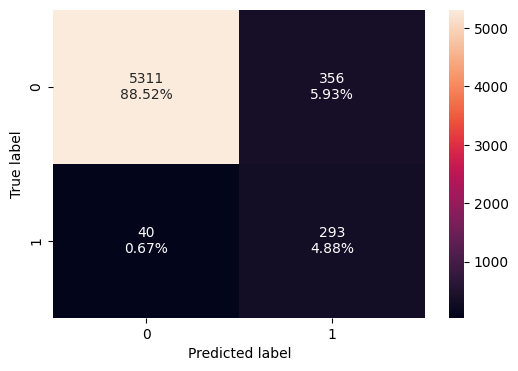

In [409]:
confusion_matrix_sklearn(tuned_rf_un, X_val, y_val)

Observation of undersampled data tuning:

1. Tuned RandomForest Classifier train set performance was 98.8% Accuracy, 97.8% Recall, 99.9% Precision and 98.8% F1 score

2. Tuned RandomForest Classifier validation set performance was 93.4% Accuracy, 88.0% Recall, 45.1% Precision and 59.7% F1 score

3. Time taken for tuned model to run was 56.5 s

4. Cross validation accuracy score was 90.47%

Hence concluded, validation set showed slightly reduced overall performance score compared to training set and worst precision and F1 score. Also, this model took lowest time to run compared to original data and oversampled data model set leading to fair cross validation accuracy score of 98.15% which is less compared to oversampled data model.


As a result, this oversampled data model is better than original data model as well as undersampled data model.

**It appears that best model in RandomForest Classifier is Original tuned model.**

**Gradient Boost Classifier: Original data set**

In [410]:
%%time
# defining model
Model_gb = GradientBoostingClassifier(random_state=1)

# Parameter grid to pass in RandomSearchCV
param_grid =  { "n_estimators": np.arange(100,150,25),
               "learning_rate": [0.2, 0.05, 1],
                "subsample":[0.5,0.7],
                "max_features":[0.5,0.7] }

#Calling RandomizedSearchCV
randomized_cv = RandomizedSearchCV(estimator=Model_gb, param_distributions=param_grid, n_iter=10, n_jobs = 1, scoring=scorer, cv=5, random_state=1)

#Fitting parameters in RandomizedSearchCV
randomized_cv.fit(X_train,y_train)

print("Best parameters are {} with CV score={}:" .format(randomized_cv.best_params_,randomized_cv.best_score_))

Best parameters are {'subsample': 0.7, 'n_estimators': np.int64(125), 'max_features': 0.5, 'learning_rate': 0.2} with CV score=0.7555417700578991:
CPU times: user 8min 12s, sys: 359 ms, total: 8min 12s
Wall time: 8min 14s


In [411]:
# Creating new pipeline with best parameters
tuned_gb = GradientBoostingClassifier(
    subsample= 0.7,
    n_estimators= np.int64(125),
    max_features= 0.5,
    learning_rate= 0.2,
    random_state=1)

tuned_gb.fit(X_train, y_train)

GradientBoostingClassifier(learning_rate=0.2, max_features=0.5,
                           n_estimators=np.int64(125), random_state=1,
                           subsample=0.7)

In [412]:
# Model performance on training set
gb_score = model_performance_classification_sklearn(tuned_gb, X_train, y_train)
gb_score

Accuracy  Recall  Precision    F1
0     0.995   0.916      0.989 0.951

In [413]:
# Model performance on validation set
gb_score_val = model_performance_classification_sklearn(tuned_gb, X_val, y_val)
gb_score_val

Accuracy  Recall  Precision    F1
0     0.981   0.769      0.880 0.821

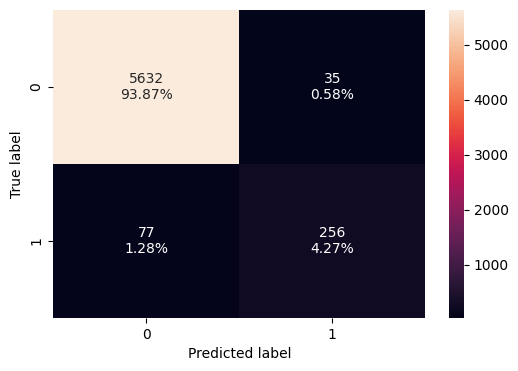

In [414]:
confusion_matrix_sklearn(tuned_gb, X_val, y_val)

Observation of original data tuning:

1. Tuned Gradient Boosting Classifier train set performance was 99.5% Accuracy, 91.6% Recall, 98.9% Precision and 95.1% F1 score

2. Tuned Gradient Boosting Classifier validation set performance was 98.1% Accuracy, 76.9% Recall, 88.0% Precision and 82.1% F1 score

3. Time taken for tuned model to run was 8 min 14 s

4. Cross validation accuracy score was 75.55%

Overall, the validation performance was reduced with Recall and F1 score compared to training set. Also, cross validation was fair but not the best.

**Gradient Boost Classifier Oversampled tuning:**

In [415]:
%%time
# defining model
Model_gb_over = GradientBoostingClassifier(random_state=1)

# Parameter grid to pass in RandomSearchCV
param_grid =  { "n_estimators": np.arange(100,150,25),
               "learning_rate": [0.2, 0.05, 1],
                "subsample":[0.5,0.7],
                "max_features":[0.5,0.7] }

#Calling RandomizedSearchCV
randomized_cv = RandomizedSearchCV(estimator=Model_gb_over, param_distributions=param_grid, n_iter=10, n_jobs = 1, scoring=scorer, cv=5, random_state=1)

#Fitting parameters in RandomizedSearchCV
randomized_cv.fit(X_train_over,y_train_over)

print("Best parameters are {} with CV score={}:" .format(randomized_cv.best_params_,randomized_cv.best_score_))

Best parameters are {'subsample': 0.7, 'n_estimators': np.int64(125), 'max_features': 0.5, 'learning_rate': 1} with CV score=0.9716400081219667:
CPU times: user 15min 51s, sys: 569 ms, total: 15min 51s
Wall time: 15min 55s


In [416]:
# Creating new pipeline with best parameters
tuned_gb_over = GradientBoostingClassifier(
    subsample= 0.7,
    n_estimators= np.int64(125),
    max_features= 0.5,
    learning_rate= 1,
    random_state=1)

tuned_gb_over.fit(X_train_over, y_train_over)

GradientBoostingClassifier(learning_rate=1, max_features=0.5,
                           n_estimators=np.int64(125), random_state=1,
                           subsample=0.7)

In [417]:
# Model performance on training set
gb_score_over = model_performance_classification_sklearn(tuned_gb_over, X_train_over, y_train_over)
gb_score_over

Accuracy  Recall  Precision    F1
0     0.986   0.985      0.988 0.986

In [418]:
# Model performance on validation set
gb_score_over_val = model_performance_classification_sklearn(tuned_gb_over, X_val, y_val)
gb_score_over_val

Accuracy  Recall  Precision    F1
0     0.958   0.826      0.588 0.687

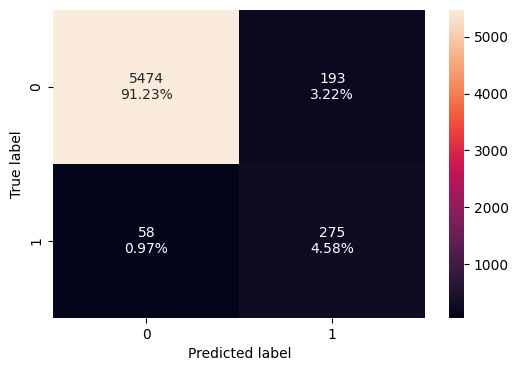

In [419]:
confusion_matrix_sklearn(tuned_gb_over, X_val, y_val)

Observation of oversampled data tuning:

1. Tuned Gradient Boosting Classifier train set performance was 98.6% Accuracy, 98.5% Recall, 98.8% Precision and 98.6% F1 score

2. Tuned Gradient Boosting Classifier validation set performance was 95.8% Accuracy, 82.6% Recall, 58.8% Precision and 68.7% F1 score

3. Time taken for tuned model to run was 15 min 55 s

4. Cross validation accuracy score was 97.16%

Overall, the validation performance was reduced with Recall and F1 score compared to training set, there could be overfitting issue. It took more time to run than original model which is costly. Also, cross validation was improved from orignial data set. Hence, it is not clear that oversampled model performed better than original model.  

**Gradient Boosting Classifier: Undersampled tuning**

In [446]:
%%time
# defining model
Model_gb_un = GradientBoostingClassifier(random_state=1)

# Parameter grid to pass in RandomSearchCV
param_grid =  { "n_estimators": np.arange(100,150,25),
               "learning_rate": [0.2, 0.05, 1],
                "subsample":[0.5,0.7],
                "max_features":[0.5,0.7] }

#Calling RandomizedSearchCV
randomized_cv = RandomizedSearchCV(estimator=Model_gb_un, param_distributions=param_grid, n_iter=10, n_jobs = 1, scoring=scorer, cv=5, random_state=1)

#Fitting parameters in RandomizedSearchCV
randomized_cv.fit(X_train_un,y_train_un)

print("Best parameters are {} with CV score={}:" .format(randomized_cv.best_params_,randomized_cv.best_score_))

Best parameters are {'subsample': 0.7, 'n_estimators': np.int64(100), 'max_features': 0.7, 'learning_rate': 0.05} with CV score=0.9060297766749379:
CPU times: user 59.8 s, sys: 169 ms, total: 60 s
Wall time: 1min 11s


In [ ]:
# Creating new pipeline with best parameters
tuned_gb_un = GradientBoostingClassifier(
    subsample= 0.7,
    n_estimators= np.int64(100),
    max_features= 0.7,
    learning_rate= 0.05,
    random_state=1)

tuned_gb_un.fit(X_train_un, y_train_un)

In [313]:
# Model Performance of training set
gb_score_un = model_performance_classification_sklearn(tuned_gb_un, X_train, y_train)
gb_score_un

Accuracy  Recall  Precision    F1
0     0.933   0.919      0.448 0.602

In [314]:
# Model performance on validation set
gb_score_un_val = model_performance_classification_sklearn(tuned_gb_un, X_val, y_val)
gb_score_un_val

Accuracy  Recall  Precision    F1
0     0.921   0.871      0.403 0.551

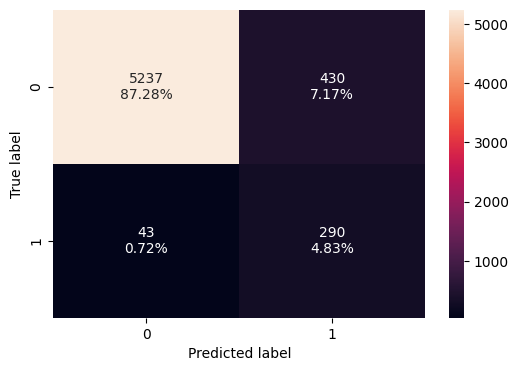

In [315]:
confusion_matrix_sklearn(tuned_gb_un, X_val, y_val)

Observation of undersampled data tuning:

1. Tuned Gradient Boosting Classifier train set performance was 93.3% Accuracy, 91.9% Recall, 44.8% Precision and 60.2% F1 score

2. Tuned Gradient Boosting Classifier validation set performance was 92.1% Accuracy, 87.1% Recall, 40.3% Precision and 55.1% F1 score

3. Time taken for tuned model to run was 1 min 11 s

4. Cross validation accuracy score was 90.60%

Overall, the validation performance was reduced with Recall and F1 score compared to training set and both Precision and F1 score of training and validation data set was worst. It took much lesser time to run than original model and oversampled model which makes it less costly. Also, cross validation was improved from orignial data set. Hence, it is clear that undersampled model performed bad than oversampled model and original model.

**However, it looks like original Gradient Boost model outperformed oversampled and undersampled model in all metrics criteria**

**XGBoost Classifer: Original Model Tuning**

In [316]:
%%time
# defining model
Model_xg = XGBClassifier(random_state=1)

# Parameter grid to pass in RandomSearchCV
param_grid={ 'n_estimators': [150, 200, 250],
             'scale_pos_weight': [5,10],
             'learning_rate': [0.1,0.2],
             'gamma': [0,3,5],
             'subsample': [0.8,0.9] }

#Calling RandomizedSearchCV
randomized_cv = RandomizedSearchCV(estimator=Model_xg, param_distributions=param_grid, n_iter=10, n_jobs = 1, scoring=scorer, cv=5, random_state=1)

#Fitting parameters in RandomizedSearchCV
randomized_cv.fit(X_train,y_train)

print("Best parameters are {} with CV score={}:" .format(randomized_cv.best_params_,randomized_cv.best_score_))

Best parameters are {'subsample': 0.8, 'scale_pos_weight': 10, 'n_estimators': 200, 'learning_rate': 0.1, 'gamma': 5} with CV score=0.8597766749379652:
CPU times: user 2min 22s, sys: 419 ms, total: 2min 23s
Wall time: 1min 21s


In [317]:
# Creating new pipeline with best parameters
tuned_xg = XGBClassifier(
    subsample= 0.8,
    scale_pos_weight= 10,
    n_estimators= 200,
    learning_rate= 0.05,
    gamma= 5,
    random_state=1)

tuned_xg.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=5, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, random_state=1, ...)

In [318]:
# Model performance on training set
xg_score = model_performance_classification_sklearn(tuned_xg, X_train, y_train)
xg_score

Accuracy  Recall  Precision    F1
0     0.998   0.999      0.970 0.984

In [319]:
# Model performance on validation set
xg_score_val = model_performance_classification_sklearn(tuned_xg, X_val, y_val)
xg_score_val

Accuracy  Recall  Precision    F1
0     0.988   0.853      0.916 0.883

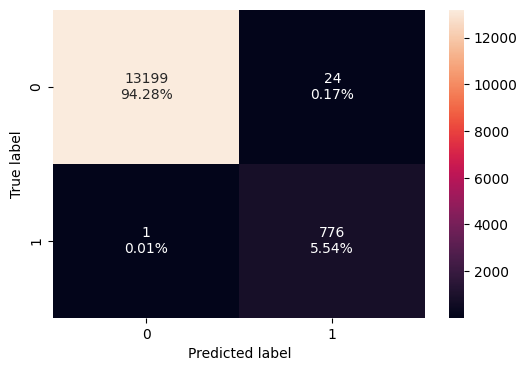

In [320]:
confusion_matrix_sklearn(tuned_xg, X_train, y_train)

Observation of original XGB data tuning:

1. Tuned XG Boosting Classifier train set performance was 99.8% Accuracy, 99.9% Recall, 97.0% Precision and 98.4% F1 score

2. Tuned XG Boosting Classifier validation set performance was 98.8% Accuracy, 85.3% Recall, 91.6% Precision and 88.3% F1 score

3. Time taken for tuned model to run was 1 min 21 s

4. Cross validation accuracy score was 85.97%

Overall, the validation performance was reduced with Recall and F1 score compared to training set. It took fair time to run. Also, cross validation was fair. The performance was good.

**XGB Classifier: Oversampled model tuning:**

In [321]:
%%time
# defining model
Model_xg_over = XGBClassifier(random_state=1)

# Parameter grid to pass in RandomSearchCV
param_grid={ 'n_estimators': [150, 200, 250],
             'scale_pos_weight': [5,10],
             'learning_rate': [0.1,0.2],
             'gamma': [0,3,5],
             'subsample': [0.8,0.9] }

#Calling RandomizedSearchCV
randomized_cv = RandomizedSearchCV(estimator=Model_xg_over, param_distributions=param_grid, n_iter=10, n_jobs = 1, scoring=scorer, cv=5, random_state=1)

#Fitting parameters in RandomizedSearchCV
randomized_cv.fit(X_train_over,y_train_over)

print("Best parameters are {} with CV score={}:" .format(randomized_cv.best_params_,randomized_cv.best_score_))

Best parameters are {'subsample': 0.9, 'scale_pos_weight': 10, 'n_estimators': 200, 'learning_rate': 0.2, 'gamma': 0} with CV score=0.9963696524427388:
CPU times: user 4min 4s, sys: 657 ms, total: 4min 5s
Wall time: 2min 20s


In [322]:
# Creating new pipeline with best parameters
tuned_xg_over = XGBClassifier(
    subsample= 0.9,
    scale_pos_weight= 10,
    n_estimators= 200,
    learning_rate= 0.2,
    gamma= 0,
    random_state=1)

tuned_xg_over.fit(X_train_over, y_train_over)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.2, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, random_state=1, ...)

In [323]:
# Model performance on training set
xg_score_over = model_performance_classification_sklearn(tuned_xg_over, X_train_over, y_train_over)
xg_score_over

Accuracy  Recall  Precision    F1
0     1.000   1.000      1.000 1.000

In [324]:
# Model performance on validation set
xg_score_over_val = model_performance_classification_sklearn(tuned_xg_over, X_val, y_val)
xg_score_over_val

Accuracy  Recall  Precision    F1
0     0.983   0.880      0.821 0.849

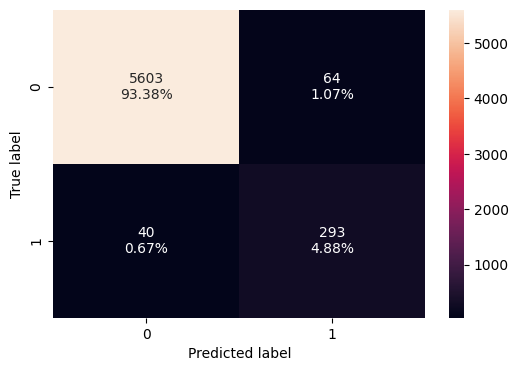

In [325]:
confusion_matrix_sklearn(tuned_xg_over, X_val, y_val)

Observation of Oversampled XGB data tuning:

1. Tuned XG Boosting Classifier train set performance was 100% Accuracy, 100% Recall, 100% Precision and 100% F1 score

2. Tuned XG Boosting Classifier validation set performance was 98.3% Accuracy, 88.0% Recall, 82.1% Precision and 84.9% F1 score

3. Time taken for tuned model to run was 2 min 20 s

4. Cross validation accuracy score was 99.63%

Overall, the training performance shows 100% metrics which increases the possibility of overfitting. The validation set shows fair Recall and F1 score. It took more time to run than original model but not much that it affect the cost of programming. Also, cross validation was outstanding. The performance was good but there might be overfitting issue in this model.  

**XGB Classifier: Undersampled Model Tuning:**

In [326]:
%%time
# defining model
Model_xg_un = XGBClassifier(random_state=1)

# Parameter grid to pass in RandomSearchCV
param_grid={ 'n_estimators': [150, 200, 250],
             'scale_pos_weight': [5,10],
             'learning_rate': [0.1,0.2],
             'gamma': [0,3,5],
             'subsample': [0.8,0.9] }

#Calling RandomizedSearchCV
randomized_cv = RandomizedSearchCV(estimator=Model_xg_un, param_distributions=param_grid, n_iter=10, n_jobs = 1, scoring=scorer, cv=5, random_state=1)

#Fitting parameters in RandomizedSearchCV
randomized_cv.fit(X_train_un,y_train_un)

print("Best parameters are {} with CV score={}:" .format(randomized_cv.best_params_,randomized_cv.best_score_))

Best parameters are {'subsample': 0.8, 'scale_pos_weight': 10, 'n_estimators': 150, 'learning_rate': 0.1, 'gamma': 3} with CV score=0.9253515301902399:
CPU times: user 1min 2s, sys: 263 ms, total: 1min 2s
Wall time: 36.5 s


In [327]:
# Creating new pipeline with best parameters
tuned_xg_un = XGBClassifier(
    subsample= 0.8,
    scale_pos_weight= 10,
    n_estimators= 150,
    learning_rate= 0.1,
    gamma= 3,
    random_state=1)

tuned_xg_un.fit(X_train_un, y_train_un)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=3, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=150, n_jobs=None,
              num_parallel_tree=None, random_state=1, ...)

In [328]:
# Model performance on training set
xg_score_un = model_performance_classification_sklearn(tuned_xg_un, X_train_un, y_train_un)
xg_score_un

Accuracy  Recall  Precision    F1
0     0.994   1.000      0.989 0.994

In [329]:
# Model performance on validation set
xg_score_un_val = model_performance_classification_sklearn(tuned_xg_un, X_val, y_val)
xg_score_un_val

Accuracy  Recall  Precision    F1
0     0.851   0.913      0.260 0.405

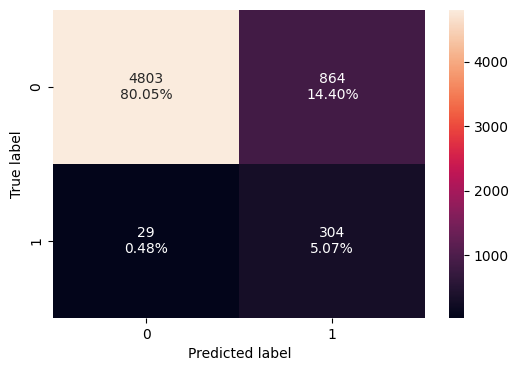

In [330]:
confusion_matrix_sklearn(tuned_xg_un, X_val, y_val)

Observation of Undersampled XGB data tuning:

1. Tuned XG Boosting Classifier train set performance was 99.4% Accuracy, 100% Recall, 98.9% Precision and 99.4% F1 score

2. Tuned XG Boosting Classifier validation set performance was 85.1% Accuracy, 91.3% Recall, 26.0% Precision and 40.5% F1 score

3. Time taken for tuned model to run was 36.5 s

4. Cross validation accuracy score was 92.53%

Overall, the training performance shows good score but validation performance was reduced which sparks the possibility of overfitting. The validation set shows worst Recall and F1 score. It took less time to run than oversampled model. Also, cross validation was good. The performance was not good as there might be overfitting issue in this model.  

### **Hence proved, that original tuning model of XGB Classifier outperformed oversampled and undersampled tuned model. **

## Model performance comparison and choosing the final model

From all the above tuned model, the best model selected are:

1. Decision Tree Original Tuned Model
2. Random Forest Original Tuned Model
3. Gradient Boost Original Tuned Model
4. XGBoost Original Tuned Model

In [423]:
# training performance comparison

models_train_comp_df = pd.concat(
    [
        dt_score.T,  # Transpose to have metrics as rows
        rf_score.T,  # Transpose to have metrics as rows
        gb_score.T,  # Transpose to have metrics as rows
        xg_score.T,  # Transpose to have metrics as rows
    ],
    axis=1,
)
models_train_comp_df.columns = [
    "Decision Tree tuned with original data",
    "Random Forest tuned with original data",
    "Gradient Boost tuned with original data",
    "XGBoost tuned with original data",
]
print("Training performance comparison:")
models_train_comp_df

Training performance comparison:


Decision Tree tuned with original data  \
Accuracy                                    0.976   
Recall                                      0.631   
Precision                                   0.911   
F1                                          0.745   

           Random Forest tuned with original data  \
Accuracy                                    0.995   
Recall                                      0.910   
Precision                                   1.000   
F1                                          0.953   

           Gradient Boost tuned with original data  \
Accuracy                                     0.995   
Recall                                       0.916   
Precision                                    0.989   
F1                                           0.951   

           XGBoost tuned with original data  
Accuracy                              0.998  
Recall                                0.999  
Precision                             0.970  
F1                                    0.984

In [424]:
# Validation performance comparison

models_val_comp_df = pd.concat(
    [
        dt_score_val.T,  # Transpose to have metrics as rows
        rf_score_val.T,  # Transpose to have metrics as rows
        gb_score_val.T,  # Transpose to have metrics as rows
        xg_score_val.T,  # Transpose to have metrics as rows
    ],
    axis=1,
)
models_val_comp_df.columns = [
    "Decision Tree tuned with original data",
    "Random Forest tuned with original data",
    "Gradient Boost tuned with original data",
    "XGBoost tuned with original data",
]
print("Validation performance comparison:")
models_val_comp_df

Validation performance comparison:


Decision Tree tuned with original data  \
Accuracy                                    0.972   
Recall                                      0.631   
Precision                                   0.814   
F1                                          0.711   

           Random Forest tuned with original data  \
Accuracy                                    0.984   
Recall                                      0.721   
Precision                                   0.988   
F1                                          0.833   

           Gradient Boost tuned with original data  \
Accuracy                                     0.981   
Recall                                       0.769   
Precision                                    0.880   
F1                                           0.821   

           XGBoost tuned with original data  
Accuracy                              0.988  
Recall                                0.853  
Precision                             0.916  
F1                                    0.883

Observations:

1. Decision Tree model performance has low Recall score, so we cannot select that.

2. Random Forest model performance shows good score but validation performance Recall score was low.

3. Gradient Boosting train performance was good but it showed reduced performance on validation set

4. XGBoost model shows good training and validation performance.


#Hence, we will select XGBoost Original tuned model as best model for further model building

### Test set final performance

In [425]:
# Testing performance
test_score_xg = model_performance_classification_sklearn(tuned_xg, X_test, y_test)
test_score_xg

Accuracy  Recall  Precision    F1
0     0.986   0.830      0.921 0.873

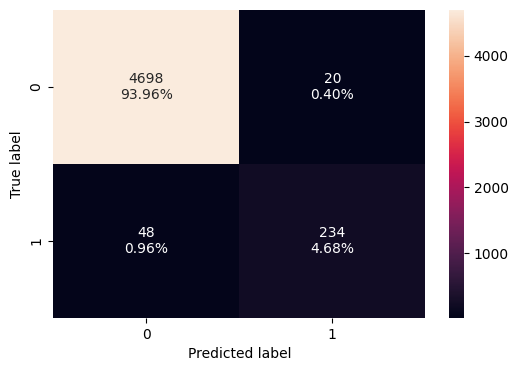

In [426]:
confusion_matrix_sklearn(tuned_xg, X_test, y_test)

**Observations: The performance on test was good, it also gave good recall score leading more True positives prediction of the model**

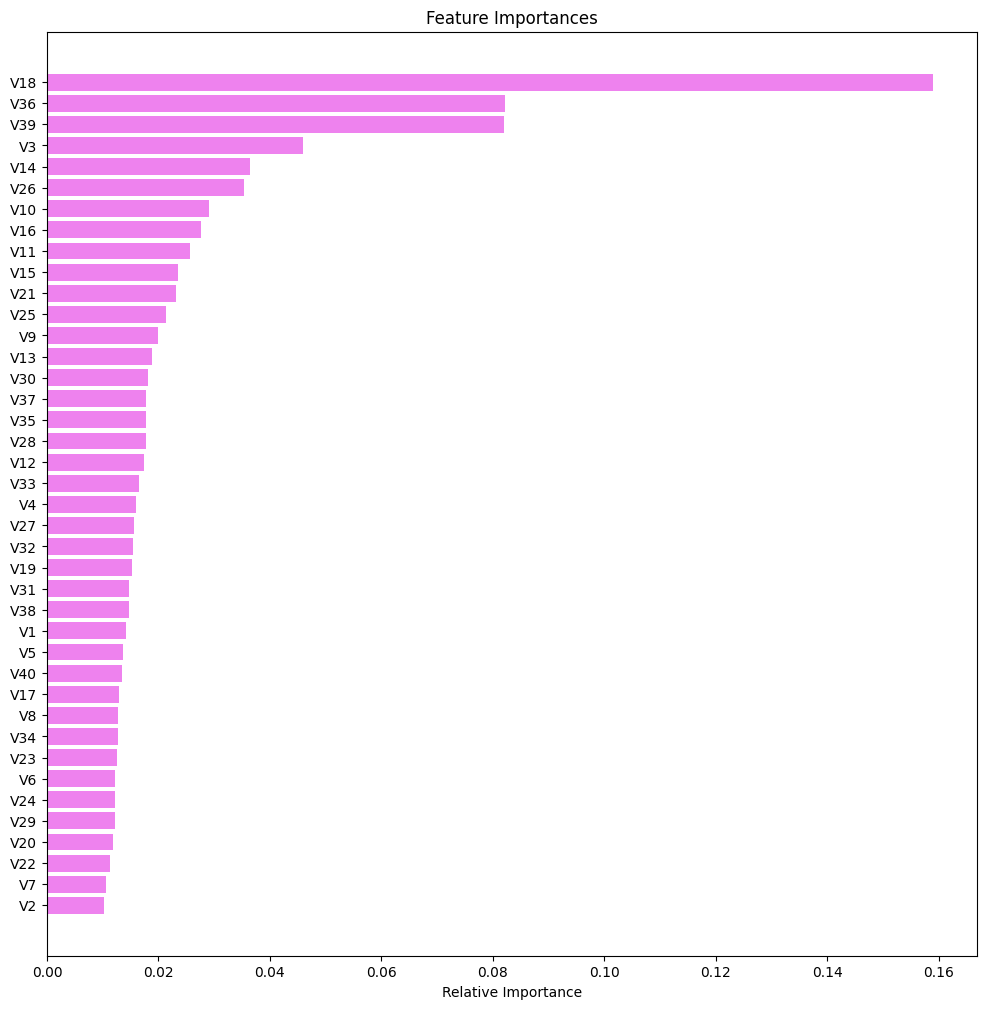

In [427]:
# Feature Importances
feature_names = X_train.columns
importances = tuned_xg.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(12, 12))
plt.title("Feature Importances")
plt.barh(range(len(indices)), importances[indices], color="violet", align="center")
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel("Relative Importance")
plt.show()

**Observation: The most important feature for prediction are V18, V36, and V39**

## Pipelines to build the final model


In [431]:
# Separating target variable and other variables
X1 = df.drop(columns="Target")
y1 = df["Target"]

# Since we already have a separate test set, we don't need to divide data into train and test

X_test1 = df_test.drop(['Target'], axis=1)
y_test1 = df_test['Target']

In [432]:
# We can't oversample/undersample data without doing missing value treatment, so let's first treat the missing values in the train set
imputer = SimpleImputer(strategy="median")
X1 = imputer.fit_transform(X1)

** We don't need to impute missing values in test set as it will be done inside pipeline**

In [441]:
# Construct Pipeline
pipeline_model = Pipeline(steps=[("pre", StandardScaler()), ("xg", tuned_xg)])

In [442]:
pipeline_model.fit(X1, y1)

Pipeline(steps=[('pre', StandardScaler()),
                ('xg',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None, device=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               feature_types=None, gamma=5, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.05,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=200, n_jobs=None,
                               num_parallel_tree=None, random_state=1, ...))])

In [443]:
pipeline_score_train = model_performance_classification_sklearn(pipeline_model, X1, y1)
pipeline_score_train

Accuracy  Recall  Precision    F1
0     0.998   0.999      0.967 0.983

In [444]:
pipeline_score_test = model_performance_classification_sklearn(pipeline_model, X_test1, y_test1)
pipeline_score_test

Accuracy  Recall  Precision    F1
0     0.987   0.844      0.919 0.880

Observations:

1. The training performance of pipeline was 99.8% Accuracy, 99.9% Recall, 96.7% Precision, 98.3% F1 score

2. The testing performance of pipeline was 98.7% Accuracy, 84.4% Recall, 91.9% Precision, 88.0% F1 score

Overall, the performance of training and testing set under pipeline were outstanding with good Recall score which means it has less chances of not getting True Positives.


# Business Insights and Conclusions

1. The training set achieved near-perfect performance with 99.8% accuracy, 99.9% recall, 96.7% precision, and 98.3% F1-score, indicating the model effectively learned patterns in the data.

2. The testing set maintained strong generalization with 98.7% accuracy, though recall dropped to 84.4%, while precision remained high at 91.9%, leading to an F1-score of 88.0%.

3. A high recall (99.9% in training and 84.4% in testing) indicates that the model successfully identifies most failures, minimizing false negatives—a crucial factor for predictive maintenance.

4. A precision of 91.9% on the testing set suggests the model makes accurate failure predictions, reducing unnecessary repairs and costs.

5. The most influential features for predicting failures are V18, V36, and V39, making them critical variables for understanding generator breakdowns.

6. The normal distribution of all variables (V1-V40) suggests well-balanced data, supporting reliable model training and inference.

**Conclusion: **

1. The pipeline demonstrates outstanding classification performance, particularly in recall, ensuring fewer failures go undetected. The strong test accuracy and Recall score confirm that the model generalizes well to unseen data. However, the drop in recall from training to testing indicates slight overfitting, suggesting potential for further fine-tuning.

2. By leveraging this model, maintenance teams can proactively repair generators before failure, minimizing downtime, repair costs, and operational disruptions. Also, they should do frequent inspection of the units as inspection and repairs cost way too less than cost of replacing.

3. Regular monitoring using the model's insights will allow early detection of potential failures, reducing unexpected downtime and optimizing maintenance scheduling.



***